## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=example-notebooks%2Ftimeseries-stac-api.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Using a list of STAC items and a bouding box fetch stats from `/cog/statistics` endpoint
   2. Generate a timeseries plot using statistics from each time step
   3. Speed up workflow using Dask


In [1]:
import requests
import folium
import matplotlib.pyplot as plt

## Declare your collection of interest

You can discover available collections the following ways:

* Programmatically: see example in the `list-collections.ipynb` notebook
* JSON API: https://staging-stac.delta-backend.com/collections
* STAC Browser: http://veda-staging-stac-browser.s3-website-us-west-2.amazonaws.com

In [2]:
STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

collection_name = 'no2-monthly'

## Fetch STAC collection

We will use `requests` to fetch all the metadata about the collection of interest from STAC.

In [3]:
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'no2-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'}],
 'title': 'NO₂',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2016-01-01 00:00:00+00',
     '2022-12-01 00:00:00+00']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2016-01-01T00:00:00Z', '2022-12-01T00:00:00Z'],
  'cog_default': {'max': 50064805976866816, 'min': -10183824872833024}},
 'description': 'Darker colors indicate higher nitrogen dioxide (NO₂) levels and more activity. Lighter colors indicate lower levels of N

### Describe the periodic nature of the data

In the collection above we will pay particular attention to the fields that define the periodicity of the data.

In [4]:
collection["dashboard:is_periodic"]

True

In [5]:
collection["dashboard:time_density"]

'month'

In [6]:
collection["summaries"]

{'datetime': ['2016-01-01T00:00:00Z', '2022-12-01T00:00:00Z'],
 'cog_default': {'max': 50064805976866816, 'min': -10183824872833024}}

## Fetch STAC items

Get the list of all the STAC items within this collection.

In [7]:
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=100").json()["features"]
len(items)

84

We can inspect one of these items to get a sense of what metadata is available.

In [8]:
items[0]

{'id': 'OMI_trno2_0.10x0.10_202212_Col3_V4.nc',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202212_Col3_V4.nc'}],
 'assets': {'cog_default': {'href': 's3://veda-data-store-staging/no2-monthly/OMI_trno2_0.10x0.10_202212_Col3_V4.nc.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Default COG Layer',
   'description': 'Cloud optimized default layer to display on map',
   'raster:bands

## Define an area of interest

We will be using a bounding box over metropolitan france. We'll use that bounding box to subset the data when calculating the timeseries.

In [9]:
france_bounding_box = {
    "type": "Feature",
    "properties": {"ADMIN": "France", "ISO_A3": "FRA"},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-5.183429, 42.332925],
                [8.233998, 42.332925],
                [8.233998, 51.066135],
                [-5.183429, 51.066135],
                [-5.183429, 42.332925],
            ]
        ],
    },
}

Let's take a look at that box.

In [10]:
m = folium.Map(
    location=[40,0],
    zoom_start=3,
)

folium.GeoJson(france_bounding_box, name="France").add_to(m)
m

## Use `/cog/statistics` to get data for the AOI

First, we create a `generate_stats` function and then we call it with the bounding box defined for France. 

In [11]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics", 
        params={"url": item["assets"]["cog_default"]["href"]},
        json=geojson
    ).json()    
    return {
        **result["properties"], "start_datetime": item["properties"]["start_datetime"]
    }

### Generate stats

This may take some time due to the complexity of the shape we're requesting. See the end of this notebook for tips on how to speed this up.

In [12]:
%%time 
stats = [generate_stats(item, france_bounding_box) for item in items]

CPU times: user 6.06 s, sys: 226 ms, total: 6.29 s
Wall time: 1min 42s


### Inspect one result

In [13]:
stats[0]

{'statistics': {'1': {'min': -3811088227368960.0,
   'max': 2.110830182347571e+16,
   'mean': 2198312557605593.8,
   'count': 10941.0,
   'sum': 2.40517376927628e+19,
   'std': 2015876566313865.5,
   'median': 1698433945567232.0,
   'majority': 1910535939424256.0,
   'minority': -3811088227368960.0,
   'unique': 10805.0,
   'histogram': [[44.0,
     3253.0,
     6020.0,
     1061.0,
     357.0,
     145.0,
     43.0,
     12.0,
     5.0,
     1.0],
    [-3811088227368960.0,
     -1319149275971584.0,
     1172789809643520.0,
     3664728895258624.0,
     6156667578220544.0,
     8648607066488832.0,
     1.1140546017886208e+16,
     1.3632484969283584e+16,
     1.612442392068096e+16,
     1.861636179833651e+16,
     2.110830182347571e+16]],
   'valid_percent': 93.85,
   'masked_pixels': 717.0,
   'valid_pixels': 10941.0,
   'percentile_98': 8518530438581425.0,
   'percentile_2': -286377359756492.6}},
 'ADMIN': 'France',
 'ISO_A3': 'FRA',
 'start_datetime': '2022-12-01T00:00:00'}

## Plot timeseries

It is easier to interact with these results as a pandas dataframe. The following function takes the json, passes it to pandas, cleans up the column names and parses the date column.

In [14]:
import pandas as pd

def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df

df = clean_stats(stats)

### Construct the plot

Text(0.5, 1.0, 'NO2 Values in France (2016-2022)')

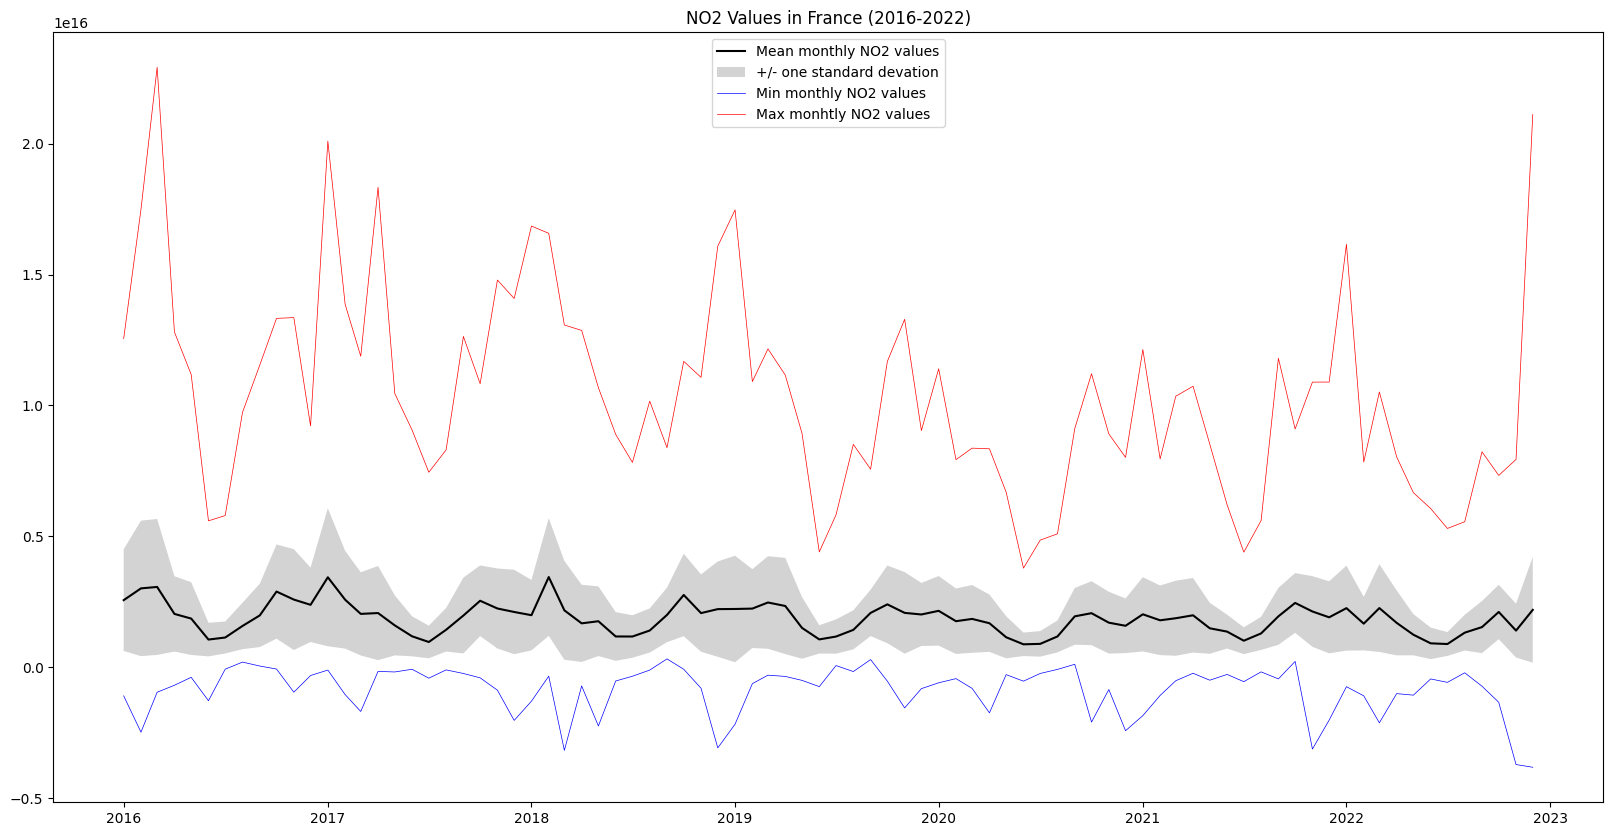

In [15]:
fig = plt.figure(figsize=(20,10))

plt.plot(df["date"], df["mean"], 'black', label="Mean monthly NO2 values")

plt.fill_between(df["date"], df["mean"] + df["std"], df["mean"] - df["std"], facecolor="lightgray", interpolate=False, label="+/- one standard devation")

plt.plot(df["date"], df["min"], color='blue', linestyle="-", linewidth=0.5, label="Min monthly NO2 values")
plt.plot(df["date"], df["max"], color='red', linestyle="-", linewidth=0.5, label="Max monhtly NO2 values")

plt.legend()
plt.title("NO2 Values in France (2016-2022)")

In this graph we can see the yearly cycles in NO2 values due to seasonal variations, as well as a slight downward slope in maximum NO2 values

## Complex AOI

The values plotted above don't correspond _exactly_ to Fance, since the bounding box excludes Corsica and overseas territories such as Mayotte and French Polynesia, and covers parts of neighboring countries including Spain, Italy, Germany and the entirety of Luxembourg. 

While the NO2 values above correspond _more or less_ to those of in France, we can be much more precise by using a  complex geojson that represents the boundaries of France exactly, including overseas territories in the Carribean and Indian Oceans, and South America.

Note: In this notebook we write out the whole perimeter as a `MultiPolygon` in geojson. In practice you will often be reading this kind of shape from a file (usually with the help of `geopandas`).

In [16]:
france_aoi = { 
    "type": "Feature", 
    "properties": { 
        "ADMIN": "France", 
        "ISO_A3": "FRA" 
    }, 
    "geometry": { 
        "type": "MultiPolygon", 
        "coordinates": [ [ [ [ 55.501312696000099, -20.87322356599999 ], [ 55.51400800900015, -20.875176690999936 ], [ 55.527110222, -20.870049737999935 ], [ 55.542491082000168, -20.875095309999963 ], [ 55.578379754000167, -20.87476979000003 ], [ 55.59229576900006, -20.880303643999866 ], [ 55.605804884000094, -20.888278903999918 ], [ 55.65064537900011, -20.898044528999861 ], [ 55.663828972000175, -20.90520598799999 ], [ 55.673838738000171, -20.913181247999859 ], [ 55.695323113000114, -20.935235283999859 ], [ 55.702810092000078, -20.949395440999879 ], [ 55.706553582000112, -20.982110283999901 ], [ 55.712087436000189, -20.993584893999852 ], [ 55.73658287900011, -21.017836195999934 ], [ 55.740000847000061, -21.024672132999939 ], [ 55.741465691000116, -21.044528903999861 ], [ 55.743662957000112, -21.054620049999912 ], [ 55.74683678500017, -21.062595309999878 ], [ 55.753103061000132, -21.066989841999956 ], [ 55.770518425000063, -21.073825778999961 ], [ 55.774180535000113, -21.079278252999913 ], [ 55.77588951900006, -21.08391692499994 ], [ 55.78785241000017, -21.103448174999912 ], [ 55.801768425000063, -21.111993096999853 ], [ 55.837575717000078, -21.12615325299987 ], [ 55.84986412900011, -21.13762786299999 ], [ 55.854502800000063, -21.156996351999837 ], [ 55.849131707000112, -21.173760674999855 ], [ 55.84058678500017, -21.190524997999873 ], [ 55.824229363000171, -21.264336846999981 ], [ 55.821950717000192, -21.285088799999969 ], [ 55.822520379000167, -21.303643487999892 ], [ 55.82081139400006, -21.324965101999865 ], [ 55.812022332000112, -21.342543226999894 ], [ 55.791270379000167, -21.349867445999976 ], [ 55.755707227000102, -21.34889088299991 ], [ 55.737966342000135, -21.351657809999963 ], [ 55.706553582000112, -21.367445570999834 ], [ 55.683116082000112, -21.370782158999859 ], [ 55.659922722000175, -21.369561455999843 ], [ 55.643809441000116, -21.363539320999919 ], [ 55.626800977000158, -21.369398695999877 ], [ 55.601573113000114, -21.370375257999854 ], [ 55.575043165000096, -21.367933851999823 ], [ 55.554453972000175, -21.363539320999919 ], [ 55.537119988000114, -21.35507577899989 ], [ 55.505625847000175, -21.33367278399993 ], [ 55.475433790000096, -21.326918226999908 ], [ 55.43433678500017, -21.311618747999944 ], [ 55.417816602000102, -21.302015882999953 ], [ 55.409841342000078, -21.293389580999872 ], [ 55.404144727000158, -21.284437757999925 ], [ 55.397797071000156, -21.277601820999919 ], [ 55.38705488400015, -21.274834893999866 ], [ 55.354502800000063, -21.274590752999913 ], [ 55.349619988000114, -21.271416924999855 ], [ 55.342295769000117, -21.257500908999873 ], [ 55.30762780000012, -21.219414971999967 ], [ 55.295583530000187, -21.199639580999957 ], [ 55.291026238000228, -21.176446221999839 ], [ 55.290782097, -21.158868096999896 ], [ 55.288422071000156, -21.143649997999916 ], [ 55.24634850400011, -21.090915623 ], [ 55.233246290000096, -21.069268487999921 ], [ 55.225433790000153, -21.048272393999895 ], [ 55.225433790000153, -21.029717705999886 ], [ 55.231211785000113, -21.009698175 ], [ 55.241872592000021, -20.993422132999967 ], [ 55.275401238000057, -20.980238539999931 ], [ 55.28785241000017, -20.964776299999912 ], [ 55.292328321000156, -20.946709893999895 ], [ 55.287445509000094, -20.932224216999856 ], [ 55.293467644000117, -20.926364841999984 ], [ 55.29542076900006, -20.921807549999954 ], [ 55.293467644000117, -20.917250257999825 ], [ 55.287445509000094, -20.911716403999975 ], [ 55.302989129000167, -20.90520598799999 ], [ 55.335948113000171, -20.905043226999936 ], [ 55.36402428500017, -20.886163018999909 ], [ 55.407969597000175, -20.8632138 ], [ 55.455821160000113, -20.86142343500002 ], [ 55.472504102000158, -20.8632138 ], [ 55.501312696000099, -20.87322356599999 ] ] ], [ [ [ 45.282562696000156, -12.804864190999908 ], [ 45.27572675900015, -12.804864190999908 ], [ 45.262217644000231, -12.763360283999916 ], [ 45.277110222, -12.74749114399998 ], [ 45.282562696000156, -12.743422132999839 ], [ 45.289317254000167, -12.759860934999921 ], [ 45.290863477000102, -12.774021091999856 ], [ 45.288422071000099, -12.788344007999839 ], [ 45.282562696000156, -12.804864190999908 ] ] ], [ [ [ 45.090179884000094, -12.663262627999885 ], [ 45.083994988000114, -12.667657158999958 ], [ 45.090505405000187, -12.667087497999987 ], [ 45.093516472000118, -12.66904062299993 ], [ 45.094981316000172, -12.672051690999851 ], [ 45.097178582000225, -12.674493096999882 ], [ 45.110606316000116, -12.685804945999948 ], [ 45.128916863000114, -12.707452080999857 ], [ 45.138682488000228, -12.714939059999921 ], [ 45.15259850400011, -12.718194268999952 ], [ 45.183767123000194, -12.717950127999913 ], [ 45.200694207000112, -12.722914320999877 ], [ 45.217621290000096, -12.734063408999987 ], [ 45.224782748000138, -12.745700778999904 ], [ 45.224945509000094, -12.759535414999903 ], [ 45.220550977000102, -12.777520440999936 ], [ 45.196950717000078, -12.811700127999927 ], [ 45.188161655000187, -12.817071221999967 ], [ 45.188731316000172, -12.828789971999967 ], [ 45.195160352000158, -12.840508721999868 ], [ 45.21314537900011, -12.851820570999848 ], [ 45.210948113000228, -12.865329685 ], [ 45.204356316000116, -12.878513278999961 ], [ 45.200694207000112, -12.883965752999984 ], [ 45.191661004000167, -12.904961846999853 ], [ 45.175303582000055, -12.924004815999936 ], [ 45.16822350400011, -12.944268487999935 ], [ 45.186371290000096, -12.968845309999864 ], [ 45.182302280000073, -12.975762627999956 ], [ 45.17807050900015, -12.981052342000012 ], [ 45.173024936000189, -12.98503997199991 ], [ 45.165863477000158, -12.989190362999949 ], [ 45.159922722000061, -12.97861093499999 ], [ 45.153086785000113, -12.979668877999941 ], [ 45.144297722000061, -12.985772393999852 ], [ 45.13184655000012, -12.989190362999949 ], [ 45.120616082000225, -12.986260674999841 ], [ 45.113291863000228, -12.981052342000012 ], [ 45.106700066000116, -12.978122654 ], [ 45.097178582000225, -12.982354424999841 ], [ 45.098480665000153, -12.967868747999887 ], [ 45.09449303500017, -12.958184502999927 ], [ 45.084971550000063, -12.95370859199987 ], [ 45.070323113000057, -12.955010674999869 ], [ 45.070323113000057, -12.948907158999958 ], [ 45.08838951900006, -12.940362237999949 ], [ 45.090179884000094, -12.924004815999936 ], [ 45.081228061000076, -12.908298434999878 ], [ 45.062510613000057, -12.89853281000002 ], [ 45.065277540000153, -12.89316171699997 ], [ 45.072927280000073, -12.888360283999887 ], [ 45.083994988000114, -12.88738372199991 ], [ 45.09009850400011, -12.891045830999872 ], [ 45.107920769000174, -12.911716403999975 ], [ 45.124766472000175, -12.921482028999918 ], [ 45.134125196000099, -12.916924737999878 ], [ 45.136485222000061, -12.90390390399989 ], [ 45.13184655000012, -12.88738372199991 ], [ 45.123871290000096, -12.875095309999864 ], [ 45.113291863000228, -12.863376559999963 ], [ 45.083994988000114, -12.839043877999899 ], [ 45.09799238400015, -12.83342864399998 ], [ 45.104502800000063, -12.832777601999936 ], [ 45.104502800000063, -12.825941664999931 ], [ 45.09864342500012, -12.817478122999972 ], [ 45.094248894000231, -12.802829684999963 ], [ 45.09083092500012, -12.773858330999886 ], [ 45.087168816000172, -12.759698174999869 ], [ 45.07837975400011, -12.753594658999958 ], [ 45.067149285000113, -12.750095309999978 ], [ 45.056651238000228, -12.743422132999839 ], [ 45.049489780000187, -12.734307549999926 ], [ 45.045176629000167, -12.725192966999856 ], [ 45.042979363000114, -12.713962497999944 ], [ 45.042491082000112, -12.698418877999941 ], [ 45.09083092500012, -12.647230726999894 ], [ 45.09473717500012, -12.65357838299991 ], [ 45.09595787900011, -12.656508070999848 ], [ 45.097178582000225, -12.660821221999853 ], [ 45.092784050000063, -12.661879164999903 ], [ 45.090179884000094, -12.663262627999885 ] ] ], [ [ [ -53.815651169999938, 5.715919366000094 ], [ -53.808287752999973, 5.71483613400008 ], [ -53.811424240999969, 5.720604829000166 ], [ -53.832422755999943, 5.731693648000174 ], [ -53.82452494799989, 5.733223204000169 ], [ -53.810333281999931, 5.731059818000134 ], [ -53.776742030999856, 5.714155674000097 ], [ -53.750213026999887, 5.696698701000145 ], [ -53.732403966999954, 5.684202814000159 ], [ -53.714580953999899, 5.674414258000084 ], [ -53.695596104999908, 5.663456422000181 ], [ -53.582582993999921, 5.617772066000143 ], [ -53.547138749999931, 5.599942349000088 ], [ -53.517322373999917, 5.580774589000072 ], [ -53.4952102499999, 5.5721046970001 ], [ -53.481800910999908, 5.569525458000115 ], [ -53.448249392999855, 5.560945511000128 ], [ -53.407810057999939, 5.561831606000084 ], [ -53.336394317999918, 5.543917484000147 ], [ -53.302709855999865, 5.535476236000179 ], [ -53.277452077999925, 5.538191937000164 ], [ -53.263917850999917, 5.529887600000151 ], [ -53.247670050999915, 5.509751695000148 ], [ -53.230091925999972, 5.495306708000101 ], [ -53.207915818999908, 5.502346096000068 ], [ -53.207774585999857, 5.51403708400008 ], [ -53.22520761399997, 5.517059900000078 ], [ -53.244026966999911, 5.529744527000133 ], [ -53.264781955999894, 5.54582513300015 ], [ -53.282706432999902, 5.5503008270001 ], [ -53.289511696999881, 5.548901656000155 ], [ -53.291410733999953, 5.554709668000115 ], [ -53.281169765999948, 5.561878547000148 ], [ -53.271475614999872, 5.560359586000146 ], [ -53.251663835999864, 5.54862687700016 ], [ -53.221186484999862, 5.536335553000129 ], [ -53.177632127999857, 5.524431953000132 ], [ -53.155398796999862, 5.51413035300007 ], [ -53.130246847999871, 5.504770442000108 ], [ -53.082508917999917, 5.472154039000145 ], [ -53.046213344999927, 5.459662177000141 ], [ -53.005848761999886, 5.450751044000114 ], [ -53.001364555999942, 5.458642102000113 ], [ -52.994580566999872, 5.457623554000136 ], [ -52.965096656999918, 5.443866856000099 ], [ -52.89651900699991, 5.405668008000177 ], [ -52.829101661999886, 5.341883111000158 ], [ -52.783168446999952, 5.316884190000124 ], [ -52.752948942999893, 5.267352196000147 ], [ -52.681223110999895, 5.210353908000144 ], [ -52.540923631999959, 5.079006252000141 ], [ -52.529855923999918, 5.073431708000129 ], [ -52.526112433999884, 5.070746161000145 ], [ -52.526682094999956, 5.064520575000088 ], [ -52.527984178999958, 5.057928778000118 ], [ -52.526722785999937, 5.053615627000113 ], [ -52.521839972999885, 5.052679755000128 ], [ -52.509755011999886, 5.054510809000107 ], [ -52.504994269999884, 5.053615627000113 ], [ -52.479725714999915, 5.039618231000148 ], [ -52.402333136999943, 4.973822333000086 ], [ -52.380034959999904, 4.936835028000132 ], [ -52.388986782999922, 4.895900783000116 ], [ -52.370716925999943, 4.907212632000096 ], [ -52.345122850999871, 4.942857164000145 ], [ -52.32371985599994, 4.950588283000158 ], [ -52.299956834999932, 4.945054429000138 ], [ -52.279123501999948, 4.931219794000143 ], [ -52.264271613999881, 4.912502346000082 ], [ -52.258615688999896, 4.892482815000108 ], [ -52.276519334999961, 4.859320380000085 ], [ -52.313140428999873, 4.810777085000112 ], [ -52.343006964999859, 4.761175848000093 ], [ -52.340484178999958, 4.724595445000148 ], [ -52.33433997299997, 4.724595445000148 ], [ -52.331654425999886, 4.738348700000174 ], [ -52.324574347999942, 4.747992255000142 ], [ -52.317209438999924, 4.755194403000175 ], [ -52.313832160999908, 4.761867580000128 ], [ -52.308583136999943, 4.787258205000157 ], [ -52.30016028599988, 4.813381252000113 ], [ -52.285796678999901, 4.829575914000159 ], [ -52.242746548999975, 4.856187242000189 ], [ -52.231922980999883, 4.875433661000145 ], [ -52.213490363999938, 4.866685289000174 ], [ -52.192860480999911, 4.849676825000117 ], [ -52.176136847999885, 4.829169012000151 ], [ -52.169260219999956, 4.809963283000101 ], [ -52.159494594999927, 4.795599677000126 ], [ -52.09410559799997, 4.758124091000099 ], [ -52.060170050999915, 4.73045482000019 ], [ -52.024525519999969, 4.693548895000134 ], [ -51.99632727799991, 4.652289130000099 ], [ -51.98485266799986, 4.611314195000162 ], [ -51.979603644999969, 4.571437893000109 ], [ -51.956044074999909, 4.494045315000108 ], [ -51.950754360999952, 4.454006252000085 ], [ -51.961822068999879, 4.408392645000134 ], [ -51.988392706999917, 4.38568756700009 ], [ -52.019927537999934, 4.367010809000107 ], [ -52.046294725999928, 4.333563544000143 ], [ -51.985585089999887, 4.352606512000136 ], [ -51.951405402999882, 4.370672919000157 ], [ -51.936512824999937, 4.391913153000147 ], [ -51.934315558999856, 4.402167059000163 ], [ -51.924916144999912, 4.429348049000083 ], [ -51.922759568999908, 4.447088934000178 ], [ -51.931263800999943, 4.590399481000119 ], [ -51.925404425999915, 4.626206773000121 ], [ -51.90916907499988, 4.655707098000107 ], [ -51.896392381999931, 4.664699611000117 ], [ -51.881214972999942, 4.667792059000107 ], [ -51.864816860999923, 4.664780992000189 ], [ -51.848296678999958, 4.655707098000107 ], [ -51.801503058999884, 4.612697658000144 ], [ -51.793080206999917, 4.601141669000128 ], [ -51.800770636999857, 4.589667059000178 ], [ -51.773548956999946, 4.551988023000192 ], [ -51.765126105999911, 4.529038804000109 ], [ -51.763579881999959, 4.506089585000126 ], [ -51.758046027999939, 4.477769273000178 ], [ -51.747547980999883, 4.457180080000143 ], [ -51.731027798999889, 4.457098700000159 ], [ -51.733021613999938, 4.447902736000089 ], [ -51.737700975999957, 4.440375067000133 ], [ -51.742421027999853, 4.436021226000136 ], [ -51.744699673999918, 4.436590887000108 ], [ -51.743723110999952, 4.428900458000086 ], [ -51.73843339799987, 4.413031317000062 ], [ -51.730946417999917, 4.399359442000119 ], [ -51.714263475999871, 4.395249742000175 ], [ -51.697621222999913, 4.393052476000179 ], [ -51.690052863999881, 4.385077216000127 ], [ -51.694081183999941, 4.371039130000085 ], [ -51.703114386999857, 4.363511460000126 ], [ -51.712269660999937, 4.353745835000083 ], [ -51.716786261999886, 4.333563544000143 ], [ -51.714670376999976, 4.316148179000081 ], [ -51.708485480999911, 4.300360419000128 ], [ -51.66930091099988, 4.242092190000122 ], [ -51.656727667999888, 4.217271226000165 ], [ -51.650705532999979, 4.190008856000162 ], [ -51.649037238999966, 4.15232982000019 ], [ -51.65249589799987, 4.122056382000096 ], [ -51.672230597999913, 4.060777085000083 ], [ -51.683216925999943, 4.039374091000127 ], [ -51.757947143999928, 4.002521668000156 ], [ -51.783191080999899, 3.980946757000183 ], [ -51.797531290999899, 3.949966736000178 ], [ -51.806238769999936, 3.917513937000152 ], [ -51.8186152749999, 3.891081442000171 ], [ -51.835410115999963, 3.867542827000179 ], [ -51.899721434999947, 3.796668600000132 ], [ -51.93093400099994, 3.781398214000163 ], [ -51.938659627999925, 3.773569234000149 ], [ -51.940985066999957, 3.763569845000134 ], [ -51.938194539999898, 3.742511699000204 ], [ -51.940080728999902, 3.733959249000094 ], [ -51.948710693999942, 3.725096741000087 ], [ -51.955816202999898, 3.724424947000102 ], [ -51.963309285999912, 3.725458476000085 ], [ -51.972843587999904, 3.721686096000141 ], [ -51.988424031999955, 3.704555359000096 ], [ -51.995374511999927, 3.685331726000172 ], [ -52.00310013899994, 3.642311096000171 ], [ -52.012763630999956, 3.619108379000167 ], [ -52.05449234999989, 3.556709087000129 ], [ -52.065990356999919, 3.528855489000151 ], [ -52.074181070999941, 3.516634013000129 ], [ -52.09358557099992, 3.506867168000085 ], [ -52.093792277999881, 3.499399923000155 ], [ -52.092035278999901, 3.490201518000148 ], [ -52.092758748999898, 3.481390686000154 ], [ -52.22791845699993, 3.260112203000134 ], [ -52.238072875999961, 3.249725240000203 ], [ -52.251198689999939, 3.2430589800001 ], [ -52.259260213999937, 3.243317363000173 ], [ -52.267011677999932, 3.244919332000109 ], [ -52.279465697999939, 3.242490539000144 ], [ -52.299102741999945, 3.225333964000186 ], [ -52.319359903999953, 3.177636617000132 ], [ -52.355326700999939, 3.151591695000064 ], [ -52.361837930999911, 3.131954651000115 ], [ -52.361114461999904, 3.109320373000159 ], [ -52.351554320999924, 3.065963847000177 ], [ -52.353207967999964, 3.058419088000051 ], [ -52.41656327299998, 2.942508850000138 ], [ -52.422196003999915, 2.927471008000069 ], [ -52.417855183999933, 2.915482076000018 ], [ -52.410672159999962, 2.9055602010001 ], [ -52.409276896999899, 2.897343649000163 ], [ -52.422351033999945, 2.890522359000116 ], [ -52.433461466999887, 2.886594951000063 ], [ -52.441626342999967, 2.881323954000123 ], [ -52.448447631999926, 2.874347636000039 ], [ -52.455268920999885, 2.865045878000103 ], [ -52.533300333999904, 2.689862773000186 ], [ -52.539604858999922, 2.659425354000121 ], [ -52.542963826999909, 2.651518860000167 ], [ -52.551025349999918, 2.645989482000175 ], [ -52.571592569999979, 2.638599752000161 ], [ -52.575778360999948, 2.63374216700015 ], [ -52.57205765799992, 2.622993470000125 ], [ -52.5557795819999, 2.598137105000163 ], [ -52.551903849999945, 2.586561585000126 ], [ -52.553454141999879, 2.573384094000062 ], [ -52.557949992999909, 2.565632630000138 ], [ -52.563686075999954, 2.559328105000134 ], [ -52.569060424999918, 2.550388082000097 ], [ -52.590402790999917, 2.504706116000179 ], [ -52.619186564999922, 2.463468323000171 ], [ -52.656083536999944, 2.430912171000131 ], [ -52.677219197999904, 2.390397847000045 ], [ -52.690603393999936, 2.372982890000017 ], [ -52.707708292999968, 2.358926901000089 ], [ -52.819691121999909, 2.29154083300017 ], [ -52.862737589999909, 2.274229228000166 ], [ -52.880152546999938, 2.260379944000192 ], [ -52.892399861999962, 2.236867167000114 ], [ -52.900306355999902, 2.214129538000051 ], [ -52.906714232999946, 2.204982808000153 ], [ -52.917152872999907, 2.195732727000134 ], [ -52.923147338999911, 2.193665670000087 ], [ -52.934102742999897, 2.196404521000119 ], [ -52.939063679999947, 2.195732727000134 ], [ -52.944386352999885, 2.190978495000138 ], [ -52.953223022999907, 2.179041240000103 ], [ -52.959682576999938, 2.175217184000076 ], [ -52.980921590999912, 2.173253479000124 ], [ -53.019110473999973, 2.181986796000103 ], [ -53.061226765999947, 2.186275940000158 ], [ -53.092232625999969, 2.211907450000126 ], [ -53.113368285999911, 2.219348856000067 ], [ -53.132281860999939, 2.219297181000144 ], [ -53.252842976999915, 2.196507873000144 ], [ -53.268500935999953, 2.195732727000134 ], [ -53.279714721999909, 2.204982808000153 ], [ -53.272221638999952, 2.21996897400004 ], [ -53.254341593999897, 2.234179993000083 ], [ -53.234652872999874, 2.241259665000115 ], [ -53.234187784999932, 2.250974834000061 ], [ -53.297439737999923, 2.303684794000162 ], [ -53.322554484999927, 2.338566386000139 ], [ -53.330926066999922, 2.345697734000083 ], [ -53.344103556999897, 2.349625143000154 ], [ -53.348806111999892, 2.347661438000117 ], [ -53.351079874999897, 2.3417186490002 ], [ -53.378520060999932, 2.307560527000121 ], [ -53.390405639999869, 2.299033915000024 ], [ -53.425442260999887, 2.286011455000079 ], [ -53.462132527999955, 2.258984681000129 ], [ -53.473242960999897, 2.254127096000104 ], [ -53.511535196999972, 2.252266744000096 ], [ -53.531792358999979, 2.247047424000172 ], [ -53.547346964999917, 2.251749980000071 ], [ -53.57902461799992, 2.270405172000125 ], [ -53.59530269399994, 2.273867493000168 ], [ -53.62946081599992, 2.275314433000162 ], [ -53.64599727399991, 2.278466695000034 ], [ -53.713176635999872, 2.307353821000078 ], [ -53.742167114999944, 2.308542379000187 ], [ -53.748730021999933, 2.31267649400003 ], [ -53.748161580999891, 2.319342753000129 ], [ -53.738033, 2.338824768000123 ], [ -53.737361205999946, 2.349056702000098 ], [ -53.748264933999906, 2.364662985000052 ], [ -53.764801391999896, 2.368693746000048 ], [ -53.783456583999879, 2.364094544000182 ], [ -53.800974893999921, 2.35381093400018 ], [ -53.811826944999979, 2.340426737000144 ], [ -53.821077026999973, 2.323631897000098 ], [ -53.830895548999962, 2.310144348000122 ], [ -53.843452921999955, 2.306630351000081 ], [ -53.866810668999932, 2.304925028000113 ], [ -53.879368041999925, 2.290610657000116 ], [ -53.888463093999917, 2.273815817000155 ], [ -53.901227173999956, 2.264514059000121 ], [ -53.92163936399993, 2.265960999000114 ], [ -53.932904825999884, 2.269630026000115 ], [ -53.937762410999909, 2.264617412000149 ], [ -53.938744262999961, 2.240122783000018 ], [ -53.946133992999961, 2.22198435500016 ], [ -53.963910685999906, 2.209323629000124 ], [ -54.005975301999939, 2.194337464000071 ], [ -54.011711384999984, 2.190565084000127 ], [ -54.021374878999922, 2.180591532000122 ], [ -54.027989460999919, 2.178576152000176 ], [ -54.033260457999944, 2.180333150000067 ], [ -54.043337361999875, 2.187722880000152 ], [ -54.048453328999955, 2.188808086000151 ], [ -54.069278930999928, 2.188342998000124 ], [ -54.076668660999928, 2.183692119000156 ], [ -54.084213419999884, 2.169326070000153 ], [ -54.098424438999956, 2.127959086000118 ], [ -54.11139522299996, 2.114290670000116 ], [ -54.111526696999846, 2.114270443000123 ], [ -54.134908, 2.110673320000132 ], [ -54.148137165999941, 2.114394023000131 ], [ -54.157387248999953, 2.121654562000117 ], [ -54.188548136999941, 2.161316224000174 ], [ -54.194490925999872, 2.163073222000165 ], [ -54.210045532999885, 2.16157460500007 ], [ -54.229785929999935, 2.157233785000088 ], [ -54.246477416999966, 2.151601054000139 ], [ -54.263789021999884, 2.148190410000126 ], [ -54.31401851399994, 2.154856669000125 ], [ -54.322855184999923, 2.157337138000102 ], [ -54.335050821999943, 2.163900045000091 ], [ -54.360940714999884, 2.188187968000179 ], [ -54.373911498999917, 2.196507873000144 ], [ -54.380526082999978, 2.197696432000072 ], [ -54.387812459999878, 2.19630116800009 ], [ -54.402540242999891, 2.197127991000116 ], [ -54.411480265999899, 2.199711812000118 ], [ -54.427086548999938, 2.207153219000134 ], [ -54.433959513999923, 2.209323629000124 ], [ -54.476644246999911, 2.214129538000051 ], [ -54.492663940999961, 2.222707825000072 ], [ -54.511422485999873, 2.243430074000017 ], [ -54.545787313999909, 2.268596497000132 ], [ -54.549146280999906, 2.279448548000175 ], [ -54.52640865099994, 2.282652486000146 ], [ -54.544288696999899, 2.300222473000133 ], [ -54.564649210999931, 2.314846904000191 ], [ -54.588161987999911, 2.324355367000095 ], [ -54.615292114999903, 2.326267396000105 ], [ -54.599220743999922, 2.345801087000112 ], [ -54.58475134299988, 2.348333231000197 ], [ -54.551161661999856, 2.338101298000126 ], [ -54.531576293999933, 2.340168356000092 ], [ -54.520310831999979, 2.348901672000068 ], [ -54.493387410999873, 2.417062886000167 ], [ -54.483310505999924, 2.422850647000061 ], [ -54.472613484999926, 2.428690084000138 ], [ -54.450547647999912, 2.428948466000023 ], [ -54.435458130999933, 2.431118876000184 ], [ -54.423469197999879, 2.435924784000108 ], [ -54.375616821999955, 2.483777161000191 ], [ -54.35944209799996, 2.508013408000096 ], [ -54.320426391999973, 2.606663717000089 ], [ -54.285338094999929, 2.67797719300016 ], [ -54.212526001999947, 2.776420797000114 ], [ -54.204722859999919, 2.791768698000084 ], [ -54.188909871999925, 2.838277486000038 ], [ -54.182191935999924, 2.84654571600008 ], [ -54.170203002999955, 2.853056946000052 ], [ -54.18338049399992, 2.863857320000165 ], [ -54.189633341999922, 2.870626933000111 ], [ -54.191338663999886, 2.87734487000013 ], [ -54.190666869999916, 2.887835185000185 ], [ -54.187049519999931, 2.899307353000111 ], [ -54.173251912999973, 2.919512837000184 ], [ -54.170203002999955, 2.925403951000192 ], [ -54.1629683029999, 2.955996399000114 ], [ -54.163433390999927, 2.969742330000145 ], [ -54.168756062999961, 2.971395976000011 ], [ -54.179763143999935, 2.98374664300006 ], [ -54.18513749199991, 2.997802633000077 ], [ -54.173613647999872, 3.004520569000178 ], [ -54.169169473999972, 3.010721741000168 ], [ -54.170874796999925, 3.024829407000198 ], [ -54.177024292999903, 3.048910625000147 ], [ -54.179194702999979, 3.051597799000092 ], [ -54.188548136999941, 3.058315735000107 ], [ -54.190666869999916, 3.059142558000048 ], [ -54.188496459999925, 3.064620260000126 ], [ -54.184000610999902, 3.067979228000127 ], [ -54.17945308399996, 3.070304668000077 ], [ -54.177024292999903, 3.072785136000135 ], [ -54.174698852999967, 3.09392079700018 ], [ -54.177075967999912, 3.116555074000047 ], [ -54.1879796959999, 3.130972799000062 ], [ -54.211182413999978, 3.12740712500009 ], [ -54.190460164999962, 3.178101705000145 ], [ -54.176559204999961, 3.200580953000156 ], [ -54.140023966999962, 3.245022685000052 ], [ -54.11428910399988, 3.285381979000192 ], [ -54.080804556999851, 3.309314029000063 ], [ -54.080234334999915, 3.309721578000122 ], [ -54.0694856369999, 3.327084859000138 ], [ -54.06271602399994, 3.346696066000163 ], [ -54.060338907999892, 3.36421437600012 ], [ -54.055688028999924, 3.377676086000179 ], [ -54.019359497999886, 3.415374044000117 ], [ -54.003029744999935, 3.455397441000017 ], [ -54.006285359999907, 3.53102590000006 ], [ -53.998275512999925, 3.573038839000162 ], [ -53.990265665999857, 3.595698955000117 ], [ -53.988818725999863, 3.610995178000167 ], [ -53.994813191999896, 3.62360422800019 ], [ -54.008817504999911, 3.637918599000088 ], [ -54.017860880999962, 3.641458435000146 ], [ -54.028402872999919, 3.639830627000109 ], [ -54.039409952999904, 3.63644582100001 ], [ -54.05010697499992, 3.634533793000159 ], [ -54.050675415999962, 3.640554098000024 ], [ -54.07403316299991, 3.676107483000166 ], [ -54.094445352999884, 3.747059225000058 ], [ -54.104780639999973, 3.758040467000043 ], [ -54.125502889999922, 3.788736267000161 ], [ -54.136096557999878, 3.795738424000163 ], [ -54.170203002999955, 3.805815328000108 ], [ -54.18162349499994, 3.811008810000118 ], [ -54.187359577999928, 3.814677837000204 ], [ -54.197488159999949, 3.826899312000137 ], [ -54.20704829899995, 3.84648468000016 ], [ -54.214541381999908, 3.858215230000141 ], [ -54.218003702999937, 3.8576467890001 ], [ -54.222241170999979, 3.866199239000125 ], [ -54.241051391999918, 3.87635365800017 ], [ -54.265804402999919, 3.922526551000118 ], [ -54.272522338999948, 3.929528707000131 ], [ -54.286474975999937, 3.940716655000159 ], [ -54.29314123599994, 3.949811707000137 ], [ -54.303889933999869, 3.984460755000143 ], [ -54.310194458999973, 3.994201762000103 ], [ -54.344352580999953, 4.024949239000151 ], [ -54.353861042999938, 4.041718241000112 ], [ -54.355152953999919, 4.066522929000143 ], [ -54.351018839999966, 4.082077535000167 ], [ -54.337582966999918, 4.116649068000157 ], [ -54.33468908699993, 4.131712748000155 ], [ -54.338564819999903, 4.15233164500016 ], [ -54.348900105999917, 4.160522359000183 ], [ -54.38248978699994, 4.169565735000148 ], [ -54.394892129999903, 4.177911479000116 ], [ -54.406571003999971, 4.191528219000119 ], [ -54.410550089999873, 4.208581441000149 ], [ -54.399594685999972, 4.22726247200012 ], [ -54.393186808999928, 4.244393209000165 ], [ -54.394116983999908, 4.269818013000176 ], [ -54.402953653999901, 4.31294199700011 ], [ -54.433442748999965, 4.376374817000141 ], [ -54.4508060309999, 4.484223532000144 ], [ -54.44796382699991, 4.509544983000126 ], [ -54.42817175299993, 4.546157736000168 ], [ -54.423469197999879, 4.563391825000153 ], [ -54.423469197999879, 4.604345398000177 ], [ -54.425277872999942, 4.61605011000016 ], [ -54.437731893999938, 4.648735453000143 ], [ -54.43855871599996, 4.673281759000105 ], [ -54.435148070999929, 4.692376200000183 ], [ -54.435458130999933, 4.709403585000118 ], [ -54.447343708999938, 4.727852071000129 ], [ -54.457007202999961, 4.733329773000207 ], [ -54.467290812999892, 4.736197815000196 ], [ -54.475404011999984, 4.741727194000191 ], [ -54.478659626999871, 4.755188904000164 ], [ -54.478659626999871, 4.878669739000202 ], [ -54.484964152999879, 4.892751567000133 ], [ -54.486721150999955, 4.902957662000119 ], [ -54.482121948999918, 4.912802022000093 ], [ -54.455508585999979, 4.931431377000152 ], [ -54.4508060309999, 4.936728211000087 ], [ -54.448842325999948, 4.951481832000184 ], [ -54.457575642999927, 4.991350199000124 ], [ -54.454785115999869, 5.008532613000099 ], [ -54.448635619999919, 5.02429392500008 ], [ -54.430238810999896, 5.053387757000095 ], [ -54.375616821999955, 5.114882711000092 ], [ -54.372309529999967, 5.121058045000083 ], [ -54.369880737999921, 5.13237518300015 ], [ -54.365436563999907, 5.138757222000081 ], [ -54.350036986999925, 5.149583436000128 ], [ -54.34357743299995, 5.156378886000169 ], [ -54.332001912999914, 5.196195577000182 ], [ -54.320651942999888, 5.21245441000012 ], [ -54.311331339999896, 5.225806173000137 ], [ -54.269163370999934, 5.269085185000094 ], [ -54.190460164999962, 5.325748393000183 ], [ -54.170965174631192, 5.348376149408509 ], [ -54.137521938999953, 5.360052802000098 ], [ -54.106678839999915, 5.381170966000113 ], [ -54.080433722999885, 5.407945054000109 ], [ -54.061105923999946, 5.43650950700011 ], [ -54.033111131999931, 5.505438544000143 ], [ -54.013010219999984, 5.540594794000114 ], [ -54.007191535999937, 5.558172919000143 ], [ -53.991925020999929, 5.661347855000145 ], [ -53.974242129999936, 5.692195860000169 ], [ -53.954585181999875, 5.72612618200013 ], [ -53.944349616999943, 5.744640779000108 ], [ -53.934022920999922, 5.744765375000114 ], [ -53.889776618999861, 5.738260363000123 ], [ -53.858882933999894, 5.733765930000132 ], [ -53.835598921999917, 5.723940846000147 ], [ -53.815651169999938, 5.715919366000094 ] ] ], [ [ [ -60.978993292999888, 14.7847354190001 ], [ -60.961293097999885, 14.749945380000142 ], [ -60.946888800999915, 14.761379299000112 ], [ -60.926584438999924, 14.77114492400014 ], [ -60.903187628999945, 14.777085679000081 ], [ -60.879302537999962, 14.777289130000128 ], [ -60.886301235999952, 14.771633205000128 ], [ -60.892445441999911, 14.76776764500012 ], [ -60.895375128999945, 14.763820705000143 ], [ -60.892974412999905, 14.757391669000128 ], [ -60.914133266999897, 14.73631419500019 ], [ -60.926177537999905, 14.755560614000146 ], [ -60.933827277999853, 14.750311591000155 ], [ -60.936675584999875, 14.731268622000172 ], [ -60.93455969999988, 14.708970445000134 ], [ -60.926177537999905, 14.712713934000163 ], [ -60.91893469999988, 14.712225653000175 ], [ -60.912668423999946, 14.708563544000128 ], [ -60.907297329999977, 14.702826239000146 ], [ -60.93455969999988, 14.688462632000082 ], [ -60.927113410999908, 14.681097723000093 ], [ -60.939279751999976, 14.674994208000101 ], [ -60.937489386999886, 14.666408596000082 ], [ -60.928863084999904, 14.66351959800015 ], [ -60.920277472999885, 14.674872137000122 ], [ -60.886789516999926, 14.660549221000139 ], [ -60.894357876999976, 14.659816799000112 ], [ -60.898304816999968, 14.658026434000121 ], [ -60.901682094999899, 14.655910549000112 ], [ -60.907297329999977, 14.653753973000107 ], [ -60.90103105399993, 14.638576565000122 ], [ -60.893381313999896, 14.630804755000128 ], [ -60.873158331999889, 14.619614976000108 ], [ -60.870228644999969, 14.614447333000115 ], [ -60.868763800999915, 14.607611395000092 ], [ -60.865061001999948, 14.601711330000157 ], [ -60.855458136999886, 14.599107164000159 ], [ -60.848378058999913, 14.596096096000153 ], [ -60.844960089999915, 14.588609117000175 ], [ -60.844309048999946, 14.579494533000101 ], [ -60.845204230999855, 14.571234442000105 ], [ -60.832142706999974, 14.578599351000108 ], [ -60.835845506999931, 14.565659898000192 ], [ -60.836415167999888, 14.55296458500014 ], [ -60.83299719999988, 14.54100169500019 ], [ -60.824777798999975, 14.530218817000105 ], [ -60.830922003999945, 14.527085679000123 ], [ -60.8334041009999, 14.524359442000147 ], [ -60.835072394999912, 14.521185614000089 ], [ -60.838368292999945, 14.516587632000068 ], [ -60.825266079999949, 14.510402736000088 ], [ -60.81981360599994, 14.496649481000162 ], [ -60.816639777999882, 14.480902411000116 ], [ -60.810414191999911, 14.468736070000134 ], [ -60.810414191999911, 14.461981512000179 ], [ -60.822661912999877, 14.456691799000112 ], [ -60.834828253999945, 14.427557684000149 ], [ -60.845204230999855, 14.414129950000159 ], [ -60.856434699999852, 14.409369208000072 ], [ -60.870594855999883, 14.40810781500015 ], [ -60.882476365999935, 14.413275458000072 ], [ -60.886789516999926, 14.427801825000103 ], [ -60.880767381999931, 14.437974351000051 ], [ -60.869496222999942, 14.441473700000131 ], [ -60.85985266799986, 14.446722723000121 ], [ -60.858876105999883, 14.461981512000179 ], [ -60.868519660999965, 14.475978908000144 ], [ -60.8822322259999, 14.470526434000121 ], [ -60.898101365999906, 14.460882880000142 ], [ -60.914133266999897, 14.461981512000179 ], [ -60.91340084499987, 14.47211334800015 ], [ -60.920033331999946, 14.473374742000146 ], [ -60.947621222999942, 14.468736070000134 ], [ -61.005970831999946, 14.476263739000089 ], [ -61.021595831999917, 14.474025783000101 ], [ -61.046376105999911, 14.464178778000175 ], [ -61.061187303999873, 14.461981512000179 ], [ -61.069569464999915, 14.466701565000108 ], [ -61.091623501999919, 14.496771552000141 ], [ -61.091135219999842, 14.504217841000113 ], [ -61.092396613999938, 14.508286851000079 ], [ -61.096791144999941, 14.511542059000121 ], [ -61.105865037999934, 14.516587632000068 ], [ -61.078521287999962, 14.544582424000083 ], [ -61.052316860999923, 14.557074286000088 ], [ -61.043812628999888, 14.565008856000148 ], [ -61.033273891999926, 14.54987213700015 ], [ -61.017730272999927, 14.54531484600011 ], [ -61.003325975999957, 14.550523179000109 ], [ -60.996001756999959, 14.565008856000148 ], [ -60.99937903599988, 14.571356512000179 ], [ -61.006988084999904, 14.581854559000149 ], [ -61.01431230399993, 14.595851955000114 ], [ -61.016468878999916, 14.612779039000188 ], [ -61.03140214799987, 14.607814846000139 ], [ -61.043568488999938, 14.605454820000176 ], [ -61.054269985999952, 14.605129299000154 ], [ -61.064930792999917, 14.605943101000079 ], [ -61.085926886999943, 14.604641018000081 ], [ -61.091623501999919, 14.605943101000079 ], [ -61.095936652999939, 14.610256252000084 ], [ -61.102202928999873, 14.622219143000109 ], [ -61.105865037999934, 14.626450914000131 ], [ -61.14159094999988, 14.650091864000061 ], [ -61.1595759759999, 14.666937567000062 ], [ -61.167347785999908, 14.684759833000129 ], [ -61.168080206999917, 14.691066799000083 ], [ -61.170236782999922, 14.696437893000137 ], [ -61.173573370999861, 14.701239325000117 ], [ -61.17788652299987, 14.705877997000144 ], [ -61.181630011999886, 14.7130394550001 ], [ -61.18004309799997, 14.719671942000147 ], [ -61.176665818999936, 14.726141669000157 ], [ -61.17479407499988, 14.732896226000094 ], [ -61.177113410999937, 14.744940497000115 ], [ -61.18297278599988, 14.756415106000148 ], [ -61.190541144999941, 14.766343492000146 ], [ -61.219105597999913, 14.795477606000119 ], [ -61.226185675999886, 14.807766018000081 ], [ -61.228830532999979, 14.821966864000089 ], [ -61.226185675999886, 14.835516669000143 ], [ -61.219471808999941, 14.846502997000101 ], [ -61.210601365999906, 14.854437567000076 ], [ -61.170969204999949, 14.876369533000101 ], [ -61.135894334999875, 14.876898505000071 ], [ -61.101958787999934, 14.866197007000139 ], [ -61.057850714999944, 14.838690497000115 ], [ -61.018625454999921, 14.821722723000136 ], [ -61.002268032999893, 14.811428127000127 ], [ -60.998158331999946, 14.804185289000188 ], [ -60.995676235999923, 14.795355536000145 ], [ -60.990630662999905, 14.787909247000158 ], [ -60.978993292999888, 14.7847354190001 ] ] ], [ [ [ -61.618804490999935, 15.852280992000047 ], [ -61.62755286399991, 15.846991278000175 ], [ -61.638335740999906, 15.853216864000117 ], [ -61.634592251999976, 15.866156317000119 ], [ -61.624663865999963, 15.871242580000157 ], [ -61.621083136999886, 15.867743231000148 ], [ -61.616078253999945, 15.860052802000055 ], [ -61.618804490999935, 15.852280992000047 ] ] ], [ [ [ -61.582183397999898, 15.861802476000051 ], [ -61.592640753999973, 15.858384507000139 ], [ -61.595692511999886, 15.862860419000086 ], [ -61.590484178999873, 15.867580471000011 ], [ -61.585113084999932, 15.870672919000086 ], [ -61.579945441999911, 15.880804755000142 ], [ -61.573882615999906, 15.883368231000148 ], [ -61.567982550999886, 15.881048895000092 ], [ -61.566477016999926, 15.878363348 ], [ -61.566029425999943, 15.876776434000178 ], [ -61.565012173999975, 15.874416408000044 ], [ -61.570546027999882, 15.869614976000136 ], [ -61.582183397999898, 15.861802476000051 ] ] ], [ [ [ -61.240712042999917, 15.88182200700011 ], [ -61.274891730999911, 15.873765367000161 ], [ -61.305083787999934, 15.878485419000086 ], [ -61.318186001999891, 15.904486395000063 ], [ -61.319203253999945, 15.911078192000147 ], [ -61.3216853509999, 15.919094143000095 ], [ -61.325103318999908, 15.925848700000031 ], [ -61.328724738999938, 15.928656317000062 ], [ -61.332020636999886, 15.931952216000113 ], [ -61.327788865999878, 15.939276434000121 ], [ -61.318186001999891, 15.95254140800013 ], [ -61.315297003999945, 15.966945705000015 ], [ -61.308257615999906, 15.977687893000123 ], [ -61.290191209999875, 15.997503973000121 ], [ -61.268299933999941, 16.009263414000102 ], [ -61.24388587099989, 16.00397370000006 ], [ -61.223988410999908, 15.98753489800005 ], [ -61.212391730999883, 15.958929755000057 ], [ -61.204904751999919, 15.953029690000122 ], [ -61.197377081999946, 15.945054429000081 ], [ -61.19399980399993, 15.932074286000088 ], [ -61.19469153599988, 15.919582424000069 ], [ -61.19774329299986, 15.910589911000059 ], [ -61.204253709999961, 15.902777411000059 ], [ -61.215728318999908, 15.893947658000016 ], [ -61.240712042999917, 15.88182200700011 ] ] ], [ [ [ -61.039906378999888, 16.313910223000036 ], [ -61.068592902999853, 16.302232164000102 ], [ -61.091623501999919, 16.305405992000161 ], [ -61.078521287999962, 16.312201239000032 ], [ -61.039133266999954, 16.344468492000047 ], [ -61.014881964999887, 16.353989976000136 ], [ -60.989247199999909, 16.346380927 ], [ -61.039906378999888, 16.313910223000036 ] ] ], [ [ [ -61.604644334999904, 16.282294012000037 ], [ -61.603138800999943, 16.28119538 ], [ -61.603016730999883, 16.282212632000054 ], [ -61.598744269999969, 16.285549221000068 ], [ -61.595570441999911, 16.281642971000096 ], [ -61.585072394999941, 16.271307684000178 ], [ -61.580230272999955, 16.28213125200007 ], [ -61.570546027999882, 16.289740302000112 ], [ -61.557972785999908, 16.291693427000055 ], [ -61.551665818999965, 16.285549221000068 ], [ -61.549183722999942, 16.280585028000033 ], [ -61.555409308999884, 16.258246161 ], [ -61.547963019999912, 16.238430080000072 ], [ -61.554595506999874, 16.23651764500012 ], [ -61.572661912999905, 16.232570705000128 ], [ -61.579457160999937, 16.222316799000012 ], [ -61.577300584999932, 16.175930080000128 ], [ -61.564564581999974, 16.140936591000141 ], [ -61.557728644999941, 16.086330471000096 ], [ -61.565988735999952, 16.033514716000113 ], [ -61.597482876999948, 15.996730861000017 ], [ -61.643422003999916, 15.970363674000041 ], [ -61.694935675999915, 15.949164130000113 ], [ -61.696522589999944, 15.955023505000085 ], [ -61.702381964999887, 15.969631252000099 ], [ -61.694935675999915, 15.97646719 ], [ -61.702015753999973, 15.989894924000012 ], [ -61.710804816999939, 15.997381903000147 ], [ -61.721058722999942, 16.003851630000085 ], [ -61.732777472999942, 16.013983466000028 ], [ -61.740061001999948, 16.025824286000088 ], [ -61.74364173099994, 16.03729889500012 ], [ -61.74779212099989, 16.046698309000149 ], [ -61.756418423999975, 16.052191473000093 ], [ -61.768625454999949, 16.087632554 ], [ -61.769439256999959, 16.166489976000136 ], [ -61.784291144999912, 16.202337958000143 ], [ -61.779449022999955, 16.217230536 ], [ -61.784006313999896, 16.229315497000087 ], [ -61.791900193999965, 16.240057684000092 ], [ -61.797352667999917, 16.25079987200003 ], [ -61.79784094999988, 16.26788971600017 ], [ -61.793853318999908, 16.299058335000055 ], [ -61.797352667999917, 16.312201239000032 ], [ -61.78758704299986, 16.320298570000134 ], [ -61.770822719999842, 16.348822333000143 ], [ -61.756418423999975, 16.36066315300009 ], [ -61.737863735999952, 16.365301825000031 ], [ -61.728586391999926, 16.35960521000014 ], [ -61.722035285999937, 16.350897528000147 ], [ -61.712025519999941, 16.346380927 ], [ -61.68700110599994, 16.341701565000093 ], [ -61.65013587099989, 16.32933177300005 ], [ -61.61583411399991, 16.31183502800009 ], [ -61.598744269999969, 16.291693427000055 ], [ -61.612945115999878, 16.285549221000068 ], [ -61.604644334999904, 16.282294012000037 ] ] ], [ [ [ -61.353138800999915, 16.340277411000116 ], [ -61.338693813999953, 16.332709052000055 ], [ -61.331776495999947, 16.340155341000141 ], [ -61.321522589999915, 16.334906317000062 ], [ -61.31183834499987, 16.33417389500012 ], [ -61.301665818999908, 16.334540106000034 ], [ -61.290191209999875, 16.332709052000055 ], [ -61.280588344999899, 16.32705312700007 ], [ -61.258900519999912, 16.309230861000103 ], [ -61.253000454999977, 16.305405992000161 ], [ -61.242583787999905, 16.300360419000143 ], [ -61.188384568999936, 16.263820705000015 ], [ -61.169178839999887, 16.258693752000099 ], [ -61.163563605999883, 16.252997137000122 ], [ -61.17479407499988, 16.243963934000092 ], [ -61.183176235999923, 16.244126695000162 ], [ -61.21125240799995, 16.250718492000047 ], [ -61.218861456999974, 16.254217841000028 ], [ -61.234445766999954, 16.25828685099999 ], [ -61.410715298999975, 16.219468492000161 ], [ -61.444447394999969, 16.205064195000105 ], [ -61.462147589999887, 16.202337958000143 ], [ -61.483713344999899, 16.205877997000115 ], [ -61.50340735599994, 16.213283596000011 ], [ -61.520415818999908, 16.222967841000141 ], [ -61.533843553999901, 16.233384507000054 ], [ -61.544097459999904, 16.245672919000114 ], [ -61.54832923099994, 16.25804271000014 ], [ -61.547963019999912, 16.271063544000029 ], [ -61.544178839999887, 16.285386460000112 ], [ -61.544097459999904, 16.285467841000084 ], [ -61.544097459999904, 16.285549221000068 ], [ -61.527658657999922, 16.337836005000085 ], [ -61.518137173999918, 16.348944403000118 ], [ -61.499663865999906, 16.353216864000117 ], [ -61.497059699999909, 16.35675690300009 ], [ -61.495513475999957, 16.365139065000065 ], [ -61.495228644999912, 16.374457098 ], [ -61.496245897999898, 16.381170966000141 ], [ -61.500355597999942, 16.385646877000013 ], [ -61.507313605999911, 16.389837958000143 ], [ -61.515614386999914, 16.393052476000022 ], [ -61.523589647999955, 16.394761460000026 ], [ -61.529164191999968, 16.43048737200003 ], [ -61.533843553999901, 16.439439195000162 ], [ -61.534291144999884, 16.449286200000088 ], [ -61.525624152999882, 16.462307033000073 ], [ -61.509917772999927, 16.480414130000085 ], [ -61.505848761999857, 16.48696523600016 ], [ -61.496245897999898, 16.493719794000114 ], [ -61.465321417999945, 16.509833075000174 ], [ -61.462513800999886, 16.513088283000016 ], [ -61.459299282999922, 16.511786200000031 ], [ -61.426828579999949, 16.489203192000147 ], [ -61.409413214999887, 16.472479559000121 ], [ -61.397613084999904, 16.451849677 ], [ -61.39321855399993, 16.425482489 ], [ -61.395659959999961, 16.399237372000172 ], [ -61.394154425999915, 16.389349677000055 ], [ -61.38646399599989, 16.373683986000074 ], [ -61.376616990999878, 16.359564520000148 ], [ -61.365712042999888, 16.348822333000143 ], [ -61.353138800999915, 16.340277411000116 ] ] ], [ [ [ 9.476898634000122, 42.620103257000139 ], [ 9.476817254000139, 42.619086005000085 ], [ 9.45655358200014, 42.647406317000119 ], [ 9.48210696700005, 42.620103257000139 ], [ 9.476898634000122, 42.620103257000139 ] ] ], [ [ [ 9.449392123000109, 42.682603257000082 ], [ 9.450368686000076, 42.653631903000175 ], [ 9.449066602000073, 42.651068427000084 ], [ 9.446055535000085, 42.648586330000128 ], [ 9.443369988000086, 42.645249742000104 ], [ 9.442881707000112, 42.64057038 ], [ 9.445323113000143, 42.637884833000115 ], [ 9.449961785000085, 42.63572825700011 ], [ 9.454600457000083, 42.634588934000178 ], [ 9.45655358200014, 42.634426174000041 ], [ 9.45923912900011, 42.625433661 ], [ 9.461680535000141, 42.619818427 ], [ 9.461436394000117, 42.614569403000118 ], [ 9.45655358200014, 42.606431382 ], [ 9.46461022200009, 42.601629950000117 ], [ 9.468028191000087, 42.59495677300005 ], [ 9.470713738000057, 42.587225653000061 ], [ 9.476898634000122, 42.579169012000094 ], [ 9.484873894000089, 42.57444896 ], [ 9.511892123000052, 42.56549713700015 ], [ 9.50912519600007, 42.579982815000122 ], [ 9.504730665000096, 42.586615302 ], [ 9.489593946000099, 42.612616278000147 ], [ 9.518565300000091, 42.580959377000099 ], [ 9.528086785000085, 42.563544012000037 ], [ 9.53223717500012, 42.544378973000065 ], [ 9.530039910000141, 42.48631419500002 ], [ 9.533376498000081, 42.456244208000058 ], [ 9.545909050000148, 42.435126044000143 ], [ 9.539886915000068, 42.422064520000063 ], [ 9.535411004000082, 42.40818919499999 ], [ 9.532725457000112, 42.392523505 ], [ 9.53223717500012, 42.373724677000055 ], [ 9.53695722700013, 42.353176174000012 ], [ 9.555430535000141, 42.314276434000121 ], [ 9.559580925000091, 42.294582424000069 ], [ 9.552256707000083, 42.170152085000055 ], [ 9.559580925000091, 42.146551825000031 ], [ 9.55689537900011, 42.138251044000143 ], [ 9.554942254000082, 42.120835679 ], [ 9.552744988000086, 42.113023179 ], [ 9.545583530000044, 42.10398997599999 ], [ 9.518565300000091, 42.085109768000152 ], [ 9.507823113000086, 42.072211005000113 ], [ 9.492442254000139, 42.047756252000099 ], [ 9.423838738000114, 41.97353750200007 ], [ 9.408702019000117, 41.96222565300009 ], [ 9.403168165000096, 41.952948309000035 ], [ 9.402842644000089, 41.91742584800015 ], [ 9.394297722000147, 41.847967841000028 ], [ 9.403005405000044, 41.779730536000116 ], [ 9.401621941000144, 41.706447658000073 ], [ 9.398610873000052, 41.701483466000028 ], [ 9.391123894000089, 41.699042059000092 ], [ 9.381195509000094, 41.692694403000147 ], [ 9.372243686000047, 41.683905341000084 ], [ 9.367035352000073, 41.674221096000124 ], [ 9.380707227000102, 41.674221096000124 ], [ 9.37794030000012, 41.656439520000148 ], [ 9.373057488000057, 41.64516836100016 ], [ 9.363617384000065, 41.64004140800013 ], [ 9.353200717000078, 41.640814520000063 ], [ 9.345225457000112, 41.640326239000089 ], [ 9.342133009000122, 41.634670315000093 ], [ 9.346690300000148, 41.619574286000088 ], [ 9.333262566000087, 41.62445709800015 ], [ 9.318207227000073, 41.62714264500012 ], [ 9.30372155000012, 41.62783437700007 ], [ 9.292165561000076, 41.626410223 ], [ 9.293955925000063, 41.617621161000116 ], [ 9.284434441000087, 41.60765208500014 ], [ 9.278575066000116, 41.59837474199999 ], [ 9.292165561000076, 41.591620184000149 ], [ 9.325043165000068, 41.601955471000153 ], [ 9.345062696000127, 41.604478257000082 ], [ 9.354177280000044, 41.595404364000089 ], [ 9.350596550000148, 41.581203518000066 ], [ 9.341075066000059, 41.569281317000119 ], [ 9.326670769000089, 41.561102606000119 ], [ 9.30909264400006, 41.558172919000086 ], [ 9.299652540000068, 41.553290106000119 ], [ 9.292165561000076, 41.542914130000113 ], [ 9.281993035000141, 41.533270575000145 ], [ 9.264659050000148, 41.530829169000029 ], [ 9.268728061000104, 41.523749091000141 ], [ 9.269867384000065, 41.516791083000058 ], [ 9.268728061000104, 41.509955145000148 ], [ 9.264659050000148, 41.50287506700009 ], [ 9.276215040000068, 41.499416408000101 ], [ 9.279144727000102, 41.491644598000093 ], [ 9.274750196000127, 41.482855536000116 ], [ 9.264659050000148, 41.476141669000171 ], [ 9.270843946000127, 41.46873607 ], [ 9.255218946000127, 41.46360911699999 ], [ 9.228037957000112, 41.45001862200003 ], [ 9.210703972000147, 41.448228257000139 ], [ 9.210703972000147, 41.440863348000121 ], [ 9.22006269600007, 41.435044664000188 ], [ 9.223317905000016, 41.427313544000171 ], [ 9.219981316000087, 41.419623114000061 ], [ 9.210703972000147, 41.413519598000065 ], [ 9.210703972000147, 41.407294012000094 ], [ 9.222015821000127, 41.410956122000144 ], [ 9.23796634200005, 41.422267971000124 ], [ 9.250336134000065, 41.427801825000145 ], [ 9.246592644000117, 41.412909247000115 ], [ 9.238780144000145, 41.39590078300013 ], [ 9.23015384200005, 41.380926825000117 ], [ 9.223155144000145, 41.372503973000065 ], [ 9.206716342000078, 41.365912177 ], [ 9.193858269000145, 41.369126695000048 ], [ 9.169118686000076, 41.386175848 ], [ 9.15333092500012, 41.391343492000104 ], [ 9.122243686000104, 41.394964911000059 ], [ 9.096446160000085, 41.403509833000086 ], [ 9.107269727000073, 41.429266669000029 ], [ 9.112152540000039, 41.432562567000062 ], [ 9.12134850400011, 41.434637762000179 ], [ 9.105153842000078, 41.445502020000063 ], [ 9.080902540000068, 41.453192450000088 ], [ 9.066579623000081, 41.461900132000082 ], [ 9.079844597000118, 41.476141669000171 ], [ 9.079844597000118, 41.482367255000142 ], [ 9.068207227000102, 41.479478257000025 ], [ 9.03874759200005, 41.461900132000082 ], [ 9.031993035000085, 41.46873607 ], [ 9.034190300000091, 41.470892645000092 ], [ 9.03541100400011, 41.471625067000119 ], [ 9.036631707000112, 41.47284577000012 ], [ 9.03874759200005, 41.476141669000171 ], [ 9.028086785000113, 41.473822333000115 ], [ 9.024099155000044, 41.472113348 ], [ 9.018321160000141, 41.46873607 ], [ 9.011485222000147, 41.476141669000171 ], [ 9.000987175000063, 41.483058986000074 ], [ 8.975596550000148, 41.489081122000172 ], [ 8.95101972700013, 41.491888739000117 ], [ 8.935720248000081, 41.489203192000147 ], [ 8.924815300000091, 41.49494049700003 ], [ 8.916758660000056, 41.501654364000061 ], [ 8.906911655000044, 41.507310289000159 ], [ 8.883636915000125, 41.511175848000065 ], [ 8.88111412900011, 41.514837958000115 ], [ 8.879161004000082, 41.519354559000178 ], [ 8.873708530000044, 41.523382880000142 ], [ 8.86426842500012, 41.525336005 ], [ 8.856293165000068, 41.525336005 ], [ 8.848399285000085, 41.526109117000104 ], [ 8.839610222000118, 41.530829169000029 ], [ 8.853282097000147, 41.537665106000034 ], [ 8.853282097000147, 41.543850002000013 ], [ 8.840586785000085, 41.547267971000011 ], [ 8.83334394600007, 41.550726630000113 ], [ 8.82390384200005, 41.549953518000095 ], [ 8.809906446000099, 41.552679755000057 ], [ 8.797211134000122, 41.557074286000145 ], [ 8.791758660000085, 41.561224677 ], [ 8.796397332000112, 41.580552476000108 ], [ 8.793223504000139, 41.58730703300013 ], [ 8.778086785000141, 41.591620184000149 ], [ 8.785411004000054, 41.604681708000115 ], [ 8.79200280000012, 41.6251488300001 ], [ 8.801768425000091, 41.639064846000068 ], [ 8.819021030000073, 41.632635809000149 ], [ 8.872569207000083, 41.651068427 ], [ 8.88111412900011, 41.657131252000099 ], [ 8.885752800000148, 41.67088450700011 ], [ 8.896983269000145, 41.677923895000092 ], [ 8.910655144000089, 41.683823960000112 ], [ 8.922699415000096, 41.694647528000118 ], [ 8.899180535000141, 41.695461330000015 ], [ 8.836436394000145, 41.708929755 ], [ 8.81234785200013, 41.709295966000028 ], [ 8.788828972000061, 41.712551174000069 ], [ 8.776133660000113, 41.722398179 ], [ 8.78492272200009, 41.742499091000028 ], [ 8.760101759000122, 41.74266185099999 ], [ 8.719086134000122, 41.730698960000055 ], [ 8.695567254000139, 41.729437567000062 ], [ 8.698090040000068, 41.733058986000017 ], [ 8.70297285200013, 41.742499091000028 ], [ 8.688731316000144, 41.741766669000114 ], [ 8.67798912900011, 41.744086005000057 ], [ 8.667979363000143, 41.747503973000065 ], [ 8.655121290000125, 41.749904690000122 ], [ 8.668223504000082, 41.754868882000082 ], [ 8.696299675000091, 41.758205471000011 ], [ 8.709157748000109, 41.763576565000065 ], [ 8.717539910000085, 41.772040106000091 ], [ 8.722015821000127, 41.782416083 ], [ 8.72022545700014, 41.791693427000055 ], [ 8.709157748000109, 41.79706452 ], [ 8.709157748000109, 41.804510809000178 ], [ 8.73194420700014, 41.804592190000065 ], [ 8.752289259000122, 41.80980052300005 ], [ 8.78492272200009, 41.824408270000092 ], [ 8.780039910000113, 41.833929755000085 ], [ 8.772308790000096, 41.840399481000176 ], [ 8.762380405000101, 41.844142971000011 ], [ 8.750824415000068, 41.845526434000092 ], [ 8.783702019000145, 41.853583075000031 ], [ 8.791758660000085, 41.859116929000052 ], [ 8.789317254000139, 41.861314195000048 ], [ 8.785817905000073, 41.867987372000087 ], [ 8.781748894000117, 41.873683986000074 ], [ 8.778086785000141, 41.872788804 ], [ 8.790049675000091, 41.886948960000026 ], [ 8.791758660000085, 41.887111721000068 ], [ 8.79460696700005, 41.892157294000086 ], [ 8.803396030000101, 41.900539455000157 ], [ 8.805430535000113, 41.906927802 ], [ 8.803070509000065, 41.90745677300005 ], [ 8.791758660000085, 41.913763739 ], [ 8.785980665000125, 41.922837632 ], [ 8.781423373000081, 41.928778387000037 ], [ 8.77507571700005, 41.932318427000027 ], [ 8.764414910000113, 41.934271552000055 ], [ 8.744395379000139, 41.932806708 ], [ 8.710297071000127, 41.918768622000059 ], [ 8.688731316000144, 41.913763739 ], [ 8.647634311000047, 41.911810614000061 ], [ 8.629893425000148, 41.908636786 ], [ 8.614268425000148, 41.900783596000011 ], [ 8.607269727000102, 41.913763739 ], [ 8.61866295700014, 41.93048737200003 ], [ 8.614431186000047, 41.94407786699999 ], [ 8.586273634000065, 41.968980210000112 ], [ 8.635508660000141, 41.97264232 ], [ 8.655039910000141, 41.978705145000063 ], [ 8.668793165000068, 41.99632396 ], [ 8.656097852000102, 42.00287506700009 ], [ 8.664561394000117, 42.014471747000087 ], [ 8.684336785000141, 42.02558014500012 ], [ 8.70606530000012, 42.030462958 ], [ 8.711273634000122, 42.03327057500006 ], [ 8.738047722000118, 42.043931382000082 ], [ 8.743418816000087, 42.044134833000115 ], [ 8.744965040000125, 42.056586005000057 ], [ 8.739105665000068, 42.063421942000062 ], [ 8.723480665000096, 42.072088934000149 ], [ 8.706228061000076, 42.100490627000099 ], [ 8.699229363000114, 42.109320380000142 ], [ 8.688812696000127, 42.111151434000121 ], [ 8.660899285000085, 42.105454820000048 ], [ 8.655121290000125, 42.109320380000142 ], [ 8.647715691000116, 42.122015692 ], [ 8.629567905000044, 42.130072333000143 ], [ 8.606700066000116, 42.133734442 ], [ 8.586273634000065, 42.133490302000055 ], [ 8.591075066000144, 42.14288971600017 ], [ 8.593760613000114, 42.146551825000031 ], [ 8.586273634000065, 42.151434637000094 ], [ 8.578135613000114, 42.154201565000065 ], [ 8.569102410000113, 42.154974677000084 ], [ 8.55958092500012, 42.153998114 ], [ 8.569672071000099, 42.155585028000033 ], [ 8.57789147200009, 42.158758856000091 ], [ 8.593760613000114, 42.167059637000179 ], [ 8.593760613000114, 42.174505927000055 ], [ 8.565765821000099, 42.174505927000055 ], [ 8.565765821000099, 42.181301174000097 ], [ 8.57764733200014, 42.184881903000147 ], [ 8.58179772200009, 42.194525458000115 ], [ 8.577810092000107, 42.204413153000033 ], [ 8.565765821000099, 42.208563544000171 ], [ 8.574066602000073, 42.219916083000058 ], [ 8.565765821000099, 42.225734768 ], [ 8.552419467000078, 42.228989976000051 ], [ 8.545258009000122, 42.232855536000059 ], [ 8.549489780000073, 42.242254950000174 ], [ 8.559906446000042, 42.244330145 ], [ 8.586273634000065, 42.243353583000115 ], [ 8.593760613000114, 42.246283270000148 ], [ 8.601328972000147, 42.250677802000112 ], [ 8.61085045700014, 42.254624742000104 ], [ 8.651133660000141, 42.260402736000074 ], [ 8.664724155000101, 42.26487864800005 ], [ 8.675059441000087, 42.270656643 ], [ 8.680837436000076, 42.272772528000118 ], [ 8.68523196700005, 42.271918036000116 ], [ 8.687754754000054, 42.272935289000159 ], [ 8.688731316000144, 42.280951239000117 ], [ 8.674001498000052, 42.289496161000145 ], [ 8.672048373000109, 42.291164455000157 ], [ 8.634776238000114, 42.3048363300001 ], [ 8.632334832000083, 42.308661200000117 ], [ 8.629649285000113, 42.315252997000087 ], [ 8.625173373000052, 42.319159247000087 ], [ 8.61109459700009, 42.310044664000188 ], [ 8.60531660200013, 42.310451565 ], [ 8.60141035200013, 42.314764716000084 ], [ 8.59986412900011, 42.321926174000126 ], [ 8.604746941000087, 42.325588283000101 ], [ 8.634776238000114, 42.338934637000094 ], [ 8.612803582000112, 42.35244375200007 ], [ 8.591563347000118, 42.351141669000086 ], [ 8.55209394600007, 42.338934637000094 ], [ 8.55958092500012, 42.346380927 ], [ 8.553477410000141, 42.354885158000016 ], [ 8.549652540000125, 42.365790106000091 ], [ 8.549082879000139, 42.377101955000072 ], [ 8.55209394600007, 42.386704820000048 ], [ 8.560801629000139, 42.38165924700003 ], [ 8.570485873000109, 42.381781317 ], [ 8.579600457000083, 42.385931708000115 ], [ 8.586273634000065, 42.392971096000011 ], [ 8.598643425000091, 42.387600002000127 ], [ 8.602386915000125, 42.391913153000061 ], [ 8.603526238000143, 42.400336005 ], [ 8.607269727000102, 42.407212632000025 ], [ 8.612071160000085, 42.411810614000146 ], [ 8.614024285000113, 42.416245835000112 ], [ 8.61866295700014, 42.419582424000126 ], [ 8.650889519000089, 42.423285223000093 ], [ 8.659515821000099, 42.429877020000063 ], [ 8.661631707000112, 42.43976471600017 ], [ 8.661387566000144, 42.451890367000075 ], [ 8.672373894000117, 42.464422919000143 ], [ 8.676768425000091, 42.472479559000092 ], [ 8.672048373000109, 42.476141669000143 ], [ 8.65967858200014, 42.477118231000034 ], [ 8.657074415000068, 42.480047919000143 ], [ 8.659353061000047, 42.484361070000048 ], [ 8.66749108200014, 42.509711005 ], [ 8.680430535000141, 42.521063544000143 ], [ 8.697601759000094, 42.527004299000069 ], [ 8.71656334700009, 42.530707098000121 ], [ 8.71078535200013, 42.540106512000065 ], [ 8.71631920700014, 42.561997789000159 ], [ 8.709157748000109, 42.571722723000121 ], [ 8.709157748000109, 42.579169012000094 ], [ 8.716970248000109, 42.576117255000113 ], [ 8.719737175000148, 42.575995184000035 ], [ 8.720876498000109, 42.574123440000065 ], [ 8.723480665000096, 42.56549713700015 ], [ 8.740000847000061, 42.572333075000088 ], [ 8.750661655000101, 42.568793036000031 ], [ 8.75961347700013, 42.56175364800005 ], [ 8.771250847000147, 42.558050848 ], [ 8.786957227000102, 42.561997789000159 ], [ 8.798838738000143, 42.571763414000131 ], [ 8.807465040000068, 42.585109768000123 ], [ 8.812836134000122, 42.59959544499999 ], [ 8.805430535000113, 42.606431382 ], [ 8.843028191000116, 42.608058986000017 ], [ 8.906504754000139, 42.632473049000069 ], [ 9.018321160000141, 42.650132554 ], [ 9.049978061000047, 42.662176825000088 ], [ 9.052989129000139, 42.681586005000028 ], [ 9.107106967000107, 42.725897528000147 ], [ 9.117849155000044, 42.732001044000057 ], [ 9.141449415000068, 42.735012111000131 ], [ 9.165212436000076, 42.735174872000115 ], [ 9.176036004000054, 42.732814846000153 ], [ 9.185069207000083, 42.73338450700011 ], [ 9.236827019000089, 42.722560940000122 ], [ 9.257823113000143, 42.713934637000122 ], [ 9.264659050000148, 42.708889065000093 ], [ 9.270843946000127, 42.702215887000037 ], [ 9.276133660000085, 42.694159247000087 ], [ 9.285329623000081, 42.674750067 ], [ 9.292165561000076, 42.674750067 ], [ 9.327891472000118, 42.720038153000118 ], [ 9.342539910000113, 42.749090887000179 ], [ 9.33301842500012, 42.770941473000121 ], [ 9.340993686000076, 42.790106512000094 ], [ 9.335459832000083, 42.807603257000054 ], [ 9.32178795700014, 42.823919989000061 ], [ 9.305674675000148, 42.839260158000016 ], [ 9.33301842500012, 42.867132880000057 ], [ 9.332855665000068, 42.875799872000144 ], [ 9.326345248000081, 42.885321356000148 ], [ 9.326182488000114, 42.893784898000021 ], [ 9.330251498000081, 42.90355052300005 ], [ 9.33692467500012, 42.910386460000055 ], [ 9.360199415000125, 42.928615627000127 ], [ 9.356781446000127, 42.93353913 ], [ 9.355723504000082, 42.93650950700011 ], [ 9.356944207000083, 42.94065989800005 ], [ 9.360199415000125, 42.94912344 ], [ 9.349945509000122, 42.95722077000012 ], [ 9.343435092000107, 42.973089911000145 ], [ 9.341807488000086, 42.990668036000088 ], [ 9.346690300000148, 43.003729559000149 ], [ 9.36304772200009, 43.011542059000064 ], [ 9.404307488000143, 43.011664130000113 ], [ 9.422373894000145, 43.017401434000092 ], [ 9.435557488000114, 43.003729559000149 ], [ 9.444509311000047, 42.997992255 ], [ 9.464040561000104, 42.990057684000121 ], [ 9.464040561000104, 42.982611395000148 ], [ 9.45557701900006, 42.974554755000028 ], [ 9.453868035000056, 42.963812567 ], [ 9.458750847000118, 42.952337958000058 ], [ 9.470062696000127, 42.94228750200007 ], [ 9.465505405000073, 42.923529364000117 ], [ 9.484385613000114, 42.832424221000011 ], [ 9.482758009000094, 42.802313544000171 ], [ 9.450368686000076, 42.708889065000093 ], [ 9.451426629000139, 42.696722723 ], [ 9.449392123000109, 42.682603257000082 ] ] ], [ [ [ 6.251004127000073, 43.017296825000145 ], [ 6.2522088260001, 43.002632198000029 ], [ 6.23023522200009, 42.99534739799999 ], [ 6.216481967000078, 42.990383205000128 ], [ 6.202484571000099, 42.987127997000087 ], [ 6.190114780000073, 42.990179755 ], [ 6.166188998000109, 42.999660549000012 ], [ 6.164724155000044, 43.005072333000143 ], [ 6.175140821000127, 43.008978583000143 ], [ 6.202972852000102, 43.008002020000063 ], [ 6.211599155000101, 43.011623440000122 ], [ 6.215017123000109, 43.014715887000122 ], [ 6.21827233200014, 43.015448309000035 ], [ 6.221039259000122, 43.014960028000147 ], [ 6.233393453000105, 43.015581543000152 ], [ 6.235036655000073, 43.022406317000119 ], [ 6.241884786000128, 43.025649718000082 ], [ 6.251004127000073, 43.017296825000145 ] ] ], [ [ [ -1.285145636999886, 46.001654364000061 ], [ -1.273833787999905, 45.997626044000086 ], [ -1.261219855999912, 46.000677802 ], [ -1.247629360999952, 46.001776434000035 ], [ -1.233631964999887, 45.991685289000159 ], [ -1.229562954999921, 45.979234117000047 ], [ -1.231190558999856, 45.967922268000066 ], [ -1.230458136999914, 45.958197333000115 ], [ -1.219390428999901, 45.950751044000143 ], [ -1.219390428999901, 45.943915106000034 ], [ -1.224354620999861, 45.935044664000159 ], [ -1.213937954999949, 45.928045966000084 ], [ -1.185170050999915, 45.915961005 ], [ -1.177723761999943, 45.906927802 ], [ -1.176096157999922, 45.898749091000084 ], [ -1.184193488999938, 45.856350002000099 ], [ -1.194569464999944, 45.83006419499999 ], [ -1.209217902999853, 45.814154364000061 ], [ -1.22687740799995, 45.819769598000065 ], [ -1.241200324999852, 45.854559637000094 ], [ -1.249419725999928, 45.867743231000148 ], [ -1.26036536399991, 45.881822007 ], [ -1.31899980399993, 45.928127346000068 ], [ -1.34015865799995, 45.938666083000143 ], [ -1.361724412999934, 45.956732489000061 ], [ -1.3783259759999, 45.975978908000016 ], [ -1.373890753999945, 45.984930731000034 ], [ -1.371652798999946, 45.995306708000115 ], [ -1.382923956999946, 46.018500067000062 ], [ -1.404937303999958, 46.053168036000145 ], [ -1.373890753999945, 46.050238348000121 ], [ -1.339914516999897, 46.03782786699999 ], [ -1.308705206999917, 46.020249742000075 ], [ -1.285145636999886, 46.001654364000061 ] ] ], [ [ [ -1.467884894999884, 46.24990469 ], [ -1.467437303999901, 46.243963934000092 ], [ -1.473866339999887, 46.238104559000035 ], [ -1.497710740999878, 46.245184637000094 ], [ -1.507964647999899, 46.245550848000121 ], [ -1.490549282999922, 46.224432684000092 ], [ -1.464182094999927, 46.224920966000084 ], [ -1.435454881999903, 46.233832098000121 ], [ -1.411122199999909, 46.238104559000035 ], [ -1.411122199999909, 46.23126862200003 ], [ -1.425363735999923, 46.23126862200003 ], [ -1.425363735999923, 46.223822333000058 ], [ -1.408762173999946, 46.218247789000046 ], [ -1.308094855999855, 46.206935940000065 ], [ -1.284738735999952, 46.196437893000095 ], [ -1.265736456999946, 46.180975653000147 ], [ -1.254139777999853, 46.162420966000141 ], [ -1.26341712099989, 46.161851304 ], [ -1.27086341099988, 46.160223700000145 ], [ -1.281402147999927, 46.15619538 ], [ -1.286284959999904, 46.16010163 ], [ -1.290679490999906, 46.161322333000115 ], [ -1.336089647999899, 46.16722239800005 ], [ -1.432850714999887, 46.21084219000015 ], [ -1.488921678999901, 46.20335521 ], [ -1.50426184799997, 46.207668361000074 ], [ -1.544829881999874, 46.239894924000126 ], [ -1.555816209999932, 46.245550848000121 ], [ -1.555816209999932, 46.251776434000178 ], [ -1.498117641999897, 46.26190827000012 ], [ -1.480091925999943, 46.259222723000065 ], [ -1.472727016999954, 46.255275783000073 ], [ -1.467884894999884, 46.24990469 ] ] ], [ [ [ -2.279693162999905, 46.710272528000175 ], [ -2.2689509759999, 46.697414455000128 ], [ -2.291371222999914, 46.703599351000108 ], [ -2.371408657999893, 46.704291083000058 ], [ -2.382923956999917, 46.722642320000105 ], [ -2.375152147999927, 46.731634833000115 ], [ -2.35680091099988, 46.73379140800013 ], [ -2.337228969999899, 46.731594143000123 ], [ -2.298207160999937, 46.720160223000093 ], [ -2.279693162999905, 46.710272528000175 ] ] ], [ [ [ -2.189808722999914, 46.977240302 ], [ -2.155751105999883, 46.96491120000006 ], [ -2.144846157999922, 46.957464911000059 ], [ -2.140044725999928, 46.943426825000117 ], [ -2.13768469999988, 46.92316315300009 ], [ -2.142567511999857, 46.909857489000089 ], [ -2.159087693999908, 46.916489976000051 ], [ -2.173695441999939, 46.939154364 ], [ -2.194813605999855, 46.961859442000147 ], [ -2.220204230999883, 46.973863023000078 ], [ -2.247303839999916, 46.964300848000093 ], [ -2.263172980999855, 46.97980377800009 ], [ -2.278675910999937, 47.018133856000034 ], [ -2.295643683999913, 47.033189195000048 ], [ -2.238596157999922, 47.035345770000148 ], [ -2.220448370999918, 47.033189195000048 ], [ -2.200021938999953, 47.02435944200009 ], [ -2.19741777299987, 47.013006903000118 ], [ -2.201324022999955, 46.999741929 ], [ -2.200103318999936, 46.985419012000094 ], [ -2.189808722999914, 46.977240302 ] ] ], [ [ [ -3.114654100999871, 47.331488348 ], [ -3.102691209999932, 47.327337958000058 ], [ -3.072743292999888, 47.328314520000148 ], [ -3.062814907999893, 47.320624091000028 ], [ -3.06700598899991, 47.301947333000143 ], [ -3.093617316999939, 47.296616929 ], [ -3.171701626999891, 47.30158112200003 ], [ -3.223459438999896, 47.312160549000069 ], [ -3.240956183999856, 47.320624091000028 ], [ -3.237619594999927, 47.336371161000088 ], [ -3.245350714999944, 47.352850653000147 ], [ -3.256174282999922, 47.368801174000069 ], [ -3.26207434799997, 47.383246161000116 ], [ -3.253651495999918, 47.38886139500012 ], [ -3.249623175999943, 47.395209052000055 ], [ -3.242990688999896, 47.39533112200003 ], [ -3.234120245999918, 47.38955312700007 ], [ -3.221506313999953, 47.387518622000059 ], [ -3.176503058999884, 47.371486721000153 ], [ -3.151600714999916, 47.358140367000047 ], [ -3.148793097999885, 47.355373440000093 ], [ -3.114654100999871, 47.331488348 ] ] ], [ [ [ -5.04625403599988, 48.473822333000143 ], [ -5.042958136999914, 48.471991278000147 ], [ -5.036610480999883, 48.472601630000113 ], [ -5.036610480999883, 48.465155341000141 ], [ -5.087961391999897, 48.447211005 ], [ -5.105539516999926, 48.44464752800009 ], [ -5.105539516999926, 48.451483466000028 ], [ -5.10216223899991, 48.451849677000112 ], [ -5.095122850999871, 48.451117255 ], [ -5.091867641999897, 48.451483466000028 ], [ -5.097767706999946, 48.461330471000124 ], [ -5.107411261999914, 48.463364976000079 ], [ -5.132801886999943, 48.458319403000033 ], [ -5.132801886999943, 48.465155341000141 ], [ -5.091786261999914, 48.480780341000028 ], [ -5.068999803999901, 48.485052802000055 ], [ -5.05028235599994, 48.478827216000084 ], [ -5.048166469999927, 48.476507880000113 ], [ -5.04625403599988, 48.473822333000143 ] ] ], [ [ [ 2.537033325000095, 51.064610291000136 ], [ 2.547058553000113, 51.020478618000155 ], [ 2.556980428000117, 51.00117747000003 ], [ 2.592740519000131, 50.9761144000001 ], [ 2.608450154000082, 50.961128235000146 ], [ 2.611654093000055, 50.941232809000141 ], [ 2.605762980000066, 50.935238343000108 ], [ 2.582715291000113, 50.920665589000137 ], [ 2.576927531000138, 50.911518860000157 ], [ 2.596667928000102, 50.867645569000146 ], [ 2.595531046000076, 50.86113433900006 ], [ 2.587779582000081, 50.850023906000146 ], [ 2.586746053000098, 50.845424704000024 ], [ 2.589949992000072, 50.842014059000078 ], [ 2.602042277000066, 50.838086649 ], [ 2.606589803000077, 50.834831034000118 ], [ 2.615168091000015, 50.822170309000072 ], [ 2.620439087000136, 50.816485902000139 ], [ 2.627777140000148, 50.814418844000087 ], [ 2.642453247000049, 50.812455139000136 ], [ 2.650618123000044, 50.812248434000182 ], [ 2.669221639000114, 50.81390207900013 ], [ 2.678730102000088, 50.813230286000149 ], [ 2.691855916000066, 50.808837789000066 ], [ 2.696920207000119, 50.803050028000186 ], [ 2.700020792000089, 50.79628041600013 ], [ 2.706635376000065, 50.78878733400002 ], [ 2.743842407000074, 50.766204732000077 ], [ 2.74952681500011, 50.759590149000175 ], [ 2.762962687000083, 50.739384665 ], [ 2.768233683000119, 50.733235169000025 ], [ 2.786733846000033, 50.723364970000134 ], [ 2.86672588400009, 50.700091003000082 ], [ 2.87127648900011, 50.698766989000049 ], [ 2.886882772000149, 50.69664825500017 ], [ 2.900111938000038, 50.703107809000031 ], [ 2.930187622000119, 50.736232402000141 ], [ 2.948377726000047, 50.748686422000119 ], [ 2.971425415000113, 50.75783315000011 ], [ 3.023816593000049, 50.768262116000031 ], [ 3.103303671000049, 50.784084778000036 ], [ 3.129245239000085, 50.779072165000073 ], [ 3.146195109000104, 50.768891907000111 ], [ 3.162810519000061, 50.749939075000114 ], [ 3.162822752000096, 50.749925121000032 ], [ 3.176684204000082, 50.734113668000148 ], [ 3.188983195000049, 50.715096742000085 ], [ 3.1969413650001, 50.709205628000078 ], [ 3.210997355000103, 50.707965394000055 ], [ 3.224433227000077, 50.705174866 ], [ 3.232391398000118, 50.695924785000088 ], [ 3.243760213000115, 50.672101950000112 ], [ 3.229807576000042, 50.655410462000177 ], [ 3.237869100000097, 50.62647166 ], [ 3.264327433000091, 50.570196025000129 ], [ 3.265877726000042, 50.538311666000155 ], [ 3.27104537000011, 50.526942851000072 ], [ 3.286755005000089, 50.514075420000083 ], [ 3.299880819000066, 50.507460836000078 ], [ 3.343599080000047, 50.492939759000038 ], [ 3.361065714000091, 50.489787497000165 ], [ 3.385353637000094, 50.49164784800017 ], [ 3.429175252000078, 50.501828105000143 ], [ 3.442714477000067, 50.508494365000061 ], [ 3.45263635200007, 50.514850566000078 ], [ 3.46286828600006, 50.519139710000147 ], [ 3.477130982000119, 50.519863180000144 ], [ 3.491497029000129, 50.517072652000181 ], [ 3.498008260000091, 50.511853332000058 ], [ 3.496457967000083, 50.503791810000067 ], [ 3.486742798000137, 50.492681376000164 ], [ 3.499145142000089, 50.48679026300006 ], [ 3.56374068100007, 50.48653188100009 ], [ 3.586374959000096, 50.483482971000157 ], [ 3.608285766000051, 50.476506653000158 ], [ 3.628129517000048, 50.464362692000165 ], [ 3.644355916000052, 50.445500793000136 ], [ 3.652830851000147, 50.406846822000134 ], [ 3.652934204000076, 50.360183004000149 ], [ 3.661719198000071, 50.319306946000054 ], [ 3.696859172000131, 50.298222962000025 ], [ 3.700786580000084, 50.30468251600017 ], [ 3.702233520000078, 50.305250956000023 ], [ 3.703887167000119, 50.304320780000083 ], [ 3.708434692000083, 50.306336162000107 ], [ 3.711121867000088, 50.309333395000138 ], [ 3.71546268700007, 50.317653300000089 ], [ 3.733446085000054, 50.337238668000126 ], [ 3.741507609000053, 50.34312978100003 ], [ 3.755046834000041, 50.346333721000107 ], [ 3.798661743000082, 50.348452454000082 ], [ 3.840209595000061, 50.345196839 ], [ 3.86088016800008, 50.338478902000148 ], [ 3.878036743000052, 50.330779114000066 ], [ 3.895916789000097, 50.32530141299999 ], [ 3.918551066000049, 50.325456441000128 ], [ 3.982113077000122, 50.342613017000176 ], [ 4.003300415000098, 50.344059957000169 ], [ 4.022730753000076, 50.338117167000163 ], [ 4.055907023000088, 50.314552715000062 ], [ 4.077197713000146, 50.306646220000019 ], [ 4.097868286000079, 50.294812317 ], [ 4.125256795000041, 50.257140198000158 ], [ 4.143653605000111, 50.251610820000153 ], [ 4.150991658000123, 50.256261698000017 ], [ 4.149751424000073, 50.263134665000095 ], [ 4.150268189000116, 50.269542542000025 ], [ 4.162773885000121, 50.272953187000056 ], [ 4.17176558500006, 50.27088612900009 ], [ 4.185201457000119, 50.265460104000013 ], [ 4.197603800000081, 50.258483785000024 ], [ 4.203701619000128, 50.251972554000147 ], [ 4.20132450300008, 50.241533916000108 ], [ 4.19150598100012, 50.234299215000149 ], [ 4.167941528000114, 50.222465312000125 ], [ 4.157296183000113, 50.212698466000077 ], [ 4.152748657000103, 50.204533590000054 ], [ 4.147374308000025, 50.186343486000041 ], [ 4.128150675000114, 50.14624257500013 ], [ 4.125773559000066, 50.128155823000114 ], [ 4.139932902000112, 50.123556620000059 ], [ 4.159880005000048, 50.129396058000154 ], [ 4.170628703000148, 50.130481262000146 ], [ 4.180550578000037, 50.12722564700006 ], [ 4.197397095000042, 50.08407582700012 ], [ 4.203391561000046, 50.074670716000085 ], [ 4.210316203000048, 50.066712545000101 ], [ 4.210006144000147, 50.060149638000141 ], [ 4.186028279000141, 50.052449849000041 ], [ 4.162877238000135, 50.041804505000144 ], [ 4.14458378100008, 50.030797425000159 ], [ 4.137349080000092, 50.025061341000097 ], [ 4.132284790000114, 50.017568258000054 ], [ 4.128150675000114, 50.005786031000142 ], [ 4.132904907000096, 50.004494121 ], [ 4.138382609000075, 49.989197897000153 ], [ 4.139622843000041, 49.974521790000082 ], [ 4.132364978000112, 49.974945951000095 ], [ 4.131664672000056, 49.974986878 ], [ 4.187681925000078, 49.955504863 ], [ 4.201117798000041, 49.953024394000025 ], [ 4.215952935000132, 49.954407670000094 ], [ 4.27759891700012, 49.960155742000055 ], [ 4.427651209000089, 49.933571674000163 ], [ 4.435108683000095, 49.932250468000078 ], [ 4.464770956000081, 49.935609436 ], [ 4.60419396900005, 49.980206198000118 ], [ 4.645845174000073, 49.984495342000073 ], [ 4.656697225000102, 49.989094544000025 ], [ 4.665895629000119, 50.000515035000134 ], [ 4.672923624000134, 50.016379700000059 ], [ 4.680571737000093, 50.048315735000031 ], [ 4.67953820800011, 50.055188700000187 ], [ 4.675817505000111, 50.060201315000043 ], [ 4.673440389000064, 50.06619578099999 ], [ 4.676127563000108, 50.076065980000138 ], [ 4.681915324000073, 50.08392079700009 ], [ 4.788575480000134, 50.153373922000142 ], [ 4.815550578000085, 50.161332092000023 ], [ 4.820098103000106, 50.146449280000084 ], [ 4.831363566000078, 50.143400371000055 ], [ 4.862679484000097, 50.147586162 ], [ 4.871877889000075, 50.139783020000081 ], [ 4.870534302000124, 50.122264710000096 ], [ 4.865159953000074, 50.101594137000106 ], [ 4.86288619000004, 50.08407582700012 ], [ 4.852137492000111, 50.09162058599999 ], [ 4.846039673000064, 50.090690410000136 ], [ 4.827229451000051, 50.064077047000112 ], [ 4.826092570000128, 50.05503367200005 ], [ 4.827642863000079, 50.046713766 ], [ 4.826712687000111, 50.036016744000065 ], [ 4.78826542200008, 49.974263408000084 ], [ 4.783924601000081, 49.95829539000006 ], [ 4.797257120000097, 49.944291077000159 ], [ 4.84459273300007, 49.931733704000138 ], [ 4.860199016000109, 49.913336894000125 ], [ 4.8619560140001, 49.90031443300002 ], [ 4.85937219200008, 49.891684469000054 ], [ 4.854307902000102, 49.883312887 ], [ 4.848933553000052, 49.871065572000148 ], [ 4.845626261000064, 49.865846253000043 ], [ 4.836737915000128, 49.859128317000014 ], [ 4.834877564000124, 49.853030498000138 ], [ 4.836944620000082, 49.8480178840001 ], [ 4.846763142000071, 49.837527568000056 ], [ 4.849243611000134, 49.831584778000135 ], [ 4.849036906000066, 49.794171041000155 ], [ 4.858028605000129, 49.786574605000013 ], [ 4.884176879000023, 49.784145813000137 ], [ 4.906604451000106, 49.786471252000169 ], [ 4.950012654000119, 49.796393128000076 ], [ 4.968370957000019, 49.796980956000041 ], [ 4.970993286000123, 49.797064922000132 ], [ 4.989080037000122, 49.790553691000085 ], [ 5.026287068000045, 49.766730856000109 ], [ 5.046234172000141, 49.759392802000107 ], [ 5.081890909000038, 49.752726543 ], [ 5.093776489000078, 49.745336812000104 ], [ 5.13635787000004, 49.705339254000037 ], [ 5.151240682000093, 49.69598582 ], [ 5.169430786000135, 49.687200827000098 ], [ 5.192478475000087, 49.68280832900011 ], [ 5.237643677000079, 49.690973206000038 ], [ 5.259244425000134, 49.691334941000108 ], [ 5.280121704000095, 49.67789906899999 ], [ 5.299448690000048, 49.662499492000094 ], [ 5.306373332000135, 49.647513327000027 ], [ 5.301825806000096, 49.643895976000053 ], [ 5.293764282000012, 49.640537008000123 ], [ 5.29066369700007, 49.626377666000067 ], [ 5.293040812000101, 49.617179261000089 ], [ 5.29789839700004, 49.613251852000118 ], [ 5.314538208000073, 49.611133118000126 ], [ 5.321669555000085, 49.61258005800012 ], [ 5.326940552000025, 49.617644349 ], [ 5.331178019000078, 49.623122050000077 ], [ 5.334898722000077, 49.625809225000026 ], [ 5.341099894000081, 49.625137432000045 ], [ 5.352468709000078, 49.620693258000031 ], [ 5.3834745690001, 49.613303528000031 ], [ 5.391165749000066, 49.608817006000081 ], [ 5.402078084000038, 49.602451477000088 ], [ 5.450240519000118, 49.545762431000171 ], [ 5.454374633000043, 49.536615703000095 ], [ 5.454167928000089, 49.526177063000048 ], [ 5.450963989000115, 49.516771952000099 ], [ 5.449930461000037, 49.507831930000165 ], [ 5.456131633000041, 49.498943584000145 ], [ 5.477732381000095, 49.495222881000032 ], [ 5.503673950000064, 49.505093079000019 ], [ 5.528788696000078, 49.517960511000027 ], [ 5.547598918000091, 49.523438212000102 ], [ 5.578914836000081, 49.513929749000042 ], [ 5.587493124000019, 49.512431133000021 ], [ 5.60227258300003, 49.513723043000155 ], [ 5.605579875000046, 49.517753805000055 ], [ 5.607853638000051, 49.524936829000026 ], [ 5.619739217000074, 49.535530497000096 ], [ 5.644647257000145, 49.543798727000038 ], [ 5.667178182000072, 49.540439759000108 ], [ 5.688675578000101, 49.53351511700005 ], [ 5.710276327000088, 49.531086325000089 ], [ 5.72267867000005, 49.534600322000031 ], [ 5.735597779000074, 49.545710755000144 ], [ 5.74634647600007, 49.549431458000171 ], [ 5.757095174000114, 49.548397928999989 ], [ 5.779005982000058, 49.539612936000097 ], [ 5.790684855000023, 49.537752585000092 ], [ 5.822104126000056, 49.510519105000085 ], [ 5.8395707600001, 49.499873760000114 ], [ 5.864685506000029, 49.492173971000014 ], [ 5.928144165000077, 49.482303772000037 ], [ 5.946954386000101, 49.469953105000073 ], [ 5.960700317000118, 49.441324362 ], [ 5.978063599000052, 49.445096741000114 ], [ 6.063329711000108, 49.448455710000033 ], [ 6.078005819000111, 49.452021383 ], [ 6.087720988000058, 49.461633199000019 ], [ 6.099813273000109, 49.464630432000135 ], [ 6.102087036000057, 49.4700047810001 ], [ 6.1019836830001, 49.476412659000047 ], [ 6.10725467900005, 49.482510478000094 ], [ 6.11438602700008, 49.48437083 ], [ 6.142601359000139, 49.486076152000138 ], [ 6.136090129000081, 49.495274556000069 ], [ 6.193554321000107, 49.499408672000172 ], [ 6.221976359000109, 49.49744496700005 ], [ 6.249364868000072, 49.49031361900002 ], [ 6.251116525000043, 49.489459778000153 ], [ 6.298767538000078, 49.466232402000159 ], [ 6.325329224000086, 49.456723938 ], [ 6.345307071000093, 49.455348652000069 ], [ 6.353854614000056, 49.454760234000148 ], [ 6.364499959000057, 49.456103821000013 ], [ 6.383516886000109, 49.464630432000135 ], [ 6.391681763000122, 49.466697490000101 ], [ 6.402740519000133, 49.465457255000061 ], [ 6.494517863000084, 49.435536601000123 ], [ 6.511674438000114, 49.424736226000093 ], [ 6.517875610000118, 49.416416321000113 ], [ 6.520562785000038, 49.40814809199999 ], [ 6.520769491000095, 49.402567038000157 ], [ 6.518805786000058, 49.402153626000043 ], [ 6.525730428000145, 49.395487366000125 ], [ 6.574306274000065, 49.361794332 ], [ 6.577716919000068, 49.355799866000055 ], [ 6.573376098000097, 49.347738343000074 ], [ 6.555599406000056, 49.347169902000118 ], [ 6.550121704000077, 49.338023173000025 ], [ 6.556426228000078, 49.326395976000171 ], [ 6.573169393000057, 49.313115133000068 ], [ 6.639676961000106, 49.271153870000049 ], [ 6.641227254000114, 49.26691640300011 ], [ 6.639160196000148, 49.256787822000049 ], [ 6.640297078000089, 49.25275706000015 ], [ 6.645671427000139, 49.250018209000118 ], [ 6.659520711000113, 49.246762594000032 ], [ 6.66375817900007, 49.243868713000055 ], [ 6.671612996000079, 49.225316875000104 ], [ 6.674816935000138, 49.221131084000078 ], [ 6.675953817000078, 49.218908997000156 ], [ 6.677917521000097, 49.211054180000033 ], [ 6.680604696000046, 49.207488505000143 ], [ 6.685048868000138, 49.207798564000043 ], [ 6.698484741000101, 49.213586324000019 ], [ 6.702515503000086, 49.21363800100012 ], [ 6.708820027000087, 49.197773336000026 ], [ 6.703755737000108, 49.18511261 ], [ 6.700965210000078, 49.172865296000154 ], [ 6.713780965000126, 49.158860982000064 ], [ 6.725563192000038, 49.155553691000065 ], [ 6.770108276000144, 49.155295309000067 ], [ 6.809072306000132, 49.145838522000119 ], [ 6.821784709000099, 49.147750550000026 ], [ 6.839044637000086, 49.16278839200011 ], [ 6.835220581000044, 49.179376526000041 ], [ 6.827675822000089, 49.195551250000037 ], [ 6.833463583000054, 49.20945221 ], [ 6.843488810000082, 49.211054180000033 ], [ 6.885243367000044, 49.204801331000127 ], [ 6.914388876000146, 49.206661683000121 ], [ 6.925447632000072, 49.205576477000037 ], [ 6.987872762000109, 49.182425436000145 ], [ 7.009473510000078, 49.181701965000158 ], [ 7.008956746000138, 49.14640696300016 ], [ 7.020532267000078, 49.118966777000097 ], [ 7.042546427000076, 49.107597962000014 ], [ 7.073242228000112, 49.12031036399999 ], [ 7.07479252100012, 49.125374655000044 ], [ 7.071588582000061, 49.130593974000149 ], [ 7.07076175900005, 49.136123353000173 ], [ 7.079856812000116, 49.142014465000059 ], [ 7.085334513000106, 49.14154937800005 ], [ 7.123575073000097, 49.123307597000078 ], [ 7.139284708000048, 49.117933248000114 ], [ 7.154994344000045, 49.114419251000172 ], [ 7.241190633000144, 49.113902486000043 ], [ 7.268062378000138, 49.105634257000091 ], [ 7.274366902000054, 49.105014140000108 ], [ 7.280258016000062, 49.10899322600001 ], [ 7.290800008000133, 49.123100892000039 ], [ 7.297104533000038, 49.128113505 ], [ 7.305992879000144, 49.13012888700014 ], [ 7.326456746000105, 49.131834208 ], [ 7.334001506000078, 49.134159648000136 ], [ 7.339065796000057, 49.139689026000141 ], [ 7.346300496000112, 49.154210104000086 ], [ 7.350951376000069, 49.15917104200004 ], [ 7.367591186000084, 49.165372213000026 ], [ 7.371633809000088, 49.166173614000073 ], [ 7.39105228700015, 49.170023092000079 ], [ 7.410482625000043, 49.168937887000183 ], [ 7.414823446000128, 49.157775778000044 ], [ 7.458024942000066, 49.155863750000137 ], [ 7.476111694000082, 49.151522929000137 ], [ 7.482726278000087, 49.137053528000123 ], [ 7.475284871000042, 49.133901266000166 ], [ 7.472804403000083, 49.131627503000132 ], [ 7.471047404000103, 49.128320212000133 ], [ 7.485103394000106, 49.118708395000127 ], [ 7.507737671000058, 49.094575501000079 ], [ 7.52086348500012, 49.083671774000109 ], [ 7.542670939000061, 49.074576722000145 ], [ 7.586389201000145, 49.06956410700009 ], [ 7.608610066000068, 49.061967672000108 ], [ 7.61594812000007, 49.05597320599999 ], [ 7.625663289000102, 49.043002421000082 ], [ 7.634965047000037, 49.03778310100013 ], [ 7.644938840000066, 49.036294476000151 ], [ 7.648814331000096, 49.035716045000086 ], [ 7.660803264000066, 49.037731425000132 ], [ 7.672482137000117, 49.04103871700012 ], [ 7.685091187000069, 49.042795716000015 ], [ 7.696149943000052, 49.041555481000088 ], [ 7.717337281000113, 49.036594544000039 ], [ 7.726949096000112, 49.035664368000155 ], [ 7.739144735000139, 49.037731425000132 ], [ 7.762605835000102, 49.046154683000125 ], [ 7.773664591000113, 49.048118388000049 ], [ 7.856863647000125, 49.032253723000153 ], [ 7.913811075000098, 49.036181133000028 ], [ 7.931897827000114, 49.034837546000134 ], [ 8.090441121000083, 48.979182028000039 ], [ 8.188729695000092, 48.96574615499999 ], [ 8.200305216000061, 48.95856313100002 ], [ 8.199891545000099, 48.958250331 ], [ 8.179324585000131, 48.942698467000028 ], [ 8.14811202000007, 48.903734436000136 ], [ 8.102740112000049, 48.821310526000119 ], [ 8.090337769000144, 48.807512920000178 ], [ 8.084239950000097, 48.804050598000131 ], [ 8.047549682000124, 48.791028137000112 ], [ 8.038764689000061, 48.790769756000046 ], [ 8.03659427900007, 48.788289287000069 ], [ 8.031943400000102, 48.78534373000015 ], [ 8.027292521000049, 48.780021058000116 ], [ 8.025122111000144, 48.770615947000138 ], [ 8.022951701000068, 48.765086569000161 ], [ 8.017267293000117, 48.761830954000075 ], [ 8.009619181000119, 48.760073954000106 ], [ 7.981507202000103, 48.759763896000109 ], [ 7.970138387000105, 48.757283427000132 ], [ 7.96486739100007, 48.748343405000114 ], [ 7.963627157000133, 48.72927480100013 ], [ 7.959182983000119, 48.72136830699999 ], [ 7.948434285000104, 48.711859844000102 ], [ 7.935205119000102, 48.70333323199999 ], [ 7.92331953900009, 48.698217265 ], [ 7.895931030000043, 48.676513163 ], [ 7.880634806000074, 48.667728170000103 ], [ 7.864098348000084, 48.664162497000135 ], [ 7.852419475000119, 48.658684794000138 ], [ 7.810251506000071, 48.615018209000183 ], [ 7.801776571000062, 48.582358704000015 ], [ 7.801673217000115, 48.547580465000138 ], [ 7.813455444000027, 48.526341451000079 ], [ 7.813455444000027, 48.519468486000122 ], [ 7.788444051000056, 48.506342672000144 ], [ 7.776455119000076, 48.498177796000121 ], [ 7.771287475000065, 48.489108582000156 ], [ 7.769220419000106, 48.47006581700002 ], [ 7.764156128000138, 48.460350648000073 ], [ 7.757644897000148, 48.453891093000024 ], [ 7.75072025500009, 48.44440846800002 ], [ 7.745655965000111, 48.43301381400012 ], [ 7.738317912000127, 48.406607158000057 ], [ 7.737181030000102, 48.39348134400008 ], [ 7.740384969000075, 48.381440736000016 ], [ 7.746896199000048, 48.368676657000051 ], [ 7.751960490000045, 48.355344137000131 ], [ 7.75072025500009, 48.341365662000115 ], [ 7.736974325000062, 48.326663717000045 ], [ 7.71857751500005, 48.319997457000042 ], [ 7.702454467000081, 48.311186625000047 ], [ 7.695529825000079, 48.290180156000034 ], [ 7.693462769000121, 48.269871318000114 ], [ 7.687158243000113, 48.252921448 ], [ 7.676616252000144, 48.238400371000139 ], [ 7.613364298000079, 48.179205018000076 ], [ 7.606749715000149, 48.16698354100005 ], [ 7.604786010000055, 48.15256581600012 ], [ 7.599721720000076, 48.144710999 ], [ 7.592900431000118, 48.138664856000062 ], [ 7.58566573000013, 48.129724833000026 ], [ 7.578947795000119, 48.114480286000074 ], [ 7.5726432700001, 48.094972433000081 ], [ 7.575743856000145, 48.053708802000173 ], [ 7.618945353000072, 48.00265248700002 ], [ 7.621115763000063, 47.971439922000016 ], [ 7.611607300000088, 47.959399313000134 ], [ 7.584942261000037, 47.94040822400008 ], [ 7.579567911000083, 47.927049866000161 ], [ 7.580808146000038, 47.91079762800014 ], [ 7.578947795000119, 47.906327617000116 ], [ 7.5726432700001, 47.896302389000098 ], [ 7.568612508000115, 47.891367290000161 ], [ 7.5619979250001, 47.88705230699999 ], [ 7.559000691000108, 47.882711488000112 ], [ 7.5578638100001, 47.878525697000086 ], [ 7.558380575000115, 47.875993551000178 ], [ 7.559207397000137, 47.8734614050001 ], [ 7.559000691000108, 47.869017233000093 ], [ 7.564168334000101, 47.850413717000137 ], [ 7.5619979250001, 47.839225769 ], [ 7.548458699000122, 47.834238993000142 ], [ 7.542877645000118, 47.829433086000122 ], [ 7.528614949000144, 47.797031963000123 ], [ 7.525927775000099, 47.78315684000016 ], [ 7.538330119000079, 47.748146057000056 ], [ 7.537813355000139, 47.73181630400002 ], [ 7.531922241000132, 47.725201722000023 ], [ 7.515385783000056, 47.713316142000096 ], [ 7.511871785000096, 47.707321676000063 ], [ 7.514662312000041, 47.685798442000092 ], [ 7.517866251000015, 47.67502390599999 ], [ 7.5217936600001, 47.670424704000041 ], [ 7.536573120000099, 47.665205384000032 ], [ 7.550112345000088, 47.652441305000039 ], [ 7.5726432700001, 47.622003886000172 ], [ 7.578637735000115, 47.616939596000108 ], [ 7.58504561400008, 47.61316721600015 ], [ 7.590316609000098, 47.607947896000056 ], [ 7.592487020000107, 47.598413595000167 ], [ 7.590109904000144, 47.594822083000096 ], [ 7.586028488000125, 47.584618544000151 ], [ 7.585482836000097, 47.58447913500008 ], [ 7.550319051000145, 47.575495097000143 ], [ 7.52634118600011, 47.566451721000178 ], [ 7.520866596000133, 47.563416048000178 ], [ 7.482726278000087, 47.542267151000104 ], [ 7.485103394000106, 47.54159535700002 ], [ 7.501743205000139, 47.532965394000158 ], [ 7.505153850000056, 47.533017070000099 ], [ 7.505463908000138, 47.52301768100007 ], [ 7.501123087000082, 47.517307434000131 ], [ 7.493061564000072, 47.515498759000039 ], [ 7.482726278000087, 47.516997376000134 ], [ 7.476938517000093, 47.514878643000159 ], [ 7.475594930000028, 47.511726379000109 ], [ 7.477765340000133, 47.507695618000028 ], [ 7.484896688000077, 47.500900167000069 ], [ 7.485776134000076, 47.498767511 ], [ 7.485930217000146, 47.498393860000093 ], [ 7.485826864000103, 47.495784200000074 ], [ 7.484483276000049, 47.492941997000017 ], [ 7.482726278000087, 47.491262512000148 ], [ 7.467430053000101, 47.481909078000015 ], [ 7.454510946000113, 47.483200989000139 ], [ 7.445995797000137, 47.48688412900016 ], [ 7.44148848500015, 47.488833720000102 ], [ 7.425985555000068, 47.492502747000074 ], [ 7.414306681000085, 47.490177307000138 ], [ 7.414410034000099, 47.484027812000178 ], [ 7.419474325000095, 47.477852478 ], [ 7.422781616000094, 47.475423686000127 ], [ 7.427639200000101, 47.470746969000075 ], [ 7.429292847000056, 47.46511423800014 ], [ 7.426088908000082, 47.455760803000103 ], [ 7.420563120000111, 47.450857028000158 ], [ 7.406348511000118, 47.438242493000061 ], [ 7.388218887000107, 47.433288860000076 ], [ 7.37854659000007, 47.43064605799999 ], [ 7.336930048000085, 47.431853680000174 ], [ 7.309093465000103, 47.432661438000039 ], [ 7.28263513200011, 47.428889059000099 ], [ 7.244807984000119, 47.417726949000084 ], [ 7.2380900470001, 47.416796773000115 ], [ 7.230338583000105, 47.419018861000112 ], [ 7.226307820000102, 47.422636211000011 ], [ 7.223517293000043, 47.426227723000082 ], [ 7.219383179000118, 47.428475647000184 ], [ 7.190030965000062, 47.434728496 ], [ 7.168326863000061, 47.443565165000095 ], [ 7.1626424560001, 47.459894918000131 ], [ 7.180832560000056, 47.488265280000135 ], [ 7.15365075700015, 47.486404928000027 ], [ 7.142169389000088, 47.487650968000096 ], [ 7.140318237000145, 47.487851868000021 ], [ 7.127295776000096, 47.492941997000017 ], [ 7.103731323000091, 47.496275126000015 ], [ 7.053915242000073, 47.49038401300011 ], [ 7.027973674000123, 47.492941997000017 ], [ 7.018878621000056, 47.497670390000096 ], [ 7.009783569000149, 47.499246522000121 ], [ 7.000791870000114, 47.497670390000096 ], [ 6.991903524000122, 47.492941997000017 ], [ 6.973300008000138, 47.489092103000146 ], [ 6.975780477000114, 47.477955831000045 ], [ 6.986115763000043, 47.464132385000156 ], [ 6.990973348000068, 47.452220968000134 ], [ 6.983428589000113, 47.443797709000151 ], [ 6.968545777000145, 47.435193583000014 ], [ 6.952319376000048, 47.428837383000186 ], [ 6.926067749000112, 47.424858297000114 ], [ 6.924517456000103, 47.405996400000092 ], [ 6.898782593000107, 47.395712790000076 ], [ 6.884003133000107, 47.382586976000127 ], [ 6.871600789000127, 47.366954855000174 ], [ 6.866639852000077, 47.354164937000107 ], [ 6.985598999000104, 47.362123108000063 ], [ 7.003995809000088, 47.368143413 ], [ 7.018878621000056, 47.359901021000056 ], [ 7.033864787000113, 47.350650940000051 ], [ 7.044303426000056, 47.34049652099999 ], [ 7.036551961000043, 47.329515279000091 ], [ 7.027146850000094, 47.32543284100008 ], [ 7.016914917000094, 47.323520813000172 ], [ 7.00647627800015, 47.31936086000006 ], [ 6.991903524000122, 47.305950827000103 ], [ 6.986529174000054, 47.304503887000109 ], [ 6.97743412300008, 47.303728739000107 ], [ 6.958623901000067, 47.290551250000121 ], [ 6.952216024000023, 47.270035705000126 ], [ 6.956246785000133, 47.245231018000098 ], [ 6.888343953000089, 47.21130544099999 ], [ 6.859301798000075, 47.190919088000143 ], [ 6.840284871000108, 47.169525045000128 ], [ 6.838076256000079, 47.168131597000027 ], [ 6.774759155000112, 47.128183899000092 ], [ 6.744786824000073, 47.121052551000062 ], [ 6.746027059000113, 47.103947653000105 ], [ 6.731661011000114, 47.098883363000041 ], [ 6.727940307000097, 47.097126363000157 ], [ 6.724219604000069, 47.090770162000027 ], [ 6.699104858000055, 47.084620667000152 ], [ 6.689699747000105, 47.078290304000134 ], [ 6.676263875000132, 47.062399801000126 ], [ 6.688252807000112, 47.043847961 ], [ 6.665411824000103, 47.021291199000146 ], [ 6.598697550000082, 46.986538798000097 ], [ 6.491107218000138, 46.963387757000035 ], [ 6.442634725000062, 46.944164124000011 ], [ 6.427751913000122, 46.90907582700008 ], [ 6.431886027000132, 46.900032451000115 ], [ 6.445218546000064, 46.882617493000069 ], [ 6.448422486000141, 46.871558737000086 ], [ 6.4467688390001, 46.857709453000112 ], [ 6.443117662000077, 46.851455121000171 ], [ 6.441187785000068, 46.848149313000121 ], [ 6.434263143000095, 46.83954518700007 ], [ 6.418553507000127, 46.807014872000039 ], [ 6.417106568000122, 46.802157288000117 ], [ 6.419897095000096, 46.796524557000097 ], [ 6.425168090000113, 46.791615296000046 ], [ 6.432609497000044, 46.785982565000111 ], [ 6.433022908000055, 46.769110210000136 ], [ 6.429198853000116, 46.760816142000081 ], [ 6.417933390000144, 46.751100973000135 ], [ 6.407391398000101, 46.745700786000086 ], [ 6.374215128000088, 46.733608501 ], [ 6.347860148000109, 46.71317047200013 ], [ 6.337938273000134, 46.707408550000153 ], [ 6.266314738000062, 46.680355937000016 ], [ 6.131852661000039, 46.595606588000081 ], [ 6.118416789000094, 46.583462626000099 ], [ 6.12151737500011, 46.570285137000113 ], [ 6.145701945000099, 46.55162994400014 ], [ 6.110355265000095, 46.52083079000009 ], [ 6.075525349000117, 46.479592998000086 ], [ 6.064156535000052, 46.471118063000077 ], [ 6.060229126000081, 46.465020244000115 ], [ 6.060229126000081, 46.459904277000035 ], [ 6.062399536000072, 46.455201722000041 ], [ 6.064776652000091, 46.451067607000127 ], [ 6.065500122000088, 46.447992859000081 ], [ 6.065500122000088, 46.4403705860001 ], [ 6.06756717900015, 46.433600973000082 ], [ 6.065706827000071, 46.42701222800018 ], [ 6.054234660000134, 46.419415792000123 ], [ 6.059019361000082, 46.417383211000171 ], [ 6.108184855000104, 46.396497294000099 ], [ 6.12286096200009, 46.385541891000017 ], [ 6.135056600000098, 46.370400696 ], [ 6.136400187000078, 46.359341940000022 ], [ 6.118607037000089, 46.33177108500017 ], [ 6.104050740000076, 46.309215800000075 ], [ 6.100743448000088, 46.301412659000064 ], [ 6.093612101000133, 46.273093974000162 ], [ 6.093095337000108, 46.262293600000035 ], [ 6.094025513000133, 46.253043518000126 ], [ 6.089684692000077, 46.246377259000027 ], [ 6.067670532000079, 46.241623027000017 ], [ 6.061882772000104, 46.241157939000075 ], [ 6.055888305000082, 46.241674704000118 ], [ 6.048033488000073, 46.243431702000109 ], [ 6.04617313600005, 46.243535055000123 ], [ 6.044519491000102, 46.243431702000109 ], [ 6.042865844000062, 46.243069967000011 ], [ 5.982921183000144, 46.222709452000075 ], [ 5.958529907000127, 46.211960754000145 ], [ 5.954809204000128, 46.199920146000082 ], [ 5.965247843000071, 46.186225891000063 ], [ 5.982921183000144, 46.170826314000081 ], [ 5.979820597000128, 46.162248027000047 ], [ 5.972172485000044, 46.152171122000098 ], [ 5.958839966000113, 46.130467021000115 ], [ 5.982921183000144, 46.140440572000117 ], [ 6.028293090000091, 46.147933655000074 ], [ 6.073871704000084, 46.14917389 ], [ 6.107874796000118, 46.138631897000138 ], [ 6.140327596000134, 46.15020741799999 ], [ 6.191383911000116, 46.19170359400006 ], [ 6.255359335000094, 46.221107484000058 ], [ 6.281197550000115, 46.240072734000094 ], [ 6.276029907000094, 46.263120423000046 ], [ 6.269001912000107, 46.26523915600005 ], [ 6.252258748000145, 46.259916484000186 ], [ 6.241820109000116, 46.263688864000116 ], [ 6.237582642000064, 46.26792633100014 ], [ 6.227970825000057, 46.284462789000045 ], [ 6.227454060000099, 46.288493551000059 ], [ 6.21825565600011, 46.305495097000076 ], [ 6.214121541000083, 46.315468649000181 ], [ 6.219495890000133, 46.329111227000098 ], [ 6.240579874000076, 46.348954977000076 ], [ 6.269105265000121, 46.375025737000058 ], [ 6.301558065000052, 46.394481914000053 ], [ 6.332357218000112, 46.401380717000123 ], [ 6.365223430000128, 46.402440084000105 ], [ 6.397676229000069, 46.408176168000168 ], [ 6.482942342000115, 46.44858713800015 ], [ 6.547021118000117, 46.457372132000117 ], [ 6.613683716000139, 46.455899354000124 ], [ 6.762666870000118, 46.429260152 ], [ 6.77771555400011, 46.424106493000082 ], [ 6.777756388000114, 46.424092509 ], [ 6.787058146000049, 46.414170635000104 ], [ 6.78810673300012, 46.405007978000029 ], [ 6.789228556000126, 46.395205383000061 ], [ 6.782097209000114, 46.378462220000088 ], [ 6.755742228000145, 46.357068177000158 ], [ 6.750367879000095, 46.345518494000046 ], [ 6.769488159000076, 46.322677511000123 ], [ 6.804938192000122, 46.296606751000141 ], [ 6.827675822000089, 46.269476624000092 ], [ 6.792225789000071, 46.221675924000081 ], [ 6.774862508000126, 46.185864156000079 ], [ 6.765664103000034, 46.151602681000057 ], [ 6.774345743000112, 46.134807841000097 ], [ 6.853927449000111, 46.122612203000173 ], [ 6.869223673000079, 46.112328593000186 ], [ 6.868190144000096, 46.104680482 ], [ 6.861162150000098, 46.097032369000132 ], [ 6.853100627000089, 46.090211081000078 ], [ 6.848553100000061, 46.085043437000152 ], [ 6.851343628000109, 46.086025290000137 ], [ 6.853100627000089, 46.076103414000144 ], [ 6.853410685000085, 46.065664775000116 ], [ 6.851963745000091, 46.064682922000046 ], [ 6.852377156000102, 46.056931458000051 ], [ 6.850310099000126, 46.052745667000082 ], [ 6.850930216000108, 46.049645081000151 ], [ 6.859715210000104, 46.044994202000098 ], [ 6.869223673000079, 46.044064026000129 ], [ 6.876871786000066, 46.048094788000029 ], [ 6.884003133000107, 46.053210755000023 ], [ 6.892374715000074, 46.055587871000071 ], [ 6.91511234500004, 46.048611553000072 ], [ 6.982808471000055, 45.995384827000024 ], [ 6.987666056000052, 45.993111064000104 ], [ 6.99128340600015, 45.982465719000103 ], [ 7.002755575000066, 45.961691793000156 ], [ 7.009783569000149, 45.943398336000186 ], [ 7.015157918000114, 45.933321431000039 ], [ 7.022082560000115, 45.925259909000047 ], [ 7.007716512000116, 45.920505677000065 ], [ 6.997174519000055, 45.911307272000059 ], [ 6.989112997000063, 45.899266663 ], [ 6.982808471000055, 45.88577911400013 ], [ 6.969165893000138, 45.86975942 ], [ 6.949012085000049, 45.857822164000041 ], [ 6.926377808000098, 45.849760641000145 ], [ 6.905087117000107, 45.845368144000147 ], [ 6.880385782000104, 45.845523173000103 ], [ 6.873461141000121, 45.844799704000096 ], [ 6.872736229769004, 45.839679825051647 ], [ 6.871699264678142, 45.832766724445904 ], [ 6.870662299587281, 45.828273209052171 ], [ 6.864440509042112, 45.826890588931022 ], [ 6.85856437352723, 45.833458034506478 ], [ 6.851996927951859, 45.836223274748775 ], [ 6.84335555219468, 45.838642859960785 ], [ 6.816203654000077, 45.832914124000169 ], [ 6.800804077000095, 45.826454570000024 ], [ 6.788091675000118, 45.811726787000012 ], [ 6.782717325000078, 45.795293681000047 ], [ 6.781993856000071, 45.777465312000103 ], [ 6.784681030000115, 45.759585266000144 ], [ 6.79594649200007, 45.718140768000083 ], [ 6.816100301000063, 45.696850077000093 ], [ 6.843075398000082, 45.682742412000053 ], [ 6.869223673000079, 45.67902170800015 ], [ 6.882556193000113, 45.675507711000094 ], [ 6.905293823000079, 45.659694723000101 ], [ 6.918626343000113, 45.652563375000071 ], [ 6.951079142000111, 45.646775615000095 ], [ 6.963378133000077, 45.640729472000046 ], [ 6.969475952000039, 45.625846659 ], [ 6.967098836000076, 45.620162252000156 ], [ 6.95562666800015, 45.602592265000098 ], [ 6.952939494000134, 45.594272360000119 ], [ 6.954903198000068, 45.586210836000035 ], [ 6.965858601000122, 45.574428609000122 ], [ 6.96978601100011, 45.566987203000011 ], [ 6.9752637120001, 45.525646058000078 ], [ 6.982808471000055, 45.511124980000133 ], [ 7.028490437000045, 45.493141581000046 ], [ 7.072001993000072, 45.47004221700017 ], [ 7.075368543000081, 45.466285856000056 ], [ 7.081820515000061, 45.459086813000098 ], [ 7.088745158000108, 45.446632793 ], [ 7.096806681000118, 45.435419007000164 ], [ 7.110139201000038, 45.428287659000134 ], [ 7.152927286000079, 45.41511016900013 ], [ 7.160678752000081, 45.410924378000018 ], [ 7.159645223000098, 45.398470358000125 ], [ 7.150756877000077, 45.38322581000007 ], [ 7.130086304000145, 45.357077535000158 ], [ 7.097736857000058, 45.329844056000084 ], [ 7.092569213000076, 45.323952942000076 ], [ 7.097633504000044, 45.294962464000022 ], [ 7.108382202000144, 45.274912008000157 ], [ 7.108382202000144, 45.259202373000093 ], [ 7.081200399000068, 45.243079325000011 ], [ 7.062183471000111, 45.218533021000141 ], [ 7.055465536000071, 45.213675436000116 ], [ 7.050194539000131, 45.215019023000181 ], [ 7.037688843000069, 45.225767721000111 ], [ 7.029730672000085, 45.228196513000157 ], [ 6.99448734500001, 45.221323548 ], [ 6.95872725400011, 45.209799703000058 ], [ 6.945808146000076, 45.20106638599999 ], [ 6.928444865000074, 45.179568990000135 ], [ 6.913768758000089, 45.170163880000089 ], [ 6.904673706000096, 45.168613587000081 ], [ 6.881315958000073, 45.168406881000024 ], [ 6.873461141000121, 45.165926412000047 ], [ 6.868190144000096, 45.157451477000123 ], [ 6.872841023000149, 45.15202545200016 ], [ 6.878628784000028, 45.147426250000123 ], [ 6.876665079000105, 45.141225078000119 ], [ 6.84410892700015, 45.130114645 ], [ 6.808142131000096, 45.139106344000069 ], [ 6.77145186300001, 45.153162334000072 ], [ 6.736415242000106, 45.157348125000013 ], [ 6.728870483000037, 45.154609273000162 ], [ 6.710887085000138, 45.144739075000089 ], [ 6.702205445000089, 45.141225078000119 ], [ 6.694350626000073, 45.140294902000065 ], [ 6.676263875000132, 45.14075999 ], [ 6.66737552900014, 45.139623109000084 ], [ 6.632700643000106, 45.125515442000065 ], [ 6.629385185000047, 45.123545113000105 ], [ 6.614613892000108, 45.114766745000125 ], [ 6.602728312000068, 45.103449606000154 ], [ 6.620298299000126, 45.084432679000102 ], [ 6.636576375000061, 45.074459127000083 ], [ 6.638126669000087, 45.067431132000181 ], [ 6.63698978700009, 45.059421285 ], [ 6.639676961000106, 45.050377910000137 ], [ 6.651665894000075, 45.035650126000135 ], [ 6.662207885000044, 45.029242249 ], [ 6.69724450700005, 45.02691681000006 ], [ 6.723496134000072, 45.013377584000082 ], [ 6.729904012000134, 44.98469716400011 ], [ 6.727940307000097, 44.928731588000105 ], [ 6.745406941000056, 44.907802633000117 ], [ 6.778169800000057, 44.887648825000113 ], [ 6.847106161000085, 44.859071758000155 ], [ 6.866019735000094, 44.855661113000124 ], [ 6.915319051000097, 44.862689108000055 ], [ 6.932682332000127, 44.861655579000072 ], [ 6.982808471000055, 44.846979472000086 ], [ 7.000791870000114, 44.832975159000071 ], [ 7.004925985000057, 44.827962545000034 ], [ 7.007096395000133, 44.822071432000101 ], [ 7.006786336000062, 44.819022522000083 ], [ 7.005856160000093, 44.816335348000152 ], [ 7.00595951400004, 44.811529440000143 ], [ 7.004099162000046, 44.810805969000157 ], [ 6.999138224000092, 44.795044658000066 ], [ 6.998414754000095, 44.793752747000113 ], [ 7.009783569000149, 44.772100322000043 ], [ 7.015157918000114, 44.747398987000125 ], [ 7.01898197400007, 44.738872376000117 ], [ 7.049367717000109, 44.697892965000065 ], [ 7.055155476000095, 44.684870504000131 ], [ 7.037275432000058, 44.684612122000075 ], [ 7.001205282000058, 44.69226023400013 ], [ 6.982808471000055, 44.692156881000116 ], [ 6.959864135000117, 44.683165182000081 ], [ 6.941467326000094, 44.66699045899999 ], [ 6.934335978000149, 44.646681620000052 ], [ 6.945601441000122, 44.625442607000181 ], [ 6.931648804000133, 44.617949525000043 ], [ 6.897335652000038, 44.575419821000096 ], [ 6.84638269000007, 44.547462871 ], [ 6.835737345000069, 44.53402699800013 ], [ 6.838837931000114, 44.502917786000083 ], [ 6.861265503000112, 44.47490916 ], [ 6.891651245000077, 44.451964824000143 ], [ 6.917799519000084, 44.436306864000088 ], [ 6.88420983900005, 44.423026022 ], [ 6.877181844000035, 44.414396057000047 ], [ 6.868810262000068, 44.383183492000072 ], [ 6.866329793000091, 44.377189026000124 ], [ 6.866123088000052, 44.37212473600006 ], [ 6.869843791000051, 44.362926331000054 ], [ 6.873977905000061, 44.358378805000129 ], [ 6.895992065000144, 44.33982696599999 ], [ 6.903846883000085, 44.330008444000114 ], [ 6.915629110000083, 44.309699605 ], [ 6.921210164000115, 44.302154846000136 ], [ 6.930201864000139, 44.295385234000108 ], [ 6.950045613000043, 44.285101624000035 ], [ 6.959244019000039, 44.277350159000108 ], [ 6.965548543000068, 44.267531636000129 ], [ 6.968855835000056, 44.25817820200011 ], [ 6.973403361000095, 44.249444885000045 ], [ 6.982808471000055, 44.241745098000038 ], [ 6.996140991000061, 44.237817688000163 ], [ 7.008026570000084, 44.23921295200013 ], [ 7.020015503000138, 44.242106832000118 ], [ 7.033451375000112, 44.242933655000158 ], [ 7.046060425000121, 44.24029815700014 ], [ 7.104868205000116, 44.217767233000032 ], [ 7.144969116000112, 44.207225240000142 ], [ 7.251319214000091, 44.160044657000029 ], [ 7.270129435000115, 44.154308574000154 ], [ 7.296174357000098, 44.151156311000122 ], [ 7.309300171000132, 44.147487284000036 ], [ 7.316224813000133, 44.140200908000125 ], [ 7.32159916100008, 44.131881002000071 ], [ 7.331004272000143, 44.125266419000084 ], [ 7.34061608900015, 44.12366444900006 ], [ 7.380820353000075, 44.122940980000138 ], [ 7.554763224000055, 44.159062806000165 ], [ 7.583598674000086, 44.160716451000113 ], [ 7.624733114000065, 44.180095113000093 ], [ 7.655635620000055, 44.176064352000182 ], [ 7.641889689000038, 44.143559876000054 ], [ 7.654085327000132, 44.124956360000013 ], [ 7.676202840000144, 44.108988343000149 ], [ 7.687942587000094, 44.090799457000131 ], [ 7.691912475000095, 44.08464874300013 ], [ 7.689948771000076, 44.067337138000042 ], [ 7.67878666200005, 44.05658844100013 ], [ 7.664317261000122, 44.04857859300013 ], [ 7.65336185700005, 44.039690247000053 ], [ 7.646953979000102, 44.027494609000129 ], [ 7.63868575000015, 44.005067037000046 ], [ 7.630934285000137, 43.993543193 ], [ 7.608610066000068, 43.975611471000107 ], [ 7.556933634000131, 43.94408884700006 ], [ 7.536779826000071, 43.920782776000024 ], [ 7.493474976000101, 43.886237081000147 ], [ 7.477868693000062, 43.865514832000102 ], [ 7.482726278000087, 43.840219219000133 ], [ 7.502289259000094, 43.79222239799999 ], [ 7.489105665000068, 43.785467841000141 ], [ 7.484873894000145, 43.785386460000055 ], [ 7.48072350400011, 43.785834052000055 ], [ 7.476410352000102, 43.784491278000147 ], [ 7.475759311000047, 43.780829169000029 ], [ 7.477305535000085, 43.768133856000148 ], [ 7.476410352000102, 43.764634507000054 ], [ 7.46843509200005, 43.761704820000048 ], [ 7.46265709700009, 43.762111721000153 ], [ 7.454345265000086, 43.757117291000085 ], [ 7.445974054000118, 43.749845360000151 ], [ 7.437454032063101, 43.743360540917436 ], [ 7.426246111000125, 43.755464229 ], [ 7.406968628000101, 43.763505554000105 ], [ 7.387538289000105, 43.757898662000073 ], [ 7.37265547700008, 43.745832215000078 ], [ 7.367262599000071, 43.734124533000127 ], [ 7.365750207000076, 43.72273028299999 ], [ 7.353184272000078, 43.715690694 ], [ 7.342295769000117, 43.707831122000115 ], [ 7.338063998000109, 43.698309637000122 ], [ 7.330533323000083, 43.686424123000094 ], [ 7.319001775000118, 43.685249958000028 ], [ 7.300903921000071, 43.687689084000127 ], [ 7.280252530000041, 43.693326274000171 ], [ 7.257273161000057, 43.691648004000129 ], [ 7.241674873000136, 43.684869052000025 ], [ 7.228509115000065, 43.67419580900004 ], [ 7.23181420800006, 43.663470494000094 ], [ 7.213804599000127, 43.648672916000081 ], [ 7.203791110000111, 43.644359650000169 ], [ 7.196677433000104, 43.656916607000042 ], [ 7.177651002000062, 43.66010941899999 ], [ 7.164594891000093, 43.656060956000047 ], [ 7.151621941000144, 43.65477122599999 ], [ 7.144216342000078, 43.645453192000147 ], [ 7.13656660200013, 43.641180731000034 ], [ 7.133067254000139, 43.633856512000037 ], [ 7.126154018000136, 43.60583297200013 ], [ 7.132090691000087, 43.578802802000084 ], [ 7.132578972000147, 43.57355377800009 ], [ 7.136241540000071, 43.562458638000081 ], [ 7.138916191000135, 43.554020358000017 ], [ 7.125511178000068, 43.547768114000164 ], [ 7.112940732000112, 43.56454415400016 ], [ 7.104323741000087, 43.568293579000155 ], [ 7.08842678700006, 43.568674446000145 ], [ 7.071052428000115, 43.56080479800012 ], [ 7.058107568000111, 43.549885465 ], [ 7.045077517000067, 43.542142829000042 ], [ 7.037202227000108, 43.536263506000026 ], [ 7.030634394000089, 43.547889169000044 ], [ 7.01446813300015, 43.547086582000148 ], [ 6.993818672000117, 43.548905626000035 ], [ 6.975599612000082, 43.546945957000062 ], [ 6.962087436000019, 43.540106512000037 ], [ 6.94520312500012, 43.527252672000188 ], [ 6.94088799900004, 43.512459668000119 ], [ 6.949554884000122, 43.507879950000088 ], [ 6.948985222000147, 43.507391669000086 ], [ 6.953805085000056, 43.50461583900001 ], [ 6.95429855600014, 43.500106394000014 ], [ 6.925079666000073, 43.47276051200005 ], [ 6.920372044000118, 43.449011824000181 ], [ 6.898241732000116, 43.437998781000047 ], [ 6.894027990000097, 43.427628415000143 ], [ 6.871072493000099, 43.42609293000011 ], [ 6.869671608000118, 43.432052322000075 ], [ 6.866559591000112, 43.435455794000134 ], [ 6.86295723900011, 43.439362059000032 ], [ 6.857987506000143, 43.436175765000101 ], [ 6.856098247000148, 43.428729440000112 ], [ 6.860136328000124, 43.415867890000087 ], [ 6.846671575000073, 43.41257713600011 ], [ 6.834825863000077, 43.41581114899999 ], [ 6.818843208000146, 43.416072341000032 ], [ 6.783050322000094, 43.408634723000048 ], [ 6.772973707000091, 43.418454192000027 ], [ 6.757085807000095, 43.422686592 ], [ 6.746501343000091, 43.417906118000147 ], [ 6.731146285000136, 43.407846721000155 ], [ 6.732823701000115, 43.382079007000087 ], [ 6.717784050000148, 43.366888739000032 ], [ 6.717837534000125, 43.35060424699999 ], [ 6.693930649000038, 43.348371571000101 ], [ 6.674571160000141, 43.346380927000055 ], [ 6.666026238000143, 43.33319733300003 ], [ 6.661306186000047, 43.322333075000031 ], [ 6.652028842000078, 43.314927476000136 ], [ 6.62462860100004, 43.295913060000103 ], [ 6.597242936000072, 43.28400728600009 ], [ 6.590891640000109, 43.268897951000056 ], [ 6.611672016000057, 43.264288237000031 ], [ 6.672358114000105, 43.276195573000066 ], [ 6.693373608000059, 43.27297279800014 ], [ 6.698021526000048, 43.265457074000025 ], [ 6.685394892000062, 43.248037166000117 ], [ 6.668355527000131, 43.239535642000035 ], [ 6.665403062000081, 43.221289739 ], [ 6.671977632000051, 43.213609246000019 ], [ 6.679800772000135, 43.201552814000067 ], [ 6.660400217000131, 43.19041167900015 ], [ 6.640391472000061, 43.18183014500012 ], [ 6.629161004000082, 43.17987702 ], [ 6.609873894000117, 43.173407294000086 ], [ 6.59945722700013, 43.174994208000115 ], [ 6.595469597000147, 43.17987702 ], [ 6.593272332000083, 43.187730210000083 ], [ 6.581275607000094, 43.184373620000159 ], [ 6.563718110000082, 43.184449375000142 ], [ 6.539911917000069, 43.182204009000159 ], [ 6.536426701000096, 43.172543855000143 ], [ 6.52671444900011, 43.160567422000057 ], [ 6.505683047000076, 43.150971264000091 ], [ 6.479162710000111, 43.156060168000081 ], [ 6.451331547000052, 43.152719291000054 ], [ 6.422017572000129, 43.152341580000055 ], [ 6.401678985000046, 43.146938167000187 ], [ 6.37854096500007, 43.136079156 ], [ 6.36608020500006, 43.118634922000055 ], [ 6.369877678000108, 43.105519380000132 ], [ 6.375371472000097, 43.090841114000128 ], [ 6.342257678000095, 43.090763369000101 ], [ 6.328868035000056, 43.099920966000084 ], [ 6.325694207000112, 43.104193427000027 ], [ 6.30620243700011, 43.109413116000056 ], [ 6.280373941000079, 43.118665523000075 ], [ 6.25347017900009, 43.120874773000097 ], [ 6.2197024970001, 43.116547581000091 ], [ 6.193198227000039, 43.108773327000065 ], [ 6.178664022000135, 43.102856328000044 ], [ 6.162933790000068, 43.092596747000087 ], [ 6.153168165000125, 43.071966864000061 ], [ 6.152767707000123, 43.048107306000148 ], [ 6.171330439000087, 43.042324989000107 ], [ 6.185420303000058, 43.045443635000041 ], [ 6.180072448000146, 43.035922138000117 ], [ 6.154461750000053, 43.033751133000081 ], [ 6.097694325000134, 43.031261474000146 ], [ 6.088517320000108, 43.034848587000042 ], [ 6.103031188000102, 43.04078050000011 ], [ 6.1192544540001, 43.045150180000078 ], [ 6.132065822000101, 43.052638336000157 ], [ 6.129087889000061, 43.071362188000037 ], [ 6.109662328000127, 43.084315665000062 ], [ 6.091933384000072, 43.082902795000123 ], [ 6.044522586000085, 43.078207767000052 ], [ 6.027008490000128, 43.078195102000066 ], [ 6.016520033000063, 43.098936371000079 ], [ 5.991732384000102, 43.102347472000034 ], [ 5.958652331000053, 43.102167952000016 ], [ 5.934092644000117, 43.113592841000028 ], [ 5.936534050000148, 43.11945221600017 ], [ 5.938243035000056, 43.129095770000148 ], [ 5.94092858200014, 43.134019273000106 ], [ 5.924489780000044, 43.134344794000029 ], [ 5.908539259000122, 43.131293036000116 ], [ 5.879405144000089, 43.120428778000147 ], [ 5.89625084700009, 43.115423895 ], [ 5.910610168000062, 43.093203995000138 ], [ 5.927252244000101, 43.087601061 ], [ 5.951378968000086, 43.079977569000121 ], [ 5.940288036000084, 43.070909717000077 ], [ 5.917208171000112, 43.072741825000051 ], [ 5.887956364000075, 43.072225869000093 ], [ 5.875336134000122, 43.068793036 ], [ 5.856605081000083, 43.04482851500002 ], [ 5.818960387000089, 43.053468984000133 ], [ 5.790241589000033, 43.069930794000086 ], [ 5.781873138000066, 43.079118199000064 ], [ 5.80289558000004, 43.088890484000117 ], [ 5.818085226000079, 43.099089592000055 ], [ 5.811464562000111, 43.106725482000073 ], [ 5.800564292000075, 43.111848943000084 ], [ 5.783406919000129, 43.114597606000032 ], [ 5.780840298000044, 43.123333604000052 ], [ 5.776126699000116, 43.130811081000118 ], [ 5.760558150000094, 43.131981992000121 ], [ 5.74101163600011, 43.132062651000027 ], [ 5.696298672000069, 43.146875111000114 ], [ 5.687673373000052, 43.168850002000127 ], [ 5.673918542000081, 43.179888546000157 ], [ 5.655221278000084, 43.1855900340001 ], [ 5.63421264200008, 43.187229117000086 ], [ 5.622902872000111, 43.176727412000091 ], [ 5.612420433000096, 43.160428659000118 ], [ 5.588262046000068, 43.167978602000161 ], [ 5.572706403000041, 43.169148290000024 ], [ 5.558973791000142, 43.181577564000023 ], [ 5.547245558000071, 43.193858529000167 ], [ 5.537835580000149, 43.207389644 ], [ 5.524952486000103, 43.21262908199999 ], [ 5.514335724000063, 43.207739925000126 ], [ 5.504175851000099, 43.20565889500007 ], [ 5.459833401000083, 43.208519183000121 ], [ 5.439753874000104, 43.207645710000136 ], [ 5.40951522000006, 43.211292373000063 ], [ 5.395310694000102, 43.212341013000142 ], [ 5.370337389000071, 43.207859321000129 ], [ 5.346980067000061, 43.215899318000041 ], [ 5.350596550000148, 43.233587958000058 ], [ 5.35377037900011, 43.243801174000012 ], [ 5.360850457000083, 43.25397370000006 ], [ 5.369151238000057, 43.270412502000127 ], [ 5.357342712000104, 43.280344528000072 ], [ 5.355967644000117, 43.292059637000037 ], [ 5.351817254000082, 43.29791901200015 ], [ 5.338882958000056, 43.334288836 ], [ 5.294173414000113, 43.355471883000135 ], [ 5.23827885800003, 43.328040751000131 ], [ 5.163237317000068, 43.329314199000166 ], [ 5.12517355600005, 43.325768743000182 ], [ 5.064794619000111, 43.328018530000165 ], [ 5.034022073000102, 43.335476431000032 ], [ 5.013936386000069, 43.357920695000175 ], [ 5.005572076000078, 43.381627502000029 ], [ 5.026133660000141, 43.409328518000095 ], [ 5.05713951900006, 43.422064520000148 ], [ 5.146169467000078, 43.422064520000148 ], [ 5.173838738000057, 43.428290106000091 ], [ 5.19288170700014, 43.439520575000088 ], [ 5.213552280000073, 43.457831122000144 ], [ 5.226328972000118, 43.480292059000149 ], [ 5.222829623000024, 43.503973700000088 ], [ 5.193614129000082, 43.489935614000117 ], [ 5.165537957000083, 43.482489325000145 ], [ 5.139984571000099, 43.485785223 ], [ 5.118418816000087, 43.503973700000088 ], [ 5.111501498000081, 43.519354559000035 ], [ 5.11085045700014, 43.527899481000148 ], [ 5.10572350400011, 43.533026434000149 ], [ 5.08497155000012, 43.538153387000179 ], [ 5.077403191000087, 43.538885809000092 ], [ 5.053721550000148, 43.538153387000179 ], [ 5.049571160000113, 43.541449286000116 ], [ 5.035329623000109, 43.555731512000094 ], [ 5.029144727000045, 43.558579820000048 ], [ 5.022308790000125, 43.552191473000121 ], [ 5.01587975400011, 43.538763739000117 ], [ 5.010996941000144, 43.525091864 ], [ 5.00928795700014, 43.517645575000031 ], [ 5.014659050000091, 43.498724677 ], [ 5.02369225400011, 43.490464585000112 ], [ 5.035817905000101, 43.48558177300005 ], [ 5.05030358200014, 43.4767113300001 ], [ 5.06226647200009, 43.45164622599999 ], [ 5.051117384000065, 43.429266669000171 ], [ 5.02759850400011, 43.41697825700011 ], [ 4.998465760000073, 43.414699406000025 ], [ 4.983083530000101, 43.417059637000094 ], [ 4.928477410000141, 43.440130927000055 ], [ 4.903168165000096, 43.431626695000134 ], [ 4.892588738000143, 43.425360419000086 ], [ 4.868174675000091, 43.421454169000086 ], [ 4.858409050000148, 43.415228583000115 ], [ 4.850271030000044, 43.401434637000122 ], [ 4.85499108200014, 43.396185614000117 ], [ 4.864890595000077, 43.377900012000097 ], [ 4.867531575000101, 43.365112099 ], [ 4.901005115000089, 43.366965085000018 ], [ 4.877188604000111, 43.350782491000089 ], [ 4.855778264000094, 43.341779141000146 ], [ 4.85082341800009, 43.358928844 ], [ 4.833262566000087, 43.381984768000038 ], [ 4.791758660000085, 43.399115302000055 ], [ 4.757823113000143, 43.42234935099999 ], [ 4.74244225400011, 43.448716539000159 ], [ 4.744965040000125, 43.507391669000086 ], [ 4.74244225400011, 43.524481512000037 ], [ 4.736175977000045, 43.539496161000059 ], [ 4.725840691000144, 43.556789455000072 ], [ 4.711924675000148, 43.57151927300005 ], [ 4.694590691000087, 43.579087632000025 ], [ 4.694590691000087, 43.572902736000131 ], [ 4.72437584700009, 43.538397528000033 ], [ 4.728770379000054, 43.527899481000148 ], [ 4.728770379000054, 43.456203518000123 ], [ 4.742523634000094, 43.422552802000112 ], [ 4.769704623000081, 43.401922919000114 ], [ 4.800059441000059, 43.386053778000175 ], [ 4.823018876000106, 43.367168963000111 ], [ 4.820279138000075, 43.346355716000019 ], [ 4.791247192000128, 43.345221958000096 ], [ 4.66588637600006, 43.347541336000162 ], [ 4.59233562600005, 43.359889274000139 ], [ 4.56628876500011, 43.371093566000027 ], [ 4.56554404400012, 43.387949009000025 ], [ 4.585703972000061, 43.404242255000057 ], [ 4.588043737000135, 43.416890776000074 ], [ 4.579593630000147, 43.430066204000141 ], [ 4.555208306000083, 43.443265515000078 ], [ 4.513031446000099, 43.455796617000047 ], [ 4.409418594000101, 43.447741342000128 ], [ 4.205902540000068, 43.45990631700009 ], [ 4.181651238000086, 43.463771877000099 ], [ 4.160329623000109, 43.471502997000087 ], [ 4.132823113000086, 43.487046617000104 ], [ 4.117198113000086, 43.51048411699999 ], [ 4.132823113000086, 43.532782294000029 ], [ 4.131195509000065, 43.536240953000018 ], [ 4.10531660200013, 43.551865953000018 ], [ 4.047455274000129, 43.556138414000102 ], [ 3.990896030000044, 43.550848700000031 ], [ 3.952972852000102, 43.53994375200007 ], [ 3.939300977000073, 43.532538153000175 ], [ 3.739919467000107, 43.41282786699999 ], [ 3.622162306000064, 43.374904690000065 ], [ 3.589691602000073, 43.354885158000101 ], [ 3.51335696700005, 43.281073309000149 ], [ 3.492360873000109, 43.274318752000127 ], [ 3.452403191000144, 43.288763739 ], [ 3.428396030000101, 43.285467841000141 ], [ 3.385427280000044, 43.283921617000104 ], [ 3.317718946000099, 43.26308828300013 ], [ 3.244313998000109, 43.219427802000141 ], [ 3.227549675000091, 43.204250393000152 ], [ 3.22095787900011, 43.195217190000122 ], [ 3.207286004000082, 43.186631578000046 ], [ 3.1958927740001, 43.176662502000127 ], [ 3.178721550000091, 43.165228583000086 ], [ 3.165944858000046, 43.152411200000145 ], [ 3.154470248000081, 43.135280666000099 ], [ 3.135996941000059, 43.121039130000028 ], [ 3.114024285000141, 43.106309312000022 ], [ 3.104177280000044, 43.087795315 ], [ 3.096039259000122, 43.072577216000028 ], [ 3.086029493000126, 43.054022528000118 ], [ 3.070404493000041, 43.026922919000086 ], [ 3.063243035000113, 43.008368231000176 ], [ 3.056081576000054, 42.992702541000099 ], [ 3.046153191000144, 42.964178778000118 ], [ 3.038991733000017, 42.942775783000158 ], [ 3.041840040000068, 42.932806708000058 ], [ 3.054698113000086, 42.927110093000081 ], [ 3.056081576000054, 42.907131252000013 ], [ 3.047536655000044, 42.847235419000171 ], [ 3.040456576000082, 42.790187893000066 ], [ 3.038991733000017, 42.750270901000121 ], [ 3.043304884000122, 42.724595445000048 ], [ 3.037608269000145, 42.683213609000049 ], [ 3.041840040000068, 42.629055080000072 ], [ 3.046153191000144, 42.587673244000044 ], [ 3.051849806000035, 42.55487702000012 ], [ 3.06609134200005, 42.542059637000094 ], [ 3.087494337000095, 42.534938869000044 ], [ 3.114593946000127, 42.530625718000138 ], [ 3.137380405000044, 42.524929104000151 ], [ 3.145925326000082, 42.514960028000147 ], [ 3.145925326000082, 42.50352610900002 ], [ 3.143077019000117, 42.492132880000057 ], [ 3.150238477000073, 42.482163804000052 ], [ 3.160248243000069, 42.475043036 ], [ 3.175873243000126, 42.456488348 ], [ 3.181569858000017, 42.435085354000151 ], [ 3.180969656711085, 42.431484147686447 ], [ 3.137823527000137, 42.425938620000167 ], [ 3.111675252000111, 42.425008444000028 ], [ 3.086147094000097, 42.427178854000104 ], [ 3.065579874000093, 42.432010600000027 ], [ 3.053590942000142, 42.437643331000132 ], [ 3.04387577300011, 42.445265605000102 ], [ 3.036020956000073, 42.45461903900015 ], [ 3.029613077000136, 42.465651957000048 ], [ 3.02299849400012, 42.467047221000044 ], [ 2.993749634000096, 42.467615662000085 ], [ 2.983104289000096, 42.469320984000049 ], [ 2.966051066000148, 42.461001079000098 ], [ 2.933701619000061, 42.470225322000104 ], [ 2.900835409000138, 42.45126007100005 ], [ 2.88409224500009, 42.449193014000073 ], [ 2.866935669000043, 42.449632263000112 ], [ 2.850812622000149, 42.448366191000062 ], [ 2.834792928000098, 42.441312358000133 ], [ 2.804613892000106, 42.419556580000133 ], [ 2.788594198000055, 42.412011821000178 ], [ 2.767716919000065, 42.409557191000104 ], [ 2.72854618300002, 42.414027202000128 ], [ 2.708082316000059, 42.41289032000013 ], [ 2.690408976000072, 42.406172384000101 ], [ 2.648241007000109, 42.381471049000183 ], [ 2.640282837000143, 42.372841085000132 ], [ 2.649377889000107, 42.35372080600014 ], [ 2.661780232000098, 42.34335968000012 ], [ 2.662193644000098, 42.339018861000156 ], [ 2.635425253000022, 42.337881979000045 ], [ 2.613411092000149, 42.340956726000073 ], [ 2.56741906700006, 42.352635600000056 ], [ 2.548092081000107, 42.352248027000044 ], [ 2.540340617000084, 42.346977031 ], [ 2.531969035000117, 42.330776470000032 ], [ 2.525251098000098, 42.325893047000179 ], [ 2.514812459000069, 42.325660503000123 ], [ 2.503650350000015, 42.328451030000068 ], [ 2.483393188000122, 42.336977641000018 ], [ 2.464893025000094, 42.340620829 ], [ 2.445566040000131, 42.351963806000171 ], [ 2.429856404000077, 42.367544251000098 ], [ 2.422518351000065, 42.38369313599999 ], [ 2.406602010000142, 42.384261576000043 ], [ 2.375492798000096, 42.389325867000125 ], [ 2.317305135000083, 42.409608867000131 ], [ 2.305316203000132, 42.416972758000114 ], [ 2.277410930000144, 42.428625794000098 ], [ 2.245991659000111, 42.426119487000037 ], [ 2.184186645000125, 42.411805115000121 ], [ 2.136954386000099, 42.416223450000032 ], [ 2.121038045000148, 42.410616557000097 ], [ 2.116283813000081, 42.405397237 ], [ 2.108739054000125, 42.39064361599999 ], [ 2.103984823000133, 42.384830017000084 ], [ 2.080110311000055, 42.371264954000097 ], [ 2.063263794000079, 42.357906597000081 ], [ 2.05168827300011, 42.352351380000172 ], [ 2.035255168000049, 42.349250794000127 ], [ 2.009210245000077, 42.347080383000147 ], [ 1.995671020000088, 42.348682353000171 ], [ 1.983372030000055, 42.354547628000077 ], [ 1.963734985000116, 42.367234192000026 ], [ 1.954226522000056, 42.382685445000035 ], [ 1.941100708000079, 42.420099182000072 ], [ 1.927458129000058, 42.43689402300005 ], [ 1.911955200000136, 42.441958313000114 ], [ 1.89324833200007, 42.442733460000127 ], [ 1.869787232000107, 42.446790060000026 ], [ 1.813666626000043, 42.475237936000056 ], [ 1.792685995000056, 42.481723328000115 ], [ 1.730570923000073, 42.488053691000133 ], [ 1.71217411300006, 42.493712260000095 ], [ 1.712690877000114, 42.496787008000027 ], [ 1.711967407000117, 42.499293315 ], [ 1.710003703000069, 42.501334534000151 ], [ 1.707006470000067, 42.502781474000145 ], [ 1.710623820000137, 42.527741191000032 ], [ 1.721682577000138, 42.54851511599999 ], [ 1.739976033000119, 42.561640930000138 ], [ 1.765090780000151, 42.563372091000119 ], [ 1.761107147000132, 42.567646197000087 ], [ 1.752688435000067, 42.576678772000108 ], [ 1.729434041000076, 42.582001445000074 ], [ 1.713310995000086, 42.589546204000115 ], [ 1.721992635000049, 42.60985504200012 ], [ 1.608304484000144, 42.618123271000073 ], [ 1.597349081000061, 42.621921489000115 ], [ 1.543088827000133, 42.64936167399999 ], [ 1.527792602000062, 42.648534852000139 ], [ 1.498440389000109, 42.640240784000085 ], [ 1.466814412000105, 42.641455180000108 ], [ 1.451414836000112, 42.60205190100011 ], [ 1.42929732200011, 42.595385641000021 ], [ 1.414827921000068, 42.609338277000106 ], [ 1.397981404000092, 42.643625590000013 ], [ 1.378757771000068, 42.663236796000049 ], [ 1.36108443200007, 42.686723735000115 ], [ 1.352712850000103, 42.69005686500013 ], [ 1.343307739000039, 42.690444438000142 ], [ 1.338243449000061, 42.694449361000025 ], [ 1.342584269000042, 42.708660381000087 ], [ 1.319123169000079, 42.713362936000166 ], [ 1.195926554000096, 42.71364715600005 ], [ 1.162543579000044, 42.705688986000084 ], [ 1.151484823000118, 42.706722514000049 ], [ 1.13432824700007, 42.715972596000157 ], [ 1.124096313000081, 42.729744365000116 ], [ 1.116551554000125, 42.745247294000038 ], [ 1.106733032000079, 42.759613343000026 ], [ 1.089059692000149, 42.77131805400002 ], [ 1.068182414000091, 42.776123963000103 ], [ 0.982916300000113, 42.780361430000156 ], [ 0.975268189000133, 42.783746236000084 ], [ 0.958731730000068, 42.793719788000018 ], [ 0.950256795000143, 42.796122742000065 ], [ 0.940024862000087, 42.79366811199999 ], [ 0.930619751000108, 42.788035380000153 ], [ 0.921111287000116, 42.784366354000056 ], [ 0.910362589000101, 42.787673646000044 ], [ 0.894446248000094, 42.799326681000124 ], [ 0.885764608000045, 42.804235942000062 ], [ 0.856102336000077, 42.812762553000155 ], [ 0.812900838000132, 42.831624451 ], [ 0.795744263000074, 42.833846537000014 ], [ 0.776313924000078, 42.832451274000121 ], [ 0.758847290000062, 42.83526764 ], [ 0.72432743300007, 42.845292867000111 ], [ 0.706757446000097, 42.846584779000139 ], [ 0.679368937000049, 42.845112000000157 ], [ 0.656321248000097, 42.838419902000126 ], [ 0.651567016000087, 42.824053854000127 ], [ 0.653737427000095, 42.802685649000026 ], [ 0.639681437000149, 42.774677023000109 ], [ 0.650740194000065, 42.763385723000155 ], [ 0.643298787000049, 42.759070740000183 ], [ 0.63957808400005, 42.754833272000113 ], [ 0.633480265000088, 42.744782206000096 ], [ 0.647639608000134, 42.741035665000183 ], [ 0.659628540000085, 42.729899394000071 ], [ 0.666449829000044, 42.714758200000134 ], [ 0.66541630100005, 42.698660991000068 ], [ 0.66342581400005, 42.696214351000052 ], [ 0.656734660000097, 42.687989808000069 ], [ 0.64360884600012, 42.684475810000109 ], [ 0.608158813000102, 42.687989808000069 ], [ 0.483515259000029, 42.68530263300012 ], [ 0.466927124000023, 42.690444438000142 ], [ 0.428789917000074, 42.683028870000115 ], [ 0.409282064000081, 42.682253723000102 ], [ 0.389283285000118, 42.685147604000107 ], [ 0.384399862000095, 42.68858408600012 ], [ 0.383676391000108, 42.692692363000148 ], [ 0.384012288000093, 42.696852315000072 ], [ 0.381816040000103, 42.700107931000062 ], [ 0.354169148000096, 42.717497050000091 ], [ 0.336030721000071, 42.712691142 ], [ 0.318305704000039, 42.699539490000021 ], [ 0.290245402000039, 42.670290629000149 ], [ 0.275388428000099, 42.668688660000115 ], [ 0.259807983000144, 42.682382914000144 ], [ 0.238362264000045, 42.710365703000051 ], [ 0.222394246000079, 42.716205140000127 ], [ 0.169167521000134, 42.726462911000041 ], [ 0.152941121000111, 42.724602560000037 ], [ 0.134182576000114, 42.715223288000075 ], [ 0.072842651000144, 42.708479513000142 ], [ -0.004310262999923, 42.687524720000127 ], [ -0.038933471999911, 42.685147604000107 ], [ -0.078414265999953, 42.696671448000032 ], [ -0.084202026999918, 42.701089783000114 ], [ -0.088852905999886, 42.706128235 ], [ -0.095751708999956, 42.710675761000132 ], [ -0.108489949999921, 42.713362936000166 ], [ -0.119031941999879, 42.716851095000109 ], [ -0.121822468999937, 42.723310649000055 ], [ -0.12311437999989, 42.730364482000184 ], [ -0.129238036999936, 42.73589386 ], [ -0.145722818999928, 42.74589325 ], [ -0.157789265999924, 42.760698547000018 ], [ -0.163628702999887, 42.777984314000108 ], [ -0.161406615999908, 42.795347596000127 ], [ -0.179390014999882, 42.789740702000117 ], [ -0.208354654999937, 42.783875427000041 ], [ -0.235148885999934, 42.786226705000061 ], [ -0.247034463999853, 42.804830221000103 ], [ -0.305134937999952, 42.830810107000119 ], [ -0.307418375999873, 42.831831157000138 ], [ -0.322792113999952, 42.842502340000138 ], [ -0.328243977999932, 42.832580465000049 ], [ -0.335168619999905, 42.824958191000079 ], [ -0.342997599999933, 42.822736105000089 ], [ -0.351679239999896, 42.829247335000147 ], [ -0.399738321999934, 42.801316223000143 ], [ -0.423922892999911, 42.790670878000171 ], [ -0.454463662999927, 42.788913880000095 ], [ -0.508413858999887, 42.80749155700012 ], [ -0.533890339999914, 42.80800832199999 ], [ -0.535647338999894, 42.784211324000026 ], [ -0.544432332999861, 42.782015076000036 ], [ -0.561175495999919, 42.773540141000026 ], [ -0.56903031399986, 42.772635804000075 ], [ -0.578693806999866, 42.777338359000126 ], [ -0.578538777999938, 42.783306987000074 ], [ -0.577143513999943, 42.789792379000048 ], [ -0.582931274999936, 42.795838521000078 ], [ -0.587323770999916, 42.796846212000148 ], [ -0.603550170999938, 42.796846212000148 ], [ -0.610164753999925, 42.799094137000154 ], [ -0.609958048999971, 42.802840679000084 ], [ -0.60804602099995, 42.807181498000048 ], [ -0.609492960999944, 42.811444804000118 ], [ -0.648301961999891, 42.849788717000038 ], [ -0.666078653999904, 42.86074412 ], [ -0.700391804999924, 42.876427918000061 ], [ -0.710520385999899, 42.877668153000016 ], [ -0.720287231999862, 42.876608785000101 ], [ -0.730105753999908, 42.877513123000156 ], [ -0.740286010999881, 42.884799499000124 ], [ -0.745867065999903, 42.893920390000019 ], [ -0.744781859999904, 42.899294739000183 ], [ -0.741422891999889, 42.903893942000039 ], [ -0.740906128999939, 42.910896098000038 ], [ -0.745031962999889, 42.918727227000076 ], [ -0.759664672999861, 42.946501160000096 ], [ -0.786433064999926, 42.953270773000057 ], [ -0.863534301999948, 42.943064677000066 ], [ -0.943219360999905, 42.947896423000188 ], [ -0.981459920999896, 42.957043152000082 ], [ -1.016289834999952, 42.976240947000079 ], [ -1.028485473999893, 42.986705424000135 ], [ -1.0450736089999, 42.990219422000095 ], [ -1.079696817999889, 42.993397522000137 ], [ -1.087189900999931, 42.997996725000107 ], [ -1.103726358999921, 43.005748190000091 ], [ -1.112408, 43.008254496000077 ], [ -1.149925088999879, 43.005722352000092 ], [ -1.182532918999925, 43.025281881000026 ], [ -1.216897745999887, 43.039260356000014 ], [ -1.274878702999928, 43.046830953000082 ], [ -1.293688923999952, 43.055202535000049 ], [ -1.310587117999944, 43.069491069000108 ], [ -1.315082966999853, 43.082875265000055 ], [ -1.306969766999941, 43.095975240000129 ], [ -1.286040811999953, 43.109178569 ], [ -1.308623412999907, 43.113571066000091 ], [ -1.331050984999905, 43.107344056000031 ], [ -1.348259236999866, 43.093081360000141 ], [ -1.355183877999934, 43.073030904000078 ], [ -1.357612670999913, 43.046830953000082 ], [ -1.366139282999939, 43.033317567 ], [ -1.383140827999853, 43.02920929 ], [ -1.41052933799989, 43.030914612000132 ], [ -1.435023965999932, 43.035720520000055 ], [ -1.457141478999859, 43.045073955000092 ], [ -1.475279906999987, 43.060137634000071 ], [ -1.487837279999894, 43.081815898000073 ], [ -1.479620727999873, 43.090264995000084 ], [ -1.438434610999877, 43.122795309000097 ], [ -1.425773884999927, 43.135275167000103 ], [ -1.41052933799989, 43.166901144000079 ], [ -1.399677286999946, 43.20674367300002 ], [ -1.403501342999959, 43.243330587000159 ], [ -1.432233438999987, 43.265008850000143 ], [ -1.444222371999928, 43.265112203000072 ], [ -1.455281127999854, 43.262218323000084 ], [ -1.466391560999881, 43.26077138300009 ], [ -1.508094441999901, 43.276765239000142 ], [ -1.539203654999938, 43.283560690000101 ], [ -1.559047403999927, 43.284077454000126 ], [ -1.57398189299991, 43.277437032000037 ], [ -1.581888386999935, 43.26035797100009 ], [ -1.587572794999886, 43.251598817000016 ], [ -1.598476521999942, 43.246999613000142 ], [ -1.611085571999894, 43.245811056000136 ], [ -1.621885945999907, 43.246999613000142 ], [ -1.634081583999915, 43.251107890000171 ], [ -1.63904252099988, 43.255681255000027 ], [ -1.646328897999865, 43.272786153000155 ], [ -1.647982543999916, 43.281545309000037 ], [ -1.645192016999943, 43.287643128000084 ], [ -1.645036986999912, 43.292371521000078 ], [ -1.654907185999889, 43.297539164000099 ], [ -1.673872435999925, 43.30415374799999 ], [ -1.683019164999934, 43.304928894000099 ], [ -1.703328002999854, 43.298624370000184 ], [ -1.724825397999894, 43.29653147400002 ], [ -1.736555948999865, 43.292319844000147 ], [ -1.747356322999906, 43.291002096000014 ], [ -1.74972998599992, 43.294792691000126 ], [ -1.752420612999885, 43.299089458000097 ], [ -1.755779581999889, 43.318545634000188 ], [ -1.768233601999981, 43.330922140000055 ], [ -1.796914021999953, 43.341128235000113 ], [ -1.797172403999952, 43.353323873000036 ], [ -1.796448933999955, 43.374382020000056 ], [ -1.794074744889741, 43.386015332151615 ], [ -1.791371222999914, 43.384588934000121 ], [ -1.790760870999861, 43.384263414000188 ], [ -1.775502081999889, 43.376166083000058 ], [ -1.767974412999934, 43.383612372000059 ], [ -1.749623175999886, 43.389227606000034 ], [ -1.661000128999888, 43.399684963000126 ], [ -1.637806769999941, 43.423773505000057 ], [ -1.615467902999939, 43.432562567000033 ], [ -1.596750454999949, 43.442531643 ], [ -1.58804277299987, 43.451157945000105 ], [ -1.566395636999886, 43.482163804000137 ], [ -1.562082485999895, 43.493394273000135 ], [ -1.55333411399991, 43.501369533000101 ], [ -1.513986782999922, 43.538641669000143 ], [ -1.506337042999888, 43.550116278000118 ], [ -1.476877407999893, 43.58006419499999 ], [ -1.470041469999899, 43.611517645 ], [ -1.445952928999873, 43.668443101000108 ], [ -1.404937303999958, 43.832342841000084 ], [ -1.38117428299995, 43.889593817000147 ], [ -1.346099412999877, 44.019191799000154 ], [ -1.281564907999893, 44.302191473000065 ], [ -1.254139777999853, 44.442450262000094 ], [ -1.247303839999916, 44.504543361000131 ], [ -1.249745245999861, 44.519232489000117 ], [ -1.258290167999888, 44.547552802000084 ], [ -1.257232225999928, 44.556057033000016 ], [ -1.23078365799995, 44.583563544000143 ], [ -1.22687740799995, 44.589911200000174 ], [ -1.224191860999895, 44.601996161000088 ], [ -1.206288214999916, 44.647894598000065 ], [ -1.186512824999909, 44.665472723000093 ], [ -1.161447719999899, 44.666164455000128 ], [ -1.100209113999881, 44.655340887000037 ], [ -1.065012173999918, 44.659125067000062 ], [ -1.044748501999919, 44.669419664000159 ], [ -1.044422980999883, 44.68463776200015 ], [ -1.069162563999953, 44.703192450000145 ], [ -1.055490688999925, 44.703192450000145 ], [ -1.065297003999945, 44.717474677000055 ], [ -1.140858527999882, 44.768133856000034 ], [ -1.151722785999937, 44.771429755000057 ], [ -1.15640214799987, 44.773423570000105 ], [ -1.160633917999888, 44.776516018000095 ], [ -1.165353969999899, 44.778713283000073 ], [ -1.172230597999914, 44.77826569200009 ], [ -1.176503058999913, 44.775213934000092 ], [ -1.178456183999856, 44.770900783000101 ], [ -1.179758266999954, 44.766913153000118 ], [ -1.182118292999917, 44.765204169000114 ], [ -1.188588019999912, 44.75584544499999 ], [ -1.233631964999887, 44.706854559000121 ], [ -1.244943813999981, 44.662746486000017 ], [ -1.253814256999931, 44.63865794499999 ], [ -1.26036536399991, 44.62742747599999 ], [ -1.19945227799991, 45.120835679000109 ], [ -1.157866990999935, 45.279120184000178 ], [ -1.139963344999956, 45.490057684000149 ], [ -1.133697068999908, 45.504828192000147 ], [ -1.099598761999914, 45.553534247000172 ], [ -1.085275844999927, 45.569037177 ], [ -1.069162563999953, 45.573309637000094 ], [ -1.058583136999914, 45.569647528000033 ], [ -1.056223110999952, 45.565130927 ], [ -1.056752081999917, 45.55760325700011 ], [ -1.057362433999884, 45.546332098000121 ], [ -1.060170050999943, 45.543036200000088 ], [ -1.062326626999948, 45.537746486000017 ], [ -1.062326626999948, 45.532416083000058 ], [ -1.059234178999873, 45.527044989 ], [ -1.048695441999882, 45.515041408000073 ], [ -1.039947068999908, 45.507269598000065 ], [ -0.972971157999922, 45.470526434000178 ], [ -0.930775519999884, 45.453802802000055 ], [ -0.915272589999887, 45.450425523000135 ], [ -0.794178839999887, 45.355414130000113 ], [ -0.766184048999889, 45.326076565 ], [ -0.754505988999881, 45.295884507 ], [ -0.751942511999886, 45.275946356000119 ], [ -0.738677537999934, 45.238714911000116 ], [ -0.720041469999956, 45.145941473 ], [ -0.715972459999904, 45.134507554000052 ], [ -0.682199673999918, 45.07648346600017 ], [ -0.64818274599989, 45.04490794499999 ], [ -0.60985266799986, 45.018459377000013 ], [ -0.577788865999878, 45.005072333 ], [ -0.56895911399991, 44.997992255000142 ], [ -0.560699022999927, 44.985419012000037 ], [ -0.559193488999881, 44.976141669000086 ], [ -0.562082485999895, 44.960150458 ], [ -0.560861782999893, 44.939276434000035 ], [ -0.556507941999911, 44.918524481000034 ], [ -0.548166469999927, 44.90228913 ], [ -0.534657355999855, 44.894964911000088 ], [ -0.538644985999923, 44.908758856000091 ], [ -0.542388475999871, 44.937201239 ], [ -0.548451300999943, 44.949530341000141 ], [ -0.538970506999874, 44.976507880000028 ], [ -0.550363735999923, 44.9981957050001 ], [ -0.572580532999893, 45.01430898600016 ], [ -0.596180792999917, 45.024644273000078 ], [ -0.565297003999945, 45.023586330000015 ], [ -0.539418097999942, 45.019517320000048 ], [ -0.516428188999953, 45.011379299000126 ], [ -0.493763800999915, 44.997992255000142 ], [ -0.5189509759999, 45.029445705000157 ], [ -0.55874589799987, 45.043443101000108 ], [ -0.602162238999938, 45.053452867000104 ], [ -0.637766079999892, 45.073065497000144 ], [ -0.65599524599989, 45.099107164000046 ], [ -0.668690558999856, 45.130804755 ], [ -0.706654425999943, 45.322414455000157 ], [ -0.719715949999937, 45.361070054000109 ], [ -0.753041144999912, 45.42405833500014 ], [ -0.773101365999878, 45.452093817000147 ], [ -0.795480923999889, 45.477118231000148 ], [ -0.841786261999886, 45.514553127000099 ], [ -0.983509894999884, 45.586981512000037 ], [ -0.986887173999889, 45.591253973000121 ], [ -0.990874803999873, 45.610052802 ], [ -0.997222459999904, 45.614325262000094 ], [ -1.030262824999852, 45.622870184000035 ], [ -1.083811001999948, 45.66038646000014 ], [ -1.113921678999901, 45.668931382000054 ], [ -1.132801886999914, 45.671698309000035 ], [ -1.149322068999908, 45.678900458000058 ], [ -1.163441535999937, 45.688950914000131 ], [ -1.175607876999919, 45.700262762000122 ], [ -1.194203253999916, 45.710191148000106 ], [ -1.229359503999888, 45.704779364000061 ], [ -1.247303839999916, 45.70990631700009 ], [ -1.230132615999906, 45.779608466000141 ], [ -1.230295376999948, 45.792425848000093 ], [ -1.163807745999861, 45.806708075000174 ], [ -1.14427649599989, 45.806097723000121 ], [ -1.080555792999917, 45.753404039000102 ], [ -1.069162563999953, 45.748114325000031 ], [ -1.05724036399991, 45.740220445000077 ], [ -0.987172003999916, 45.717352606000148 ], [ -1.009632941999939, 45.73517487200003 ], [ -1.099476691999939, 45.78603750200007 ], [ -1.125355597999942, 45.80768463700015 ], [ -1.130686001999919, 45.816717841000141 ], [ -1.132150844999984, 45.828314520000092 ], [ -1.136586066999939, 45.843247789000131 ], [ -1.14321855399993, 45.85773346600017 ], [ -1.151722785999937, 45.868150132000054 ], [ -1.140614386999914, 45.872300523000021 ], [ -1.133656378999916, 45.878241278000033 ], [ -1.128529425999915, 45.884222723000121 ], [ -1.123768683999913, 45.888657945000105 ], [ -1.112538214999916, 45.895656643 ], [ -1.097035285999908, 45.902289130000057 ], [ -1.087757941999939, 45.903225002000127 ], [ -1.079741990999906, 45.902004299000126 ], [ -1.073353644999884, 45.904364325000174 ], [ -1.069162563999953, 45.915961005 ], [ -1.070423956999946, 45.926336981000091 ], [ -1.076324022999899, 45.936712958 ], [ -1.083485480999855, 45.945379950000088 ], [ -1.089751756999903, 45.950751044000143 ], [ -1.084217902999882, 45.953924872000115 ], [ -1.074208136999886, 45.961574611000131 ], [ -1.069162563999953, 45.964341539000102 ], [ -1.085560675999943, 45.971991278000033 ], [ -1.096587693999908, 45.985419012000122 ], [ -1.110747850999928, 46.018377997000087 ], [ -1.089751756999903, 46.008205471000153 ], [ -1.072987433999884, 46.007473049000012 ], [ -1.059722459999932, 46.0157738300001 ], [ -1.048695441999882, 46.032660223000093 ], [ -1.048695441999882, 46.038804429000081 ], [ -1.052886522999927, 46.043280341000028 ], [ -1.058583136999914, 46.04791901200015 ], [ -1.065174933999884, 46.051581122000115 ], [ -1.084217902999882, 46.056545315000065 ], [ -1.087757941999939, 46.064683335000083 ], [ -1.088734503999916, 46.074774481000034 ], [ -1.09601803299995, 46.08836497599999 ], [ -1.095692511999914, 46.097723700000031 ], [ -1.097035285999908, 46.101548570000048 ], [ -1.100738084999932, 46.103094794000086 ], [ -1.113596157999979, 46.106146552 ], [ -1.117014126999891, 46.107814846000011 ], [ -1.122954881999903, 46.112494208000115 ], [ -1.129017706999917, 46.115790106000148 ], [ -1.128895636999943, 46.120062567000062 ], [ -1.117014126999891, 46.128241278000147 ], [ -1.14037024599989, 46.140570380000113 ], [ -1.148019985999895, 46.14191315300009 ], [ -1.152088995999861, 46.143866278000147 ], [ -1.151844855999912, 46.14842357000002 ], [ -1.150542772999927, 46.15326569200009 ], [ -1.151722785999937, 46.15619538 ], [ -1.157093878999916, 46.156968492000104 ], [ -1.172230597999914, 46.15619538 ], [ -1.182606574999909, 46.158392645 ], [ -1.19163977799991, 46.157945054 ], [ -1.200184699999852, 46.159125067000119 ], [ -1.209706183999941, 46.1661644550001 ], [ -1.210804816999882, 46.174546617000047 ], [ -1.204416469999956, 46.18431224199999 ], [ -1.194488084999961, 46.19277578300013 ], [ -1.185170050999915, 46.197170315000037 ], [ -1.190541144999884, 46.216294664000188 ], [ -1.179595506999903, 46.229478257000139 ], [ -1.110747850999928, 46.259222723000065 ], [ -1.102650519999912, 46.271958726000108 ], [ -1.103505011999914, 46.280015367000047 ], [ -1.108021613999881, 46.288519598000065 ], [ -1.110747850999928, 46.302679755 ], [ -1.132476365999906, 46.324123440000122 ], [ -1.177235480999855, 46.326157945000077 ], [ -1.214344855999855, 46.310695705000128 ], [ -1.213205532999922, 46.279120184000149 ], [ -1.240101691999911, 46.28424713700015 ], [ -1.259185350999871, 46.300441799000012 ], [ -1.277414516999954, 46.319525458 ], [ -1.293365037999877, 46.322658596000068 ], [ -1.303456183999856, 46.323879299000097 ], [ -1.33421790299991, 46.33673737200003 ], [ -1.356841600999871, 46.35032786699999 ], [ -1.370228644999884, 46.354193427000084 ], [ -1.423329230999883, 46.342474677 ], [ -1.448719855999912, 46.343410549000069 ], [ -1.45958411399991, 46.364732164000046 ], [ -1.46548417899993, 46.38996002800009 ], [ -1.481434699999852, 46.40818919499999 ], [ -1.504465298999918, 46.419338283000016 ], [ -1.531890428999873, 46.423081773000135 ], [ -1.598784959999904, 46.42503489799999 ], [ -1.625640428999873, 46.431138414000159 ], [ -1.617176886999943, 46.443548895 ], [ -1.633452928999873, 46.454291083000115 ], [ -1.686756964999916, 46.46088288 ], [ -1.720285610999952, 46.481268622000172 ], [ -1.748605923999918, 46.486558335000055 ], [ -1.761138475999928, 46.492010809000178 ], [ -1.768422003999916, 46.50023021 ], [ -1.779652472999942, 46.522121486000017 ], [ -1.789173956999917, 46.532945054000109 ], [ -1.788889126999891, 46.520453192 ], [ -1.783070441999939, 46.504136460000083 ], [ -1.78172766799986, 46.49542877800009 ], [ -1.786000128999945, 46.490952867000132 ], [ -1.795399542999888, 46.494533596000011 ], [ -1.804798956999917, 46.503607489 ], [ -1.827056443999879, 46.57697174700003 ], [ -1.822661912999877, 46.594387111000103 ], [ -1.838693813999953, 46.599066473 ], [ -1.846587693999936, 46.610256252000013 ], [ -1.851226365999878, 46.623724677 ], [ -1.857411261999857, 46.635321356000119 ], [ -1.87242591099988, 46.647406317000119 ], [ -1.887806769999912, 46.656561591000113 ], [ -1.899769660999937, 46.666245835000055 ], [ -1.90990149599989, 46.691799221000153 ], [ -1.923166469999927, 46.699164130000142 ], [ -1.940012173999918, 46.703070380000142 ], [ -1.956450975999928, 46.704291083000058 ], [ -1.964995897999927, 46.71039459800015 ], [ -1.994618292999888, 46.752020575000117 ], [ -2.050282355999912, 46.792059637000037 ], [ -2.081288214999916, 46.807359117000104 ], [ -2.107167120999947, 46.813462632 ], [ -2.118763800999943, 46.819973049000097 ], [ -2.126088019999941, 46.835598049000069 ], [ -2.130034959999932, 46.854681708000058 ], [ -2.131255662999877, 46.87181224199999 ], [ -2.128773566999939, 46.89345937700007 ], [ -2.121978318999908, 46.903713283000016 ], [ -2.09634355399993, 46.916489976000051 ], [ -2.10216223899991, 46.930650132000082 ], [ -2.087473110999895, 46.941229559000035 ], [ -2.049224412999934, 46.957464911000059 ], [ -2.037017381999874, 46.972560940000065 ], [ -2.020171678999873, 47.00861237200003 ], [ -2.008290167999917, 47.02635325700011 ], [ -1.990712042999888, 47.03538646000014 ], [ -1.992583787999962, 47.052313544000029 ], [ -2.003773566999882, 47.070013739000117 ], [ -2.014556443999879, 47.081610419000029 ], [ -2.030018683999884, 47.092108466000113 ], [ -2.090158657999979, 47.115179755000057 ], [ -2.205474412999877, 47.129095770000148 ], [ -2.241118943999936, 47.14248281500015 ], [ -2.227853969999899, 47.14862702000012 ], [ -2.21703040299991, 47.155503648000135 ], [ -2.205393032999893, 47.161200262000122 ], [ -2.172840949999852, 47.164374091000084 ], [ -2.165191209999904, 47.167873440000065 ], [ -2.162098761999914, 47.17601146 ], [ -2.159087693999908, 47.19086334800015 ], [ -2.158680792999917, 47.204494533000101 ], [ -2.169300910999965, 47.220160223000065 ], [ -2.17210852799991, 47.23525625200007 ], [ -2.17088782499988, 47.246323960000112 ], [ -2.166981574999909, 47.259222723000121 ], [ -2.160552537999877, 47.271185614000061 ], [ -2.151682094999927, 47.279689846000011 ], [ -2.127674933999884, 47.286810614000146 ], [ -2.035633917999888, 47.293280341000141 ], [ -2.0287166009999, 47.296942450000088 ], [ -2.02196204299986, 47.299261786000059 ], [ -2.014556443999879, 47.300116278000147 ], [ -2.006581183999913, 47.293280341000141 ], [ -1.999134894999941, 47.288560289000046 ], [ -1.94786536399991, 47.279364325000174 ], [ -1.932484503999945, 47.279689846000011 ], [ -1.939361131999874, 47.286444403000033 ], [ -1.927805141999954, 47.286322333000058 ], [ -1.917062954999921, 47.284165757000054 ], [ -1.907338019999884, 47.279933986000131 ], [ -1.898426886999857, 47.273423570000048 ], [ -1.918853318999908, 47.273423570000048 ], [ -1.918853318999908, 47.266017971000068 ], [ -1.877837693999908, 47.245510158000016 ], [ -1.836252407999922, 47.239935614 ], [ -1.826079881999903, 47.23525625200007 ], [ -1.803944464999916, 47.218980210000055 ], [ -1.780995245999918, 47.21198151200015 ], [ -1.727040167999917, 47.210760809000064 ], [ -1.747222459999932, 47.219916083000115 ], [ -1.788238084999932, 47.22557200700011 ], [ -1.805653449999909, 47.23525625200007 ], [ -1.835926886999914, 47.259751695000105 ], [ -1.871164516999954, 47.279689846000011 ], [ -1.90562903599988, 47.293931382 ], [ -1.925689256999931, 47.298488674000126 ], [ -1.949289516999954, 47.300116278000147 ], [ -1.958159959999932, 47.302394924000126 ], [ -1.972157355999883, 47.312160549000069 ], [ -2.010121222999885, 47.31972890800013 ], [ -2.148101365999878, 47.313218492000047 ], [ -2.179554816999882, 47.300116278000147 ], [ -2.186594204999949, 47.292710679 ], [ -2.190581834999932, 47.286200262000094 ], [ -2.195952928999901, 47.279933986000131 ], [ -2.206288214999887, 47.273423570000048 ], [ -2.236073370999918, 47.267482815000122 ], [ -2.259429490999906, 47.251613674000097 ], [ -2.278391079999921, 47.246405341000084 ], [ -2.298085089999859, 47.246649481000034 ], [ -2.316070115999906, 47.251654364000089 ], [ -2.330962693999936, 47.26080963700015 ], [ -2.355336066999911, 47.280096747000087 ], [ -2.371408657999893, 47.286444403000033 ], [ -2.388091600999928, 47.287909247000087 ], [ -2.397450324999852, 47.287583726000079 ], [ -2.404896613999938, 47.286444403000033 ], [ -2.412831183999913, 47.281724351000108 ], [ -2.416574673999918, 47.274969794000086 ], [ -2.41812089799987, 47.26886627800009 ], [ -2.419178839999916, 47.266017971000068 ], [ -2.448394334999875, 47.26658763200011 ], [ -2.541981574999909, 47.300116278000147 ], [ -2.541981574999909, 47.306952216000084 ], [ -2.519032355999912, 47.304632880000113 ], [ -2.476063605999883, 47.290676174000154 ], [ -2.45335852799991, 47.293280341000141 ], [ -2.436187303999901, 47.307033596000068 ], [ -2.445383266999954, 47.320379950000174 ], [ -2.46544348899991, 47.333807684000149 ], [ -2.480620897999899, 47.347886460000112 ], [ -2.487945115999906, 47.345404364 ], [ -2.491281704999949, 47.343898830000128 ], [ -2.494252081999946, 47.341742255000142 ], [ -2.489369269999884, 47.334418036000116 ], [ -2.488921678999901, 47.330389716000141 ], [ -2.494252081999946, 47.320624091000028 ], [ -2.501698370999918, 47.320624091000028 ], [ -2.503325975999871, 47.349595445000105 ], [ -2.514800584999904, 47.364935614000061 ], [ -2.55638587099989, 47.383246161000116 ], [ -2.47679602799991, 47.415676174000126 ], [ -2.466135219999956, 47.415228583000115 ], [ -2.455799933999856, 47.412176825000031 ], [ -2.439035610999923, 47.409979559000035 ], [ -2.441029425999886, 47.404445705000043 ], [ -2.442209438999896, 47.40436432500006 ], [ -2.446400519999941, 47.402533270000063 ], [ -2.439035610999923, 47.396307684000092 ], [ -2.429432745999861, 47.403876044000143 ], [ -2.395008917999917, 47.41697825700011 ], [ -2.391835089999859, 47.423651434000178 ], [ -2.407134568999908, 47.42572663 ], [ -2.431752081999917, 47.426174221000011 ], [ -2.448150193999936, 47.430609442000062 ], [ -2.439035610999923, 47.444769598 ], [ -2.455311652999882, 47.45221588700015 ], [ -2.476185675999943, 47.453762111000017 ], [ -2.488921678999901, 47.459173895000063 ], [ -2.480620897999899, 47.478216864000061 ], [ -2.494740363999938, 47.491197007000054 ], [ -2.483631964999916, 47.497951565000093 ], [ -2.421213344999956, 47.500230210000055 ], [ -2.384673631999903, 47.507147528000147 ], [ -2.36392167899993, 47.506170966000084 ], [ -2.380116339999887, 47.509222723000065 ], [ -2.407053188999925, 47.506048895 ], [ -2.425363735999895, 47.506170966000084 ], [ -2.501698370999918, 47.526678778000033 ], [ -2.517486131999874, 47.528387762000037 ], [ -2.530506964999859, 47.52724844 ], [ -2.563221808999884, 47.519842841000028 ], [ -2.600697394999912, 47.519842841000028 ], [ -2.609852667999917, 47.517726955000015 ], [ -2.615589972999885, 47.514146226000136 ], [ -2.621693488999881, 47.513413804000109 ], [ -2.631988084999875, 47.519842841000028 ], [ -2.616932745999861, 47.521714585 ], [ -2.599354620999918, 47.529120184000149 ], [ -2.584462042999888, 47.54047272300015 ], [ -2.576812303999958, 47.553941148000135 ], [ -2.592274542999888, 47.543646552000112 ], [ -2.606434699999909, 47.542059637000179 ], [ -2.621205206999889, 47.543036200000145 ], [ -2.638254360999923, 47.54026927299999 ], [ -2.630116339999916, 47.539129950000145 ], [ -2.623931443999936, 47.537176825000117 ], [ -2.619943813999953, 47.533392645000092 ], [ -2.617787238999881, 47.526678778000033 ], [ -2.643055792999917, 47.526434637000094 ], [ -2.654774542999917, 47.528306382000054 ], [ -2.665516730999912, 47.533514716000141 ], [ -2.667103644999941, 47.509588934000092 ], [ -2.680734829999892, 47.504217841000028 ], [ -2.714019334999904, 47.512396552000141 ], [ -2.730702277999853, 47.511623440000122 ], [ -2.782785610999895, 47.49941640800013 ], [ -2.8021541009999, 47.498114325000145 ], [ -2.817128058999856, 47.499212958 ], [ -2.830189581999917, 47.503607489000089 ], [ -2.843658006999903, 47.512396552000141 ], [ -2.845692511999914, 47.516180731000148 ], [ -2.861073370999861, 47.535834052000112 ], [ -2.864816860999895, 47.536851304 ], [ -2.868967251999948, 47.542181708000058 ], [ -2.878529425999915, 47.545314846000124 ], [ -2.889881964999887, 47.546616929000109 ], [ -2.892933722999885, 47.547674872000172 ], [ -2.891509568999908, 47.549058335000055 ], [ -2.892079230999883, 47.553941148000135 ], [ -2.909250454999921, 47.558417059000092 ], [ -2.892567511999886, 47.56659577 ], [ -2.865305141999897, 47.56663646 ], [ -2.850575324999909, 47.546535549000126 ], [ -2.843658006999903, 47.546535549000126 ], [ -2.838124152999882, 47.551825262000122 ], [ -2.832427537999905, 47.554022528000118 ], [ -2.825428839999916, 47.552476304000081 ], [ -2.816395636999914, 47.546535549000126 ], [ -2.815297003999945, 47.552964585000055 ], [ -2.80955969999988, 47.567613023000078 ], [ -2.794016079999892, 47.555121161000059 ], [ -2.768666144999941, 47.549546617000047 ], [ -2.741444464999859, 47.551336981000034 ], [ -2.720204230999883, 47.560777085000055 ], [ -2.727650519999941, 47.567613023000078 ], [ -2.688628709999875, 47.604396877000156 ], [ -2.683990037999934, 47.622992255000057 ], [ -2.70653235599994, 47.642726955000072 ], [ -2.70653235599994, 47.636542059000121 ], [ -2.696929490999935, 47.62978750200007 ], [ -2.69562740799995, 47.623358466000141 ], [ -2.701568162999877, 47.618353583000115 ], [ -2.714019334999904, 47.616034247000144 ], [ -2.69977779899989, 47.609198309000035 ], [ -2.704253709999875, 47.604437567000147 ], [ -2.708607550999943, 47.602280992000047 ], [ -2.720204230999883, 47.601752020000063 ], [ -2.725331183999884, 47.607367255000057 ], [ -2.775380011999886, 47.62909577000012 ], [ -2.754465298999946, 47.627020575000117 ], [ -2.734486456999946, 47.622259833000115 ], [ -2.74632727799991, 47.633856512000037 ], [ -2.758208787999877, 47.639064846000124 ], [ -2.789133266999926, 47.642726955000072 ], [ -2.775380011999886, 47.636542059000121 ], [ -2.796050584999904, 47.629868882000054 ], [ -2.847727016999954, 47.626166083000115 ], [ -2.85798092399989, 47.619126695000048 ], [ -2.866769985999952, 47.607163804000109 ], [ -2.886382615999906, 47.601019598000121 ], [ -2.919422980999855, 47.595526434000092 ], [ -2.919422980999855, 47.601752020000063 ], [ -2.912668423999918, 47.601752020000063 ], [ -2.912668423999918, 47.609198309000035 ], [ -2.925689256999903, 47.607652085 ], [ -2.928822394999884, 47.606024481000176 ], [ -2.933094855999912, 47.601752020000063 ], [ -2.939930792999917, 47.601752020000063 ], [ -2.943755662999934, 47.613959052000141 ], [ -2.944813605999883, 47.624090887000094 ], [ -2.94163977799991, 47.631822007000025 ], [ -2.933094855999912, 47.636542059000121 ], [ -2.947499152999882, 47.63690827000012 ], [ -2.957997199999852, 47.642157294000114 ], [ -2.964588995999918, 47.65143463700015 ], [ -2.967193162999905, 47.663804429000024 ], [ -2.974680141999954, 47.663804429000024 ], [ -2.973296678999901, 47.655991929000109 ], [ -2.968576626999891, 47.643500067 ], [ -2.967193162999905, 47.636542059000121 ], [ -2.967193162999905, 47.612616278000147 ], [ -2.963612433999856, 47.60260651200015 ], [ -2.954701300999886, 47.591538804000109 ], [ -2.943511522999899, 47.58148834800015 ], [ -2.933094855999912, 47.57444896 ], [ -2.935617641999926, 47.567572333000086 ], [ -2.937245245999947, 47.56468333500014 ], [ -2.939930792999917, 47.560777085000055 ], [ -2.942616339999887, 47.564398505000028 ], [ -2.952951626999891, 47.57444896 ], [ -2.961293097999885, 47.57054271 ], [ -2.970285610999895, 47.576971747000087 ], [ -2.980946417999917, 47.587347723 ], [ -2.994496222999885, 47.595526434000092 ], [ -2.98859615799995, 47.582261460000083 ], [ -2.994211391999954, 47.576076565 ], [ -3.003407355999912, 47.578680731000091 ], [ -3.008168097999914, 47.591782945000077 ], [ -3.011789516999897, 47.607163804000109 ], [ -3.018218553999901, 47.605658270000063 ], [ -3.021717902999882, 47.59454987200003 ], [ -3.015695766999897, 47.58124420800003 ], [ -3.029937303999901, 47.58193594000015 ], [ -3.03579667899993, 47.583319403000033 ], [ -3.0423884759999, 47.58808014500012 ], [ -3.073841925999915, 47.576483466000113 ], [ -3.089751756999931, 47.575506903000033 ], [ -3.10374915299991, 47.58124420800003 ], [ -3.097320115999906, 47.584051825000145 ], [ -3.090728318999908, 47.58808014500012 ], [ -3.100453253999973, 47.594183661000116 ], [ -3.112049933999884, 47.599188544000143 ], [ -3.123280402999882, 47.598781643000152 ], [ -3.131703253999945, 47.58808014500012 ], [ -3.127186652999882, 47.586615302000055 ], [ -3.122954881999874, 47.58323802300005 ], [ -3.118031378999888, 47.58124420800003 ], [ -3.128895636999886, 47.547593492000019 ], [ -3.123280402999882, 47.518988348000036 ], [ -3.106760219999899, 47.495794989000089 ], [ -3.084543423999946, 47.478216864000061 ], [ -3.098133917999917, 47.47870514500012 ], [ -3.119130011999857, 47.48261139500012 ], [ -3.125477667999888, 47.478216864000061 ], [ -3.131703253999945, 47.478216864000061 ], [ -3.143788214999859, 47.507025458 ], [ -3.145375128999888, 47.51609935099999 ], [ -3.143218553999873, 47.527044989000061 ], [ -3.133859829999921, 47.543931382000054 ], [ -3.131703253999945, 47.55744049700003 ], [ -3.134185350999871, 47.580755927000112 ], [ -3.141184048999946, 47.598049221000039 ], [ -3.152170376999891, 47.611232815000065 ], [ -3.166493292999888, 47.622259833000115 ], [ -3.176014777999882, 47.626369533000073 ], [ -3.18724524599989, 47.629584052000112 ], [ -3.1966853509999, 47.633490302000112 ], [ -3.2005916009999, 47.639593817 ], [ -3.198394334999904, 47.65257396 ], [ -3.186350063999896, 47.680609442000033 ], [ -3.111195441999882, 47.70416901200015 ], [ -3.115061001999891, 47.709418036000145 ], [ -3.117176886999886, 47.715033270000148 ], [ -3.118031378999888, 47.722154039000102 ], [ -3.118031378999888, 47.732123114 ], [ -3.12279212099989, 47.729925848 ], [ -3.13451087099989, 47.726792710000112 ], [ -3.139149542999917, 47.724676825000117 ], [ -3.139759894999884, 47.745794989000117 ], [ -3.139149542999917, 47.75259023600016 ], [ -3.145375128999888, 47.75259023600016 ], [ -3.153187628999945, 47.742010809000092 ], [ -3.163929816999882, 47.743882554000081 ], [ -3.177357550999886, 47.74852122599999 ], [ -3.193186001999919, 47.746405341000084 ], [ -3.179188605999855, 47.742743231000034 ], [ -3.169667120999861, 47.735419012000037 ], [ -3.163319464999916, 47.7247582050001 ], [ -3.159087693999908, 47.711004950000174 ], [ -3.164051886999857, 47.710272528000147 ], [ -3.165028449999909, 47.709540106000119 ], [ -3.165028449999909, 47.707912502000099 ], [ -3.166493292999888, 47.70416901200015 ], [ -3.17837480399993, 47.710028387000094 ], [ -3.185373501999919, 47.706366278000147 ], [ -3.193226691999911, 47.699937242000047 ], [ -3.207386847999914, 47.69733307500006 ], [ -3.203521287999905, 47.694322007000139 ], [ -3.193186001999919, 47.6837425800001 ], [ -3.207142706999889, 47.67914459800015 ], [ -3.21190344999988, 47.669826565 ], [ -3.215077277999853, 47.660589911000145 ], [ -3.224191860999923, 47.656398830000015 ], [ -3.231597459999904, 47.66034577 ], [ -3.26207434799997, 47.6837425800001 ], [ -3.28758704299986, 47.688666083000058 ], [ -3.331532355999883, 47.696722723000093 ], [ -3.358265753999916, 47.69733307500006 ], [ -3.340199347999885, 47.702297268 ], [ -3.322417772999899, 47.700995184000092 ], [ -3.2826228509999, 47.691148179000081 ], [ -3.2826228509999, 47.69733307500006 ], [ -3.298451300999943, 47.703843492000047 ], [ -3.316273566999911, 47.70807526200015 ], [ -3.358265753999916, 47.711004950000174 ], [ -3.358265753999916, 47.718451239000061 ], [ -3.349354620999861, 47.719061591000028 ], [ -3.345122850999928, 47.721258856000091 ], [ -3.34398352799991, 47.726263739000146 ], [ -3.34398352799991, 47.735541083 ], [ -3.340565558999913, 47.73948802299999 ], [ -3.323557094999927, 47.737738348 ], [ -3.317290818999879, 47.738959052000112 ], [ -3.304432745999861, 47.761135158000073 ], [ -3.29539954299986, 47.773016669000029 ], [ -3.2826228509999, 47.779933986000046 ], [ -3.2826228509999, 47.787339585000112 ], [ -3.304351365999878, 47.770086981000091 ], [ -3.331776495999918, 47.752508856000176 ], [ -3.362172003999888, 47.740423895000063 ], [ -3.383168097999942, 47.737046617000047 ], [ -3.375477667999917, 47.734035549000154 ], [ -3.369252081999946, 47.729803778000033 ], [ -3.364491339999859, 47.724676825000117 ], [ -3.364491339999859, 47.718451239000061 ], [ -3.446441209999904, 47.704575914000159 ], [ -3.46068274599989, 47.707586981000148 ], [ -3.464995897999899, 47.713039455000015 ], [ -3.494862433999884, 47.738959052000112 ], [ -3.509185350999871, 47.759426174000069 ], [ -3.520253058999913, 47.768133856000148 ], [ -3.524484829999921, 47.772447007000054 ], [ -3.528309699999852, 47.779933986000046 ], [ -3.53929602799991, 47.773749091000141 ], [ -3.555653449999909, 47.773993231000091 ], [ -3.590972459999932, 47.779933986000046 ], [ -3.616851365999878, 47.779120184000121 ], [ -3.625152147999927, 47.779933986000046 ], [ -3.63304602799991, 47.783026434000121 ], [ -3.644398566999882, 47.791734117000019 ], [ -3.64903723899991, 47.79360586100016 ], [ -3.686919725999928, 47.792303778000147 ], [ -3.706166144999884, 47.796942450000088 ], [ -3.714588995999861, 47.810614325000031 ], [ -3.723215298999946, 47.813381252000099 ], [ -3.775380011999886, 47.79360586100016 ], [ -3.789906378999916, 47.803208726000051 ], [ -3.811187303999901, 47.802923895 ], [ -3.833566860999895, 47.799750067000147 ], [ -3.851714647999899, 47.801011460000055 ], [ -3.853098110999895, 47.804348049000069 ], [ -3.872222459999875, 47.82831452000012 ], [ -3.87922115799995, 47.833563544000029 ], [ -3.886463995999861, 47.837469794000114 ], [ -3.889963344999956, 47.843451239000117 ], [ -3.885853644999912, 47.855047919000143 ], [ -3.894520636999914, 47.855292059000092 ], [ -3.900786912999934, 47.857123114000061 ], [ -3.913197394999884, 47.862453518000123 ], [ -3.91633053299995, 47.873358466000113 ], [ -3.935129360999895, 47.887884833000143 ], [ -3.961822068999936, 47.899969794000143 ], [ -3.988270636999914, 47.903469143000123 ], [ -3.979237433999884, 47.883002020000063 ], [ -3.986480272999927, 47.867905992000075 ], [ -4.008900519999941, 47.851263739000117 ], [ -4.029204881999931, 47.855047919000143 ], [ -4.019154425999943, 47.854478257000082 ], [ -4.011219855999883, 47.855943101000136 ], [ -4.005441860999923, 47.860500393000095 ], [ -4.001942511999857, 47.869289455000128 ], [ -4.014068162999934, 47.866278387000037 ], [ -4.024037238999938, 47.865952867000104 ], [ -4.031564907999893, 47.863714911000145 ], [ -4.036691860999895, 47.855047919000143 ], [ -4.06493079299986, 47.870794989 ], [ -4.078236456999889, 47.874416408000158 ], [ -4.09439042899993, 47.875474351000108 ], [ -4.106556769999941, 47.88011302300005 ], [ -4.119292772999899, 47.891913153000118 ], [ -4.12913977799991, 47.907619533000073 ], [ -4.132191535999908, 47.923895575000117 ], [ -4.14273027299987, 47.912014065000065 ], [ -4.136830206999917, 47.896918036000059 ], [ -4.12336178299995, 47.883246161000116 ], [ -4.111195441999939, 47.875474351000108 ], [ -4.111195441999939, 47.869289455000128 ], [ -4.123768683999856, 47.868597723 ], [ -4.133615688999953, 47.866197007000054 ], [ -4.142648891999983, 47.861761786 ], [ -4.152740037999934, 47.855047919000143 ], [ -4.17162024599989, 47.877020575000145 ], [ -4.185617641999926, 47.874416408000158 ], [ -4.18846594999988, 47.862127997000115 ], [ -4.173898891999954, 47.855047919000143 ], [ -4.176665818999908, 47.851263739000117 ], [ -4.180043097999914, 47.848211981000034 ], [ -4.180043097999914, 47.841986395000063 ], [ -4.152740037999934, 47.841986395000063 ], [ -4.152740037999934, 47.834458726000108 ], [ -4.185210740999935, 47.813381252000099 ], [ -4.20055091099988, 47.807196356000119 ], [ -4.22516842399989, 47.802435614000117 ], [ -4.371815558999856, 47.807196356000119 ], [ -4.37124589799987, 47.81476471600017 ], [ -4.373443162999877, 47.828680731000063 ], [ -4.371815558999856, 47.834458726000108 ], [ -4.36546790299991, 47.837103583 ], [ -4.356068488999881, 47.837062893 ], [ -4.347645636999857, 47.838324286000116 ], [ -4.343861456999917, 47.84511953300013 ], [ -4.347320115999906, 47.862941799000012 ], [ -4.362212693999879, 47.888576565000093 ], [ -4.371978318999908, 47.915838934000178 ], [ -4.386952277999853, 47.934068101000051 ], [ -4.434641079999892, 47.975653387000037 ], [ -4.523264126999891, 48.02269114800005 ], [ -4.533273891999983, 48.026312567 ], [ -4.546701626999976, 48.020738023000021 ], [ -4.558990037999934, 48.010687567000119 ], [ -4.572010870999918, 48.005926825000031 ], [ -4.601958787999877, 48.025580145000092 ], [ -4.619211391999897, 48.027655341000084 ], [ -4.652984178999873, 48.026312567 ], [ -4.728138800999886, 48.040594794000114 ], [ -4.721506313999925, 48.044134833 ], [ -4.716460740999878, 48.050238348000065 ], [ -4.712269660999937, 48.056586005 ], [ -4.706206834999875, 48.063910223 ], [ -4.705555792999917, 48.067450262000094 ], [ -4.704253709999904, 48.071234442000033 ], [ -4.700795050999915, 48.074774481000091 ], [ -4.697417772999899, 48.074896552000055 ], [ -4.689523891999926, 48.068833726000079 ], [ -4.683705206999946, 48.067328192000119 ], [ -4.361927863999938, 48.115708726000108 ], [ -4.304758266999954, 48.104071356000119 ], [ -4.289906378999888, 48.108221747000144 ], [ -4.285389777999853, 48.1153832050001 ], [ -4.275705532999893, 48.14362213700015 ], [ -4.280181443999936, 48.154933986000131 ], [ -4.294341600999871, 48.167059637000037 ], [ -4.297352667999888, 48.174058335000112 ], [ -4.302357550999915, 48.19635651200015 ], [ -4.3158259759999, 48.205511786000145 ], [ -4.358225063999896, 48.211859442000062 ], [ -4.366118943999879, 48.215155341000113 ], [ -4.372425910999908, 48.220038153000175 ], [ -4.376861131999874, 48.225978908000016 ], [ -4.379261847999914, 48.232367255000113 ], [ -4.404367641999897, 48.226141669000143 ], [ -4.457630988999881, 48.24896881700009 ], [ -4.485463019999941, 48.242621161000059 ], [ -4.499989386999886, 48.224920966000141 ], [ -4.51398678299995, 48.202093817000119 ], [ -4.531646287999962, 48.183091539000131 ], [ -4.557484503999888, 48.177191473 ], [ -4.548736131999903, 48.198431708000086 ], [ -4.543771938999953, 48.205064195000048 ], [ -4.555043097999942, 48.216538804 ], [ -4.56118730399993, 48.225043036000116 ], [ -4.563628709999961, 48.232367255000113 ], [ -4.558664516999897, 48.244208075000088 ], [ -4.550933397999899, 48.248602606000148 ], [ -4.54718990799995, 48.252590236000131 ], [ -4.55406653599988, 48.262762762000094 ], [ -4.566273566999939, 48.264878648000021 ], [ -4.626332160999937, 48.266546942000033 ], [ -4.623687303999873, 48.277044989000089 ], [ -4.626332160999937, 48.287054755000057 ], [ -4.61538652299987, 48.291083075000031 ], [ -4.607085740999906, 48.290594794000143 ], [ -4.598784959999904, 48.288397528000147 ], [ -4.587880011999857, 48.287054755000057 ], [ -4.57518469999988, 48.290025132 ], [ -4.572906053999901, 48.296820380000028 ], [ -4.575510219999899, 48.303859768000066 ], [ -4.577259894999912, 48.307521877000127 ], [ -4.559478318999908, 48.33869049700003 ], [ -4.546701626999976, 48.346828518000123 ], [ -4.530140753999916, 48.341620184000035 ], [ -4.543202277999882, 48.30467357 ], [ -4.515533006999874, 48.295843817000119 ], [ -4.426503058999884, 48.300034898000078 ], [ -4.416371222999942, 48.296616929000052 ], [ -4.409657355999883, 48.292303778000147 ], [ -4.401966925999972, 48.288560289000102 ], [ -4.38898678299995, 48.287054755000057 ], [ -4.376861131999874, 48.287787177 ], [ -4.329701300999886, 48.297023830000157 ], [ -4.262603318999908, 48.300034898000078 ], [ -4.268950975999957, 48.295843817000119 ], [ -4.275217251999891, 48.29401276200015 ], [ -4.289906378999888, 48.293850002000099 ], [ -4.269357876999948, 48.288397528000147 ], [ -4.187489386999914, 48.300034898000078 ], [ -4.187489386999914, 48.307521877000127 ], [ -4.218820766999954, 48.306057033000073 ], [ -4.230539516999926, 48.30988190300009 ], [ -4.234730597999885, 48.32172272300015 ], [ -4.243967251999919, 48.31391022300015 ], [ -4.257720506999931, 48.311346747000144 ], [ -4.270171678999873, 48.314683335000083 ], [ -4.275705532999893, 48.324855861000017 ], [ -4.281971808999856, 48.323675848 ], [ -4.32469641799986, 48.32172272300015 ], [ -4.316314256999903, 48.330796617000047 ], [ -4.312082485999952, 48.333075262000122 ], [ -4.303618943999936, 48.335394598000093 ], [ -4.303130662999934, 48.339585679000109 ], [ -4.298491990999906, 48.343817450000031 ], [ -4.288685675999886, 48.348537502000127 ], [ -4.269398566999939, 48.36273834800015 ], [ -4.286284959999932, 48.362534898000021 ], [ -4.308990037999877, 48.351548570000048 ], [ -4.32469641799986, 48.348456122000144 ], [ -4.32469641799986, 48.355292059000178 ], [ -4.317290818999879, 48.355292059000178 ], [ -4.317290818999879, 48.36273834800015 ], [ -4.32469641799986, 48.36273834800015 ], [ -4.327788865999935, 48.357855536000088 ], [ -4.334055141999897, 48.352728583000058 ], [ -4.337717251999919, 48.348456122000144 ], [ -4.352609829999892, 48.352728583000058 ], [ -4.384185350999871, 48.338120835000055 ], [ -4.406605597999885, 48.335394598000093 ], [ -4.403797980999855, 48.33917877800009 ], [ -4.40282141799986, 48.339585679000109 ], [ -4.399159308999913, 48.341620184000035 ], [ -4.406605597999885, 48.348456122000144 ], [ -4.415028449999852, 48.342922268000123 ], [ -4.426503058999884, 48.338853257 ], [ -4.439930792999888, 48.336371161000059 ], [ -4.453724738999881, 48.335394598000093 ], [ -4.453724738999881, 48.341620184000035 ], [ -4.396595831999917, 48.38776276200015 ], [ -4.385568813999953, 48.393744208000086 ], [ -4.289906378999888, 48.431586005000113 ], [ -4.307728644999884, 48.428045966000056 ], [ -4.339019334999932, 48.416083075000117 ], [ -4.358957485999923, 48.411118882000054 ], [ -4.426503058999884, 48.403713283000073 ], [ -4.457508917999917, 48.394842841000028 ], [ -4.520619269999912, 48.368312893000066 ], [ -4.569569464999887, 48.360296942000119 ], [ -4.59935462099989, 48.350165106000148 ], [ -4.618885870999861, 48.348456122000144 ], [ -4.636341925999915, 48.351141669000029 ], [ -4.671131964999887, 48.36058177300005 ], [ -4.690541144999884, 48.36273834800015 ], [ -4.694081183999856, 48.359442450000117 ], [ -4.694081183999856, 48.352199611000103 ], [ -4.695668097999885, 48.344956773000078 ], [ -4.704497850999871, 48.341620184000035 ], [ -4.754994269999884, 48.341986395000063 ], [ -4.768381313999953, 48.345404364000061 ], [ -4.777170376999919, 48.355617580000015 ], [ -4.783355272999899, 48.376410223000093 ], [ -4.764759894999912, 48.377630927000027 ], [ -4.766346808999856, 48.390448309000035 ], [ -4.783355272999899, 48.417385158000016 ], [ -4.784901495999861, 48.43618398600016 ], [ -4.779855923999918, 48.454901434000035 ], [ -4.76805579299986, 48.468654690000122 ], [ -4.749256964999887, 48.472601630000113 ], [ -4.749256964999887, 48.478827216000084 ], [ -4.774647589999916, 48.491278387000094 ], [ -4.764556443999936, 48.520209052000112 ], [ -4.739898240999878, 48.550726630000057 ], [ -4.721994594999899, 48.568182684000092 ], [ -4.711577928999901, 48.563666083000058 ], [ -4.700795050999915, 48.56073639500012 ], [ -4.708241339999887, 48.568182684000092 ], [ -4.692290818999879, 48.575506903000118 ], [ -4.673451300999943, 48.579575914000159 ], [ -4.642486131999903, 48.581854559000035 ], [ -4.623036261999914, 48.578192450000088 ], [ -4.589833136999886, 48.565741278000175 ], [ -4.577259894999912, 48.568182684000092 ], [ -4.600493943999908, 48.589341539000102 ], [ -4.60773678299995, 48.603013414000046 ], [ -4.594634568999879, 48.609116929000137 ], [ -4.548817511999886, 48.601223049000069 ], [ -4.530140753999916, 48.601711330000128 ], [ -4.557484503999888, 48.609116929000137 ], [ -4.55443274599989, 48.61322663 ], [ -4.552601691999911, 48.616522528000033 ], [ -4.554798956999889, 48.619696356000091 ], [ -4.563628709999961, 48.623439846000039 ], [ -4.563628709999961, 48.62962474199999 ], [ -4.485463019999941, 48.62962474199999 ], [ -4.462880011999886, 48.632310289000159 ], [ -4.429798956999917, 48.64280833500014 ], [ -4.406605597999885, 48.643255927000141 ], [ -4.420399542999888, 48.648871161000116 ], [ -4.426503058999884, 48.650091864000061 ], [ -4.426503058999884, 48.657538153000033 ], [ -4.398060675999886, 48.66095612200003 ], [ -4.370228644999912, 48.671820380000113 ], [ -4.343251105999855, 48.678859768 ], [ -4.317290818999879, 48.678045966000084 ], [ -4.29914303299995, 48.663641669000029 ], [ -4.306507941999939, 48.641546942000119 ], [ -4.283111131999874, 48.643255927000141 ], [ -4.25259355399993, 48.65546295800003 ], [ -4.242054816999882, 48.657538153000033 ], [ -4.229807094999899, 48.655951239 ], [ -4.207142706999946, 48.649969794000086 ], [ -4.193755662999934, 48.650091864000061 ], [ -4.193755662999934, 48.657538153000033 ], [ -4.213002081999889, 48.661200262000179 ], [ -4.207753058999913, 48.671372789000131 ], [ -4.190581834999875, 48.683050848000121 ], [ -4.173898891999954, 48.691107489000061 ], [ -4.154652472999914, 48.696234442000062 ], [ -4.131459113999881, 48.69916413 ], [ -4.108713344999927, 48.698146877000127 ], [ -4.090687628999916, 48.691107489000061 ], [ -4.084787563999953, 48.697170315000065 ], [ -4.079253709999932, 48.696926174000012 ], [ -4.074330206999889, 48.692287502000099 ], [ -4.070220506999931, 48.68488190300009 ], [ -4.064035610999952, 48.68488190300009 ], [ -4.057362433999913, 48.689601955000015 ], [ -4.053293423999946, 48.69554271000014 ], [ -4.052642381999903, 48.70307038 ], [ -4.056548631999903, 48.71214427299999 ], [ -4.042713995999918, 48.713934637000179 ], [ -4.030506964999916, 48.717027085000055 ], [ -4.009348110999923, 48.725816148000135 ], [ -3.973988410999908, 48.732814846000011 ], [ -3.967762824999852, 48.72955963700015 ], [ -3.970285610999952, 48.720038153000147 ], [ -3.973866339999859, 48.712795315000122 ], [ -3.972727016999897, 48.707709052000112 ], [ -3.961008266999926, 48.704738674000012 ], [ -3.961008266999926, 48.698553778000033 ], [ -3.967762824999852, 48.698553778000033 ], [ -3.967762824999852, 48.691107489000061 ], [ -3.957753058999884, 48.686835028000147 ], [ -3.951039191999911, 48.679388739000061 ], [ -3.94953365799995, 48.669338283000101 ], [ -3.954741990999878, 48.657538153000033 ], [ -3.926584438999896, 48.676174221000011 ], [ -3.911936001999976, 48.681219794000143 ], [ -3.8919978509999, 48.678045966000084 ], [ -3.901966925999886, 48.672023830000072 ], [ -3.906320766999954, 48.670599677000027 ], [ -3.906320766999954, 48.664374091000141 ], [ -3.894195115999878, 48.65355052300005 ], [ -3.8646541009999, 48.641017971000153 ], [ -3.851714647999899, 48.62962474199999 ], [ -3.844309048999918, 48.636460679000109 ], [ -3.851714647999899, 48.643255927000141 ], [ -3.844309048999918, 48.650091864000061 ], [ -3.848947719999956, 48.656317450000117 ], [ -3.852447068999936, 48.664536851000108 ], [ -3.857899542999888, 48.68488190300009 ], [ -3.851714647999899, 48.68488190300009 ], [ -3.848500128999945, 48.679022528000147 ], [ -3.845448370999861, 48.676011460000055 ], [ -3.837473110999895, 48.670599677000027 ], [ -3.84007727799991, 48.688055731000148 ], [ -3.837147589999887, 48.707261460000112 ], [ -3.829253709999904, 48.718451239000117 ], [ -3.816965298999946, 48.71214427299999 ], [ -3.812652147999955, 48.716742255000113 ], [ -3.810454881999874, 48.72150299700003 ], [ -3.809803839999916, 48.726955471000068 ], [ -3.810129360999923, 48.733221747000115 ], [ -3.797108527999853, 48.721177476000022 ], [ -3.778431769999884, 48.717352606000091 ], [ -3.73192298099994, 48.718980210000112 ], [ -3.720855272999899, 48.716009833 ], [ -3.69786536399991, 48.702337958000058 ], [ -3.686634894999912, 48.698553778000033 ], [ -3.673817511999886, 48.69822825700011 ], [ -3.638172980999912, 48.704738674000012 ], [ -3.638539191999939, 48.687811591000028 ], [ -3.614003058999913, 48.682684637000094 ], [ -3.584787563999896, 48.682806708000086 ], [ -3.570546027999882, 48.68797435099999 ], [ -3.580474412999877, 48.711086330000128 ], [ -3.584543423999946, 48.726385809000092 ], [ -3.580474412999877, 48.733221747000115 ], [ -3.528309699999852, 48.739488023000078 ], [ -3.542836066999882, 48.745672919000029 ], [ -3.577381964999887, 48.77423737200003 ], [ -3.581532355999855, 48.790594794000029 ], [ -3.571400519999884, 48.799058335000083 ], [ -3.542591925999943, 48.807806708000058 ], [ -3.52086341099988, 48.833644924000069 ], [ -3.515288865999878, 48.841945705000157 ], [ -3.509185350999871, 48.841945705000157 ], [ -3.499826626999948, 48.836981512000094 ], [ -3.46812903599988, 48.835679429000024 ], [ -3.433583136999886, 48.822211005000113 ], [ -3.419748501999891, 48.821437893 ], [ -3.425404425999972, 48.818426825000088 ], [ -3.428089972999942, 48.815741278000118 ], [ -3.42992102799991, 48.812445380000085 ], [ -3.433338995999918, 48.807806708000058 ], [ -3.409901495999861, 48.80654531500015 ], [ -3.397613084999904, 48.807318427000055 ], [ -3.388742641999954, 48.811183986000074 ], [ -3.37865149599989, 48.819322007 ], [ -3.371815558999884, 48.822495835000055 ], [ -3.287464972999885, 48.843451239 ], [ -3.275786912999905, 48.849351304000137 ], [ -3.268950975999871, 48.849351304000137 ], [ -3.259510870999861, 48.847723700000117 ], [ -3.229725714999859, 48.872259833000143 ], [ -3.213612433999884, 48.869818427 ], [ -3.207142706999889, 48.855414130000142 ], [ -3.207753058999856, 48.835923570000048 ], [ -3.214955206999974, 48.817857164000131 ], [ -3.22789466099988, 48.807806708000058 ], [ -3.226796027999939, 48.803290106000091 ], [ -3.225575324999909, 48.800482489000146 ], [ -3.220529751999891, 48.794134833000115 ], [ -3.216867641999926, 48.8067894550001 ], [ -3.208729620999918, 48.816351630000085 ], [ -3.178822394999941, 48.841009833000058 ], [ -3.154204881999931, 48.85492584800015 ], [ -3.145375128999888, 48.862372137000037 ], [ -3.134999152999882, 48.859198309000149 ], [ -3.116444464999859, 48.874090887000122 ], [ -3.10374915299991, 48.876654364000117 ], [ -3.091460740999935, 48.871283270000063 ], [ -3.084339972999885, 48.86220937700007 ], [ -3.083729620999947, 48.8517113300001 ], [ -3.090728318999908, 48.841945705000157 ], [ -3.090728318999908, 48.835679429000024 ], [ -3.077056443999879, 48.828273830000015 ], [ -3.08462480399993, 48.820135809000092 ], [ -3.097523566999939, 48.794134833000115 ], [ -3.104074673999918, 48.78620026200015 ], [ -3.125477667999888, 48.767401434000092 ], [ -3.125477667999888, 48.75995514500012 ], [ -3.118031378999888, 48.75995514500012 ], [ -3.085031704999921, 48.804999091000113 ], [ -3.065500454999949, 48.823960679000109 ], [ -3.049183722999942, 48.821437893 ], [ -3.03929602799991, 48.82697174700003 ], [ -3.028716600999871, 48.828802802 ], [ -3.018218553999901, 48.82697174700003 ], [ -3.008168097999914, 48.821437893 ], [ -3.015695766999897, 48.814601955000072 ], [ -3.011789516999897, 48.813666083 ], [ -3.009388800999943, 48.81370677299999 ], [ -3.00837154899989, 48.812486070000077 ], [ -3.008168097999914, 48.807806708000058 ], [ -3.017811652999882, 48.805853583 ], [ -3.025502081999917, 48.802923895000092 ], [ -3.0423884759999, 48.794134833000115 ], [ -3.0423884759999, 48.787909247000144 ], [ -3.029286261999857, 48.780462958000086 ], [ -3.003651495999861, 48.773871161 ], [ -2.952951626999891, 48.772284247000172 ], [ -2.933094855999912, 48.767401434000092 ], [ -2.934437628999888, 48.759100653000033 ], [ -2.934396938999896, 48.753078518000038 ], [ -2.933094855999912, 48.74632396 ], [ -2.94273841099988, 48.740912177000141 ], [ -2.946685350999871, 48.739488023000078 ], [ -2.946685350999871, 48.733221747000115 ], [ -2.932036912999934, 48.726955471000068 ], [ -2.913970506999931, 48.716498114000089 ], [ -2.898671027999882, 48.704779364 ], [ -2.892079230999883, 48.694769598 ], [ -2.826975063999953, 48.657538153000033 ], [ -2.817046678999873, 48.627671617000047 ], [ -2.812977667999888, 48.619696356000091 ], [ -2.811431443999936, 48.614569403000175 ], [ -2.814361131999874, 48.609930731000063 ], [ -2.816395636999914, 48.604925848 ], [ -2.812977667999888, 48.598578192000062 ], [ -2.808013475999928, 48.595607815000065 ], [ -2.795033331999946, 48.591253973000065 ], [ -2.771066860999895, 48.57916901200015 ], [ -2.714019334999904, 48.56073639500012 ], [ -2.716949022999927, 48.551703192000119 ], [ -2.721018032999893, 48.544623114000061 ], [ -2.726673956999974, 48.538967190000065 ], [ -2.734486456999946, 48.53400299700003 ], [ -2.722727016999897, 48.533636786 ], [ -2.71312415299991, 48.53009674700003 ], [ -2.704701300999943, 48.524155992000019 ], [ -2.696278449999909, 48.516669012000037 ], [ -2.682362433999913, 48.509019273000021 ], [ -2.679676886999857, 48.51837799700003 ], [ -2.680246548999918, 48.532782294000086 ], [ -2.67613684799997, 48.540228583000086 ], [ -2.636341925999886, 48.538804429000109 ], [ -2.620025193999936, 48.543605861000103 ], [ -2.600697394999912, 48.557603257000054 ], [ -2.577056443999908, 48.582464911 ], [ -2.569406704999949, 48.588690497000144 ], [ -2.55882727799991, 48.594142971000011 ], [ -2.541086391999926, 48.598089911 ], [ -2.473622199999852, 48.625962632000139 ], [ -2.45954342399989, 48.636460679000109 ], [ -2.45954342399989, 48.643255927000141 ], [ -2.468006964999916, 48.643947658000073 ], [ -2.487456834999932, 48.650091864000061 ], [ -2.442860480999855, 48.65908437700007 ], [ -2.421050584999904, 48.656968492000075 ], [ -2.412261522999927, 48.643255927000141 ], [ -2.386219855999855, 48.650091864000061 ], [ -2.356068488999938, 48.663275458 ], [ -2.329986131999874, 48.680365302000055 ], [ -2.316070115999906, 48.698553778000033 ], [ -2.312489386999914, 48.686957098000121 ], [ -2.305327928999873, 48.679632880000113 ], [ -2.295236782999922, 48.67658112200003 ], [ -2.281971808999884, 48.678045966000084 ], [ -2.281971808999884, 48.670599677000027 ], [ -2.289418097999942, 48.666571356000034 ], [ -2.293771938999953, 48.66136302300005 ], [ -2.29747473899991, 48.65570709800015 ], [ -2.302398240999963, 48.650091864000061 ], [ -2.33031165299991, 48.62962474199999 ], [ -2.312652147999899, 48.62018463700015 ], [ -2.294016079999892, 48.628607489000117 ], [ -2.273589647999927, 48.642645575000174 ], [ -2.250965949999852, 48.650091864000061 ], [ -2.246205206999946, 48.64472077 ], [ -2.240712042999917, 48.621323960000112 ], [ -2.237294074999909, 48.615912177000055 ], [ -2.225941535999937, 48.612372137000179 ], [ -2.219227667999917, 48.6036644550001 ], [ -2.215687628999916, 48.592433986000103 ], [ -2.213693813999896, 48.581854559000035 ], [ -2.202788865999906, 48.585882880000113 ], [ -2.195546027999882, 48.593451239000061 ], [ -2.192128058999884, 48.603745835000083 ], [ -2.192616339999859, 48.615912177000055 ], [ -2.188384568999936, 48.601304429000052 ], [ -2.182972785999908, 48.588771877000127 ], [ -2.174061652999853, 48.582953192 ], [ -2.159087693999908, 48.588690497000144 ], [ -2.159087693999908, 48.595445054 ], [ -2.163197394999884, 48.596502997000144 ], [ -2.17210852799991, 48.601711330000128 ], [ -2.161040818999879, 48.613023179000137 ], [ -2.149322068999879, 48.618882554000081 ], [ -2.137033657999922, 48.617987372000087 ], [ -2.124338344999956, 48.609116929000137 ], [ -2.131255662999877, 48.615301825000088 ], [ -2.136626756999931, 48.622137762000122 ], [ -2.144846157999922, 48.636460679000109 ], [ -2.100209113999938, 48.646918036 ], [ -2.052357550999915, 48.650091864000061 ], [ -2.049794074999909, 48.645575262000094 ], [ -2.0287166009999, 48.619696356000091 ], [ -2.027088995999861, 48.608954169000171 ], [ -2.022043423999946, 48.59894440300009 ], [ -2.013254360999952, 48.591620184000178 ], [ -2.000884568999936, 48.588690497000144 ], [ -2.005116339999859, 48.578843492000047 ], [ -2.008290167999917, 48.57501862200003 ], [ -1.982492641999897, 48.548976955000157 ], [ -1.976389126999891, 48.535630601000051 ], [ -1.980295376999891, 48.51357656500015 ], [ -1.97044837099989, 48.520697333 ], [ -1.939361131999874, 48.53400299700003 ], [ -1.967274542999917, 48.54706452 ], [ -1.961903449999852, 48.554917710000083 ], [ -1.976633266999954, 48.572699286000059 ], [ -1.980295376999891, 48.588690497000144 ], [ -1.973500128999888, 48.588690497000144 ], [ -1.96939042899993, 48.584173895 ], [ -1.965158657999893, 48.581203518 ], [ -1.952951626999919, 48.57501862200003 ], [ -1.9603572259999, 48.586615302000141 ], [ -1.96939042899993, 48.59275950700011 ], [ -1.979807094999899, 48.595119533000073 ], [ -1.991118943999908, 48.595445054 ], [ -2.000477667999917, 48.601304429000052 ], [ -2.019032355999855, 48.631048895000063 ], [ -2.0287166009999, 48.643255927000141 ], [ -2.025542772999927, 48.651312567000062 ], [ -2.018137173999946, 48.660345770000092 ], [ -2.006581183999913, 48.667629299000097 ], [ -1.991118943999908, 48.670599677000027 ], [ -1.9877009759999, 48.673773505000085 ], [ -1.9877009759999, 48.680853583000115 ], [ -1.985910610999895, 48.687892971000011 ], [ -1.976958787999877, 48.691107489000061 ], [ -1.939361131999874, 48.691107489000061 ], [ -1.945627407999922, 48.698553778000033 ], [ -1.843739386999914, 48.71214427299999 ], [ -1.846669074999909, 48.707831122000087 ], [ -1.846913214999859, 48.703436591000113 ], [ -1.843576626999948, 48.698146877000127 ], [ -1.836333787999905, 48.691107489000061 ], [ -1.861195441999968, 48.664211330000072 ], [ -1.860951300999915, 48.64085521 ], [ -1.838205532999893, 48.623765367000047 ], [ -1.796009894999941, 48.615912177000055 ], [ -1.722808397999899, 48.615301825000088 ], [ -1.643950975999928, 48.623439846000039 ], [ -1.595692511999914, 48.64093659100017 ], [ -1.589670376999891, 48.641791083000086 ], [ -1.579701300999915, 48.643255927000141 ], [ -1.500559048999918, 48.636460679000109 ], [ -1.39313717399989, 48.652411200000117 ], [ -1.356556769999941, 48.643255927000141 ], [ -1.372303839999916, 48.660589911000116 ], [ -1.394602016999926, 48.668280341000141 ], [ -1.432850714999887, 48.670599677000027 ], [ -1.433013475999871, 48.668280341000141 ], [ -1.437733527999853, 48.664455471000124 ], [ -1.443267381999874, 48.662827867000104 ], [ -1.445952928999873, 48.667466539000131 ], [ -1.447092251999891, 48.67389557500006 ], [ -1.450510219999899, 48.679510809000035 ], [ -1.455799933999884, 48.683417059000035 ], [ -1.490223761999914, 48.690130927 ], [ -1.502674933999941, 48.695502020000148 ], [ -1.507964647999899, 48.701605536000116 ], [ -1.516468878999945, 48.725165106000176 ], [ -1.553618943999936, 48.747137762000094 ], [ -1.562082485999895, 48.770819403000118 ], [ -1.562570766999954, 48.798488674000012 ], [ -1.566761847999914, 48.822170315000122 ], [ -1.578846808999913, 48.837836005 ], [ -1.602935350999928, 48.841945705000157 ], [ -1.602935350999928, 48.849351304000137 ], [ -1.589100714999916, 48.853583075000145 ], [ -1.578521287999877, 48.862616278000147 ], [ -1.571848110999923, 48.874212958 ], [ -1.563710089999916, 48.92210521 ], [ -1.557036912999934, 48.932318427000141 ], [ -1.548410610999952, 48.923814195000105 ], [ -1.542795376999948, 48.935248114000061 ], [ -1.541981574999852, 48.944077867000104 ], [ -1.54702714799987, 48.949693101000108 ], [ -1.558990037999905, 48.951808986000046 ], [ -1.563059048999946, 48.957586981000091 ], [ -1.552235480999855, 49.015448309000092 ], [ -1.545765753999945, 49.03034088700015 ], [ -1.532338019999884, 49.035142320000048 ], [ -1.507964647999899, 49.02753327 ], [ -1.507964647999899, 49.03367747599999 ], [ -1.527251756999931, 49.039780992000075 ], [ -1.549712693999936, 49.039780992000075 ], [ -1.568430141999926, 49.032660223000036 ], [ -1.576324022999899, 49.017279364000089 ], [ -1.57945716099988, 49.013169664000131 ], [ -1.58653723899991, 49.018988348000093 ], [ -1.593576626999891, 49.028998114000061 ], [ -1.596750454999949, 49.037420966000028 ], [ -1.595936652999853, 49.061265367000019 ], [ -1.593739386999857, 49.071966864000117 ], [ -1.589344855999883, 49.082098700000174 ], [ -1.603423631999903, 49.083970445000048 ], [ -1.60875403599988, 49.091498114 ], [ -1.607736782999922, 49.102728583 ], [ -1.602935350999928, 49.115627346000011 ], [ -1.595936652999853, 49.128485419000057 ], [ -1.589019334999932, 49.134588934000035 ], [ -1.569488084999875, 49.143540757000054 ], [ -1.581776495999918, 49.149847723 ], [ -1.584217902999853, 49.148423570000134 ], [ -1.589344855999883, 49.143540757000054 ], [ -1.597767706999917, 49.159369208 ], [ -1.60448157499988, 49.178208726000136 ], [ -1.608794725999871, 49.197821356000091 ], [ -1.610422329999892, 49.215887762000122 ], [ -1.602650519999884, 49.225409247000115 ], [ -1.584462042999917, 49.226263739000032 ], [ -1.548410610999952, 49.219305731000034 ], [ -1.548410610999952, 49.225490627000099 ], [ -1.569569464999859, 49.229681708000115 ], [ -1.595285610999895, 49.237860419000029 ], [ -1.616851365999906, 49.238226630000142 ], [ -1.624663865999906, 49.219305731000034 ], [ -1.640533006999931, 49.231512762000094 ], [ -1.657093878999888, 49.268377997000144 ], [ -1.671864386999886, 49.280096747000144 ], [ -1.66539466099988, 49.284613348 ], [ -1.662587042999917, 49.28603750200007 ], [ -1.658192511999857, 49.287543036000116 ], [ -1.6869197259999, 49.302435614000089 ], [ -1.699086066999882, 49.313544012000122 ], [ -1.706654425999915, 49.329169012000094 ], [ -1.686187303999873, 49.329169012000094 ], [ -1.686187303999873, 49.335353908000073 ], [ -1.699126756999874, 49.355861721000039 ], [ -1.706654425999915, 49.355861721000039 ], [ -1.714751756999959, 49.338527736000131 ], [ -1.733265753999973, 49.346258856000034 ], [ -1.755726691999882, 49.362453518 ], [ -1.775502081999889, 49.37010325700011 ], [ -1.7728572259999, 49.377020575000031 ], [ -1.771107550999915, 49.379950262000037 ], [ -1.767974412999934, 49.383734442000062 ], [ -1.781890428999901, 49.381537177000084 ], [ -1.79507402299987, 49.377630927 ], [ -1.80679277299987, 49.376857815000065 ], [ -1.816477016999897, 49.383734442000062 ], [ -1.819569464999887, 49.396795966000141 ], [ -1.81578528599988, 49.430853583000058 ], [ -1.816477016999897, 49.445217190000122 ], [ -1.819406704999921, 49.452053127000156 ], [ -1.82359778599988, 49.458482164000159 ], [ -1.838205532999893, 49.47581614800005 ], [ -1.839507615999878, 49.48065827000012 ], [ -1.840240037999905, 49.485825914000046 ], [ -1.843739386999914, 49.49359772300015 ], [ -1.853586391999926, 49.504299221000068 ], [ -1.879465298999918, 49.524969794000086 ], [ -1.884673631999931, 49.530910549000012 ], [ -1.878407355999883, 49.544867255000085 ], [ -1.850168423999918, 49.561712958000086 ], [ -1.843739386999914, 49.571844794000029 ], [ -1.839222785999937, 49.603176174000097 ], [ -1.839507615999878, 49.619777736000131 ], [ -1.846913214999859, 49.633937893000066 ], [ -1.855051235999895, 49.645086981000091 ], [ -1.860585089999916, 49.654771226000051 ], [ -1.869496222999942, 49.661688544000143 ], [ -1.901600714999916, 49.665838934000178 ], [ -1.945627407999922, 49.677964585000083 ], [ -1.93765214799987, 49.701564846000011 ], [ -1.939564581999917, 49.716457424000069 ], [ -1.935210740999935, 49.724107164000102 ], [ -1.908355272999955, 49.726385809000149 ], [ -1.898996548999918, 49.724269924000069 ], [ -1.87913977799991, 49.714829820000048 ], [ -1.867298956999946, 49.712713934000035 ], [ -1.839426235999895, 49.715399481000119 ], [ -1.829457160999908, 49.712713934000035 ], [ -1.824615037999934, 49.708441473000121 ], [ -1.820952928999873, 49.696356512000122 ], [ -1.816477016999897, 49.691636460000112 ], [ -1.811838344999899, 49.690741278000033 ], [ -1.800892706999917, 49.692084052000112 ], [ -1.796009894999941, 49.691636460000112 ], [ -1.773996548999946, 49.686712958000058 ], [ -1.707753058999884, 49.680161851000079 ], [ -1.633046027999853, 49.663519598000121 ], [ -1.617176886999943, 49.66429271000014 ], [ -1.616688605999855, 49.662014065000065 ], [ -1.616363084999932, 49.65704987200003 ], [ -1.613921678999901, 49.652248440000122 ], [ -1.606678839999859, 49.650051174000126 ], [ -1.597320115999935, 49.652289130000113 ], [ -1.58372962099989, 49.662054755000057 ], [ -1.572865363999881, 49.66429271000014 ], [ -1.561187303999901, 49.663031317000119 ], [ -1.540394660999908, 49.657782294000143 ], [ -1.528431769999884, 49.657456773000106 ], [ -1.51146399599989, 49.662543036000145 ], [ -1.495920376999891, 49.672186591000028 ], [ -1.470122850999871, 49.695054429000109 ], [ -1.455718553999901, 49.70221588700015 ], [ -1.409494594999899, 49.711574611000103 ], [ -1.391265428999901, 49.712713934000035 ], [ -1.271148240999906, 49.698431708000143 ], [ -1.26305091099988, 49.69550202000012 ], [ -1.259103969999899, 49.688299872000087 ], [ -1.254139777999853, 49.67177969 ], [ -1.232248501999919, 49.64142487200003 ], [ -1.227772589999859, 49.624090887000037 ], [ -1.253325975999928, 49.61225006700009 ], [ -1.257557745999861, 49.602850653000147 ], [ -1.259999152999882, 49.593451239000117 ], [ -1.264027472999942, 49.589260158000016 ], [ -1.286203579999921, 49.588934637000179 ], [ -1.294992641999897, 49.58681875200007 ], [ -1.301421678999901, 49.581773179000137 ], [ -1.306263800999886, 49.558091539000102 ], [ -1.293609178999901, 49.538397528000175 ], [ -1.276519334999875, 49.520738023000078 ], [ -1.261586066999911, 49.493150132000054 ], [ -1.18529212099989, 49.430365302000084 ], [ -1.175689256999903, 49.415228583000086 ], [ -1.172230597999914, 49.39337799700003 ], [ -1.174224412999934, 49.382391669000086 ], [ -1.178700324999909, 49.374579169000086 ], [ -1.183257615999935, 49.36945221600017 ], [ -1.185170050999915, 49.366400458000086 ], [ -1.181996222999942, 49.356187242000047 ], [ -1.173817511999857, 49.357001044000143 ], [ -1.163075324999909, 49.361517645 ], [ -1.151722785999937, 49.36269765800013 ], [ -1.141021287999934, 49.356675523000135 ], [ -1.133452928999873, 49.349514065000093 ], [ -1.122873501999919, 49.345445054000137 ], [ -1.103423631999931, 49.349025783000016 ], [ -1.103423631999931, 49.355861721000039 ], [ -1.113758917999945, 49.365790106000034 ], [ -1.106353318999936, 49.379461981000148 ], [ -1.089588995999918, 49.391546942000062 ], [ -1.072255011999857, 49.396795966000141 ], [ -0.940419074999852, 49.392279364 ], [ -0.822132941999911, 49.36269765800013 ], [ -0.650786912999877, 49.355861721000039 ], [ -0.607980923999889, 49.347398179 ], [ -0.58336341099988, 49.34589264500012 ], [ -0.546945766999897, 49.358954169000114 ], [ -0.522531704999949, 49.355292059000149 ], [ -0.479481574999909, 49.342759507000054 ], [ -0.411122199999852, 49.342759507000054 ], [ -0.393625454999892, 49.338039455000128 ], [ -0.36343339799987, 49.325018622000144 ], [ -0.313099738999938, 49.317328192000119 ], [ -0.219471808999884, 49.280096747000144 ], [ -0.194081183999884, 49.295233466000141 ], [ -0.033843553999873, 49.320054429000109 ], [ 0.012868686000047, 49.334621486000131 ], [ 0.040293816000087, 49.350409247000087 ], [ 0.0630802740001, 49.354478257000139 ], [ 0.071950717000078, 49.359279690000122 ], [ 0.09595787900011, 49.383734442000062 ], [ 0.162364129000139, 49.415187893000095 ], [ 0.286875847000118, 49.433620510000125 ], [ 0.411306186000047, 49.452053127000156 ], [ 0.457286004000082, 49.467433986000103 ], [ 0.476573113000114, 49.478664455000015 ], [ 0.493174675000091, 49.49359772300015 ], [ 0.42212975400011, 49.464422919000086 ], [ 0.339610222000118, 49.456732489000089 ], [ 0.256846550000063, 49.464056708000086 ], [ 0.185313347000118, 49.479966539000102 ], [ 0.164805535000085, 49.479966539000102 ], [ 0.147308790000125, 49.480943101000079 ], [ 0.124359571000127, 49.48578522300015 ], [ 0.104421420000051, 49.49359772300015 ], [ 0.09595787900011, 49.503241278000118 ], [ 0.092784050000148, 49.509263414000102 ], [ 0.078623894000117, 49.515529690000065 ], [ 0.075368686000076, 49.524074611000103 ], [ 0.076589389000077, 49.534979559000149 ], [ 0.079681837000066, 49.542181708 ], [ 0.130869988000114, 49.603501695000105 ], [ 0.170909050000148, 49.691636460000112 ], [ 0.185883009000094, 49.703192450000031 ], [ 0.23585045700014, 49.729315497000087 ], [ 0.246755405000101, 49.729437567000062 ], [ 0.256846550000063, 49.735907294000171 ], [ 0.387461785000141, 49.775051174000012 ], [ 0.397634311000104, 49.784369208000058 ], [ 0.522797071000127, 49.832953192 ], [ 0.557383660000113, 49.839789130000113 ], [ 0.59669030000012, 49.857245184000092 ], [ 0.674815300000148, 49.875799872000087 ], [ 0.760915561000019, 49.875067450000145 ], [ 1.172618035000141, 49.961004950000174 ], [ 1.196950717000107, 49.973578192000062 ], [ 1.221202019000089, 49.978989976000108 ], [ 1.260996941000087, 50.007513739000032 ], [ 1.391286655000044, 50.075181382000054 ], [ 1.444102410000113, 50.117254950000117 ], [ 1.455821160000113, 50.123602606000063 ], [ 1.464528842000078, 50.132147528000147 ], [ 1.486827019000117, 50.185044664000131 ], [ 1.521006707000112, 50.214667059000149 ], [ 1.555349155000073, 50.217718817000062 ], [ 1.654307488000057, 50.18659088700015 ], [ 1.664073113000114, 50.187079169000143 ], [ 1.672536655000044, 50.192531643 ], [ 1.672536655000044, 50.199367580000015 ], [ 1.661957227000102, 50.198919989000117 ], [ 1.655284050000148, 50.200506903000147 ], [ 1.65007571700005, 50.204779364000061 ], [ 1.644541863000114, 50.212388414000102 ], [ 1.665049675000091, 50.212388414000102 ], [ 1.665049675000091, 50.219794012000179 ], [ 1.645681186000076, 50.220038153000033 ], [ 1.625498894000117, 50.224310614000146 ], [ 1.610036655000101, 50.232245184000092 ], [ 1.603526238000114, 50.24347565300009 ], [ 1.593923373000052, 50.256293036000145 ], [ 1.551117384000065, 50.269680080000128 ], [ 1.54151451900006, 50.277899481000034 ], [ 1.543142123000081, 50.310003973 ], [ 1.551524285000141, 50.349066473000065 ], [ 1.572032097000118, 50.375677802000112 ], [ 1.594981316000087, 50.37266673400002 ], [ 1.61036217500012, 50.370672919000171 ], [ 1.61036217500012, 50.376898505000113 ], [ 1.555186394000117, 50.40477122599999 ], [ 1.555186394000117, 50.411566473 ], [ 1.573496941000059, 50.445379950000174 ], [ 1.574229363000086, 50.49237702 ], [ 1.579274936000047, 50.533148505000085 ], [ 1.61036217500012, 50.54816315300009 ], [ 1.583343946000099, 50.574693101000051 ], [ 1.577891472000147, 50.588609117000132 ], [ 1.573578321000042, 50.635565497000172 ], [ 1.563161655000073, 50.678290106000176 ], [ 1.562673373000081, 50.698960679 ], [ 1.567637566000116, 50.716742255000085 ], [ 1.588715040000039, 50.756293036000116 ], [ 1.600108269000117, 50.770982164000131 ], [ 1.605642123000024, 50.79002513200011 ], [ 1.599294467000107, 50.812933661000116 ], [ 1.583181186000047, 50.849798895000092 ], [ 1.580821160000085, 50.863714911000059 ], [ 1.580577019000117, 50.868801174000097 ], [ 1.604828321000127, 50.881048895000063 ], [ 1.613454623000109, 50.883368231000119 ], [ 1.634287957000112, 50.884588934000035 ], [ 1.653330925000091, 50.889105536 ], [ 1.670176629000082, 50.900091864000146 ], [ 1.699066602000102, 50.925604559000064 ], [ 1.729828321000099, 50.943915106000119 ], [ 1.92139733200014, 50.996771552000084 ], [ 1.939300977000102, 50.994452216000113 ], [ 1.973480665000096, 51.007147528000175 ], [ 2.134043816000144, 51.019964911000031 ], [ 2.305511915000068, 51.055405992000104 ], [ 2.316091342000107, 51.059027411000059 ], [ 2.324473504000082, 51.059881903000175 ], [ 2.384450717000107, 51.055324611000046 ], [ 2.466075066000116, 51.068793036000031 ], [ 2.506683790000096, 51.080755927000141 ], [ 2.521494988000086, 51.087388414000102 ], [ 2.521799927690466, 51.087540883480429 ], [ 2.537033325000095, 51.064610291000136 ] ], [ [ 1.960634399000071, 42.443715312 ], [ 1.983372030000055, 42.441260681000031 ], [ 1.986162557000114, 42.441260681000031 ], [ 1.996084432000117, 42.442836812000067 ], [ 1.99949507600013, 42.443896180000038 ], [ 1.988436320000119, 42.458184713000136 ], [ 1.978307740000076, 42.474979554000086 ], [ 1.967972453000073, 42.485702413000112 ], [ 1.956603638000075, 42.481775005000046 ], [ 1.9456482330001, 42.463817445000146 ], [ 1.947508585000122, 42.451234233000051 ], [ 1.960634399000071, 42.443715312 ] ] ] ] 
    } 
}

In [17]:
m = folium.Map(
    location=[40,0],
    zoom_start=2,
)

folium.GeoJson(france_aoi, name="France").add_to(m)
m

We can now request the NO2 values for this complex AOI the same way as for the bounding box. 

Notice, however, that due to the complexity of the shape, it takes _much_ longer to gather the requested data about 4 times as long as for the bounding box example above.

In [18]:
%%time
aoi_df = clean_stats([generate_stats(item, france_aoi) for item in items])

CPU times: user 7.87 s, sys: 300 ms, total: 8.17 s
Wall time: 4min 47s


We can compare the mean monthly NO2 values calculated when using the bounding box and when using the country's exact borders

Text(0.5, 1.0, 'NO2 Values in France (2016-2022)')

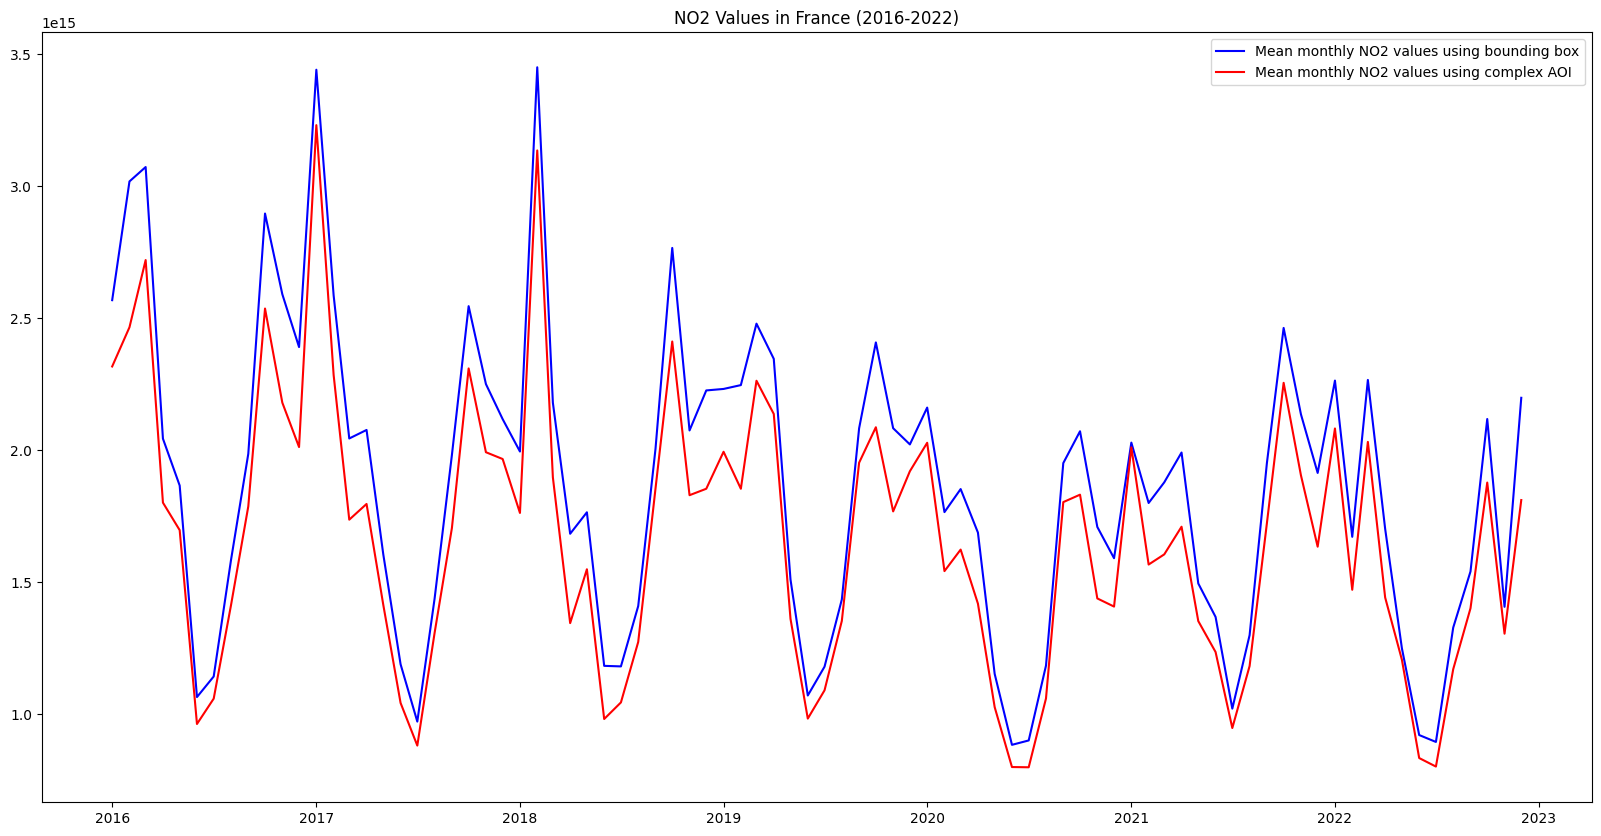

In [19]:
fig = plt.figure(figsize=(20,10))

plt.plot(df["date"], df["mean"], color='blue', label="Mean monthly NO2 values using bounding box")
plt.plot(aoi_df["date"], aoi_df["mean"], color='red', label="Mean monthly NO2 values using complex AOI")

plt.legend()
plt.title("NO2 Values in France (2016-2022)")

While the difference is small, it is very interesting to note that the NO2 values calculated using the exact borders are systematically less than when using the bounding box. This may be due to the fact that the bounding box includes parts of western Germany and northern Italy that have a lot industrial activity, whereas the areas included when using the exact borders that are not included in the bounding box case, are overseas territories much less industrial activity. 

## Speed things up: parallelize computation with Dask

We can drastically reduce the time it takes to generate the timeseries, even with the complex AOI above, by parallelizing our code. The `cogs/statistics` API is powered by AWS Lambda which executes each request in a separate instance. This means the requests are highly scalable. Since each statistics request is for a single timestamp, we can request statistics for multiple timesteps concurrently, and greatly reduce the amount of time needed. We will demonstrate this by using the Dask.

### Create a Dask client

First we will create a Dask client. In this case we will use the threads on the same server that is running this jupyter notebook.

In [22]:
import dask.distributed

client = dask.distributed.Client()

### Submit work

We will submit the `generate_stats` function for each item in our list and collect a list of futures. This will immediately kick off work in dask. We can then gather all the results.

In [23]:
%%time
futures = [client.submit(generate_stats, item, france_aoi) for item in items]
stats = client.gather(futures)

CPU times: user 5.15 s, sys: 583 ms, total: 5.73 s
Wall time: 44.4 s


### Close the Dask client

It is good practice to close the client when you are done. 

### Alternate approach

If you are familiar with the `concurrent.futures` library you can use that instead of Dask.